# This code is meant to test the Adam optimizer in two separates tasks as follows: 

## Task1: The Assigned paper expirements implementation: 
### First step: 
- Testing Adam with a Logisitc Regression model.
- Testing Adam with a Multi-layer neural network.
- testing Adam with  a Convolotional Neural Network model. 
### Second Step: 
- Conductimg a Sensetivity Analysis on the models results using different Hyper parameters for Adam optimizer. The parameters expiremented are as follows:

```
weight_decays = [1e-4, 1e-3]
beta1_values = [0.9, 0.99]
beta2_values = [0.999, 0.9999]
epsilons = [1e-6, 1e-4]
```

## Task2: Using Adam Optimizer to implement a DFST (Deep Feature Space Trojan Attack) to attack 2 CNN models trained on CIFAR10 dataset: 

- We used models that we have trained previously, the first model is a custom model that has originally
 73.96 training accuracy, while the second model is a pre-trained resnet30 model that has a testing accuracy of 84.62.
- The attack uses a CycleGan architecture to generate a trigger, the network uses Adam as its main optimizer for the generator and discremenator as well. 
- we used a 10% poisioning ratio to poison the dataset with the generated trigger, then we evaluated our attack to get a result as follows: 

#### Model1 Accuracy before Attack: 73.96%
#### Model1 Accuracy under attack: 62.34%
#### Model2 Accuracy before Attack: 84.62%
#### Model2 Accuracy under attack: 69.53%  


# Task1: Assigned paper expirements implementation

## 1) Setup:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## 2) Loading the dataset:

In [ ]:
# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

## 3) Implementing the paper Expieriences:  

### 1) Define the logistic regression model

In [ ]:
# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)

### 2) Define the multi-layer neural network model

In [ ]:
# Define the multi-layer neural network model
class MultiLayerNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiLayerNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### 3) Define the ConvNet:

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, input_shape):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(self._get_conv_output(input_shape), 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        return x

## 4) Training the  models:

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return running_loss / len(data_loader), 100.0 * correct / total

## 5) Evaluating the models: 

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / len(data_loader), 100.0 * correct / total

## 6) Conducting Sensetivity Analysis: 

In [ ]:
def sensitivity_analysis(model, data_loader, criterion):
    model.eval()
    sensitivity = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            scores, predicted = outputs.max(1)
            correct_idx = (predicted == targets)
            incorrect_idx = (predicted != targets)

            correct_scores = scores[correct_idx].cpu().numpy()
            incorrect_scores = scores[incorrect_idx].cpu().numpy()

            for score in correct_scores:
                sensitivity.append((score, True))
            for score in incorrect_scores:
                sensitivity.append((score, False))

    return sensitivity

## 7) Conducting Error Analysis:

In [ ]:
def error_analysis(model, data_loader, criterion):
    model.eval()
    error_analysis = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            for i in range(inputs.size(0)):
                if predicted[i] != targets[i]:
                    error_analysis.append((inputs[i].cpu().numpy(), predicted[i], targets[i]))

    return error_analysis

## 8) Experimenting Adam diffferent Hyperparameters above the three models:

In [ ]:
# Hyperparameters
weight_decays = [1e-4, 1e-3]
beta1_values = [0.9, 0.99]
beta2_values = [0.999, 0.9999]
epsilons = [1e-6, 1e-4]

models = {
    'Logistic Regression': LogisticRegression(input_dim=28*28, output_dim=10),
    'Multi Layer Network': MultiLayerNetwork(input_dim=28*28, hidden_dim=256, output_dim=10),
    'ConvNet': ConvNet(input_shape=(1, 28, 28))
}

## 9) Training, plotting, and looping over all of the functins: 

Training model: Logistic Regression with weight_decay=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.2664, Train Acc: 92.64%, Test Loss: 0.2671, Test Acc: 92.44%
Epoch 2/10, Train Loss: 0.2640, Train Acc: 92.73%, Test Loss: 0.2679, Test Acc: 92.54%
Epoch 3/10, Train Loss: 0.2626, Train Acc: 92.73%, Test Loss: 0.2658, Test Acc: 92.50%
Epoch 4/10, Train Loss: 0.2612, Train Acc: 92.72%, Test Loss: 0.2642, Test Acc: 92.64%
Epoch 5/10, Train Loss: 0.2599, Train Acc: 92.86%, Test Loss: 0.2642, Test Acc: 92.55%
Epoch 6/10, Train Loss: 0.2586, Train Acc: 92.84%, Test Loss: 0.2636, Test Acc: 92.61%
Epoch 7/10, Train Loss: 0.2579, Train Acc: 92.89%, Test Loss: 0.2627, Test Acc: 92.64%
Epoch 8/10, Train Loss: 0.2571, Train Acc: 92.91%, Test Loss: 0.2630, Test Acc: 92.63%
Epoch 9/10, Train Loss: 0.2563, Train Acc: 92.91%, Test Loss: 0.2654, Test Acc: 92.51%
Epoch 10/10, Train Loss: 0.2556, Train Acc: 92.97%, Test Loss: 0.2627, Test Acc: 92.52%
Sensitivity Analysis: 9252 co

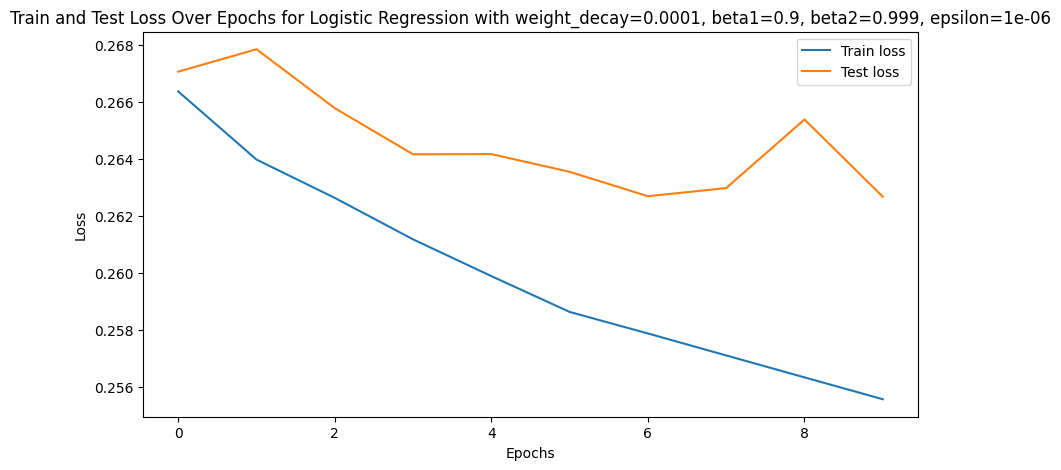

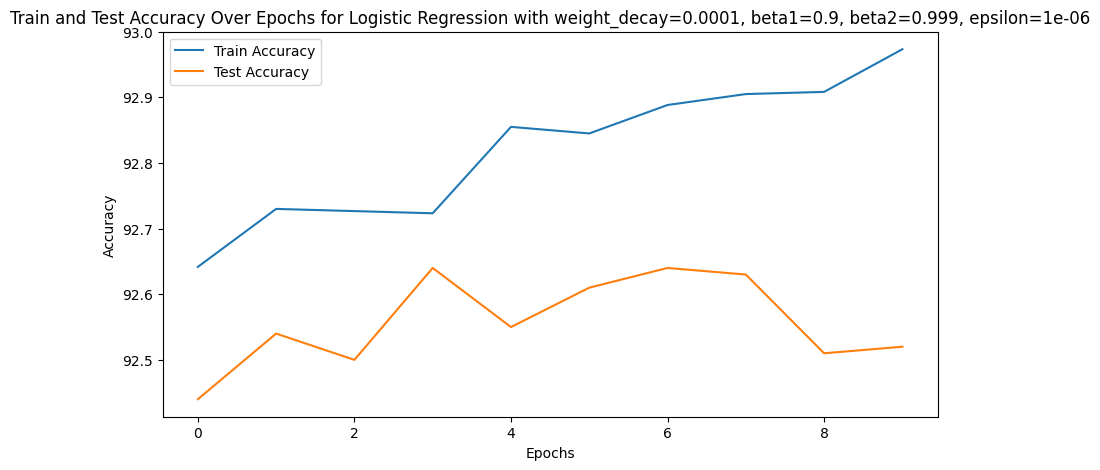

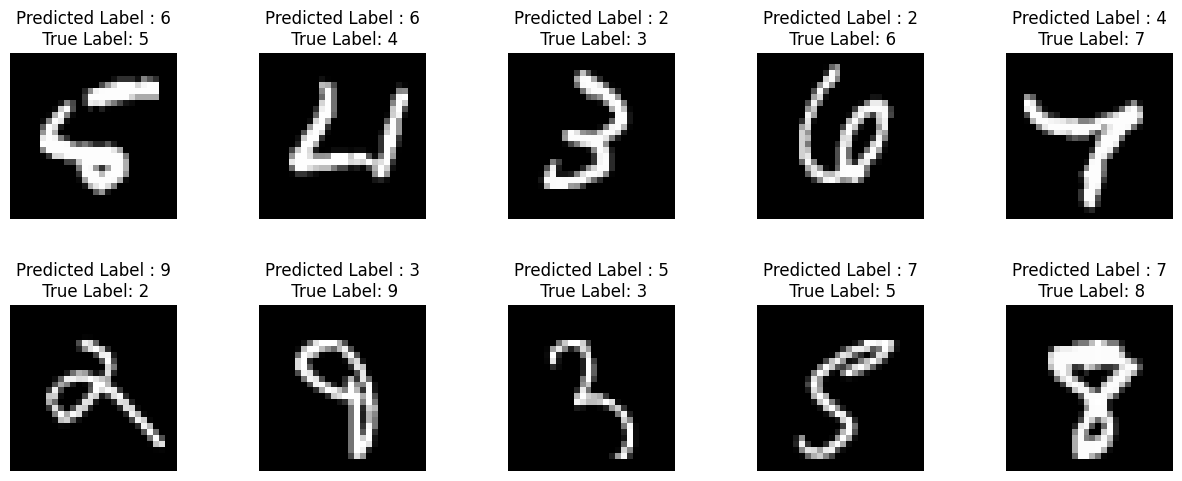

Training model: Multi Layer Network with weight_decay=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.1012, Train Acc: 96.86%, Test Loss: 0.0654, Test Acc: 98.01%
Epoch 2/10, Train Loss: 0.0943, Train Acc: 97.11%, Test Loss: 0.0693, Test Acc: 97.87%
Epoch 3/10, Train Loss: 0.0911, Train Acc: 97.13%, Test Loss: 0.0636, Test Acc: 97.94%
Epoch 4/10, Train Loss: 0.0920, Train Acc: 97.08%, Test Loss: 0.0651, Test Acc: 98.02%
Epoch 5/10, Train Loss: 0.0837, Train Acc: 97.45%, Test Loss: 0.0603, Test Acc: 98.19%
Epoch 6/10, Train Loss: 0.0862, Train Acc: 97.27%, Test Loss: 0.0656, Test Acc: 97.97%
Epoch 7/10, Train Loss: 0.0824, Train Acc: 97.39%, Test Loss: 0.0594, Test Acc: 98.17%
Epoch 8/10, Train Loss: 0.0824, Train Acc: 97.39%, Test Loss: 0.0650, Test Acc: 98.02%
Epoch 9/10, Train Loss: 0.0780, Train Acc: 97.46%, Test Loss: 0.0608, Test Acc: 98.22%
Epoch 10/10, Train Loss: 0.0809, Train Acc: 97.42%, Test Loss: 0.0639, Test Acc: 98.07%
Sensitivity Analysis: 9807 co

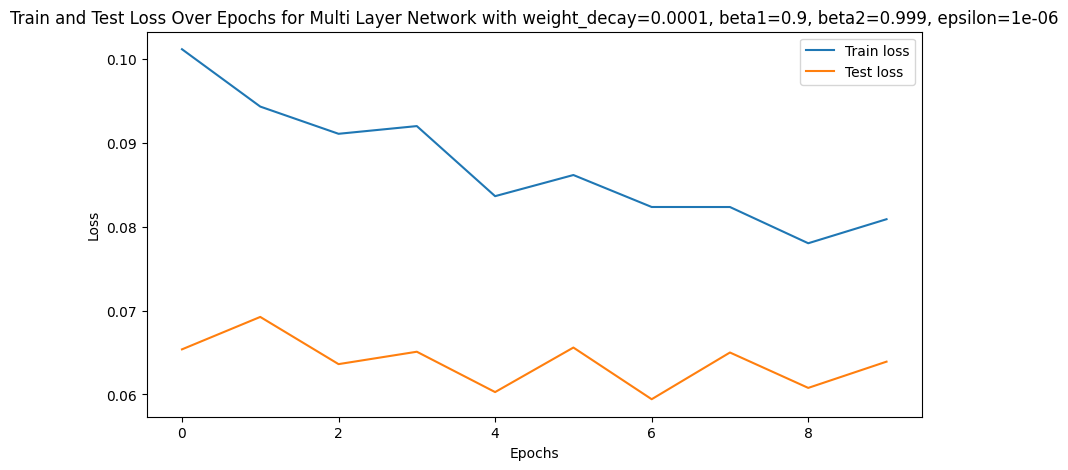

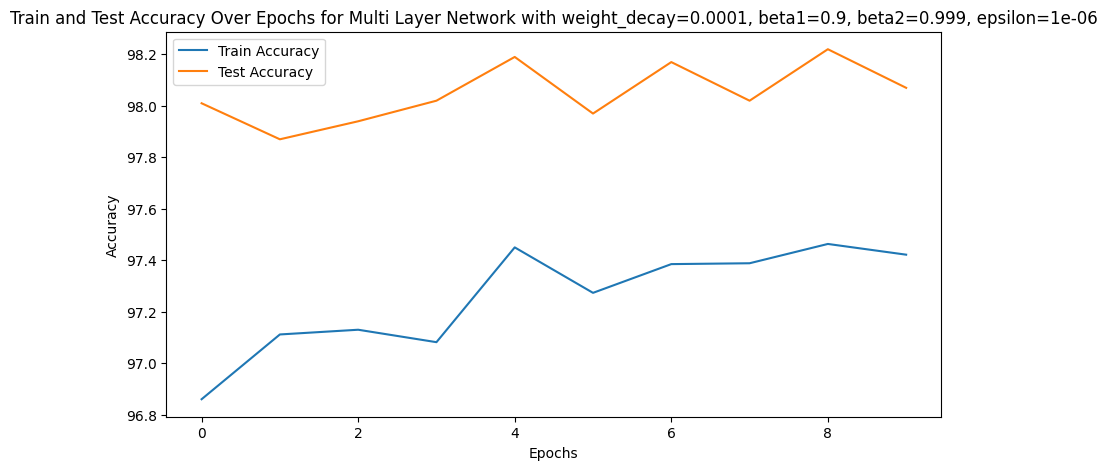

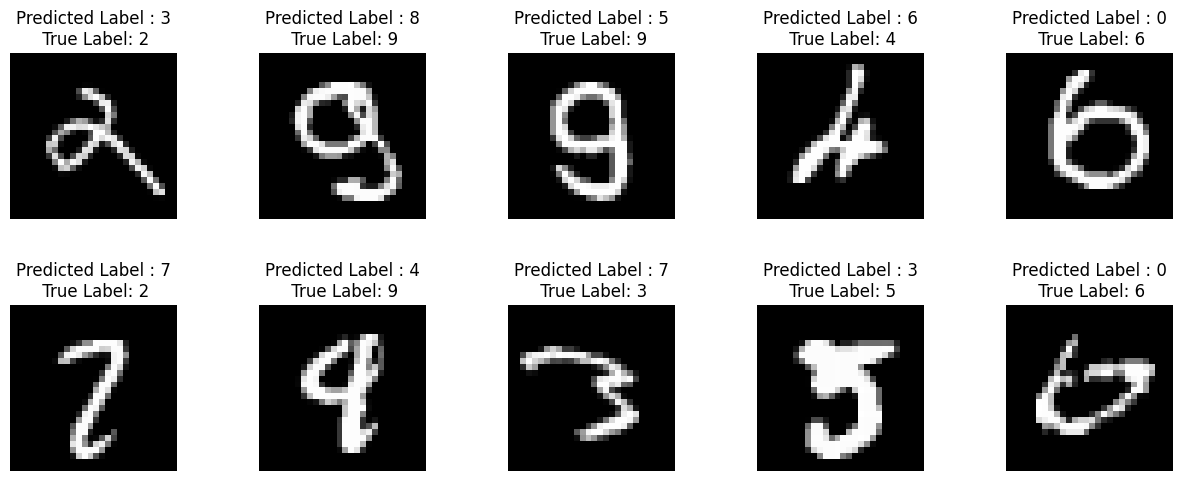

Training model: ConvNet with weight_decay=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.1271, Train Acc: 96.05%, Test Loss: 0.0461, Test Acc: 98.43%
Epoch 2/10, Train Loss: 0.0459, Train Acc: 98.53%, Test Loss: 0.0362, Test Acc: 98.84%
Epoch 3/10, Train Loss: 0.0296, Train Acc: 99.07%, Test Loss: 0.0358, Test Acc: 98.75%
Epoch 4/10, Train Loss: 0.0237, Train Acc: 99.19%, Test Loss: 0.0372, Test Acc: 98.79%
Epoch 5/10, Train Loss: 0.0213, Train Acc: 99.33%, Test Loss: 0.0333, Test Acc: 98.98%
Epoch 6/10, Train Loss: 0.0193, Train Acc: 99.40%, Test Loss: 0.0407, Test Acc: 98.68%
Epoch 7/10, Train Loss: 0.0149, Train Acc: 99.52%, Test Loss: 0.0372, Test Acc: 98.91%
Epoch 8/10, Train Loss: 0.0153, Train Acc: 99.50%, Test Loss: 0.0435, Test Acc: 98.68%
Epoch 9/10, Train Loss: 0.0147, Train Acc: 99.48%, Test Loss: 0.0367, Test Acc: 98.98%
Epoch 10/10, Train Loss: 0.0121, Train Acc: 99.58%, Test Loss: 0.0407, Test Acc: 98.85%
Sensitivity Analysis: 9885 correct and 11

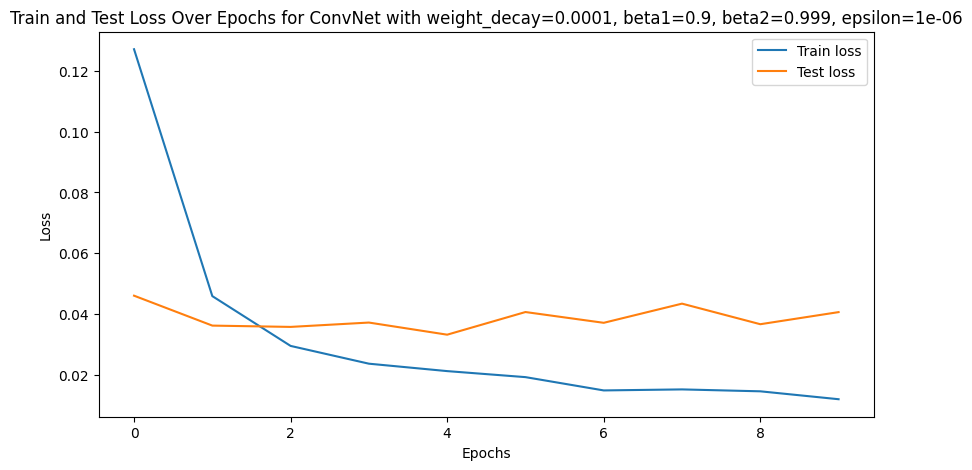

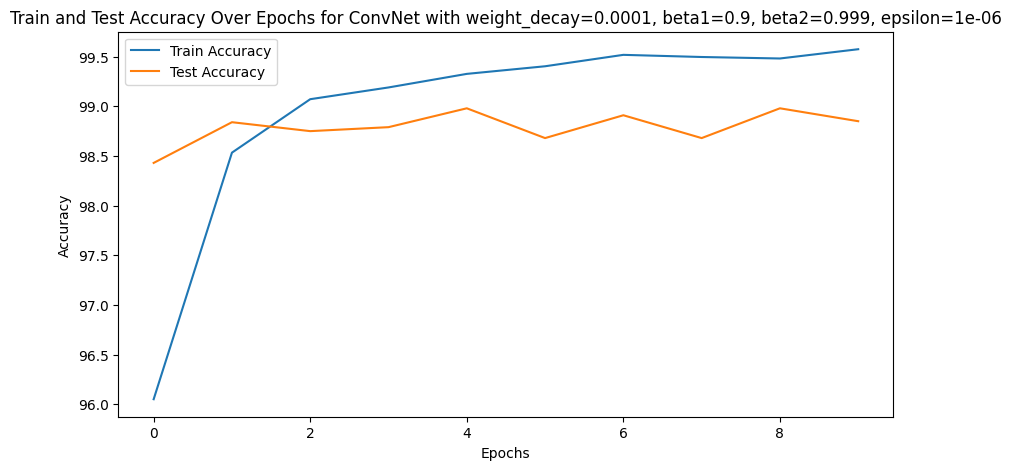

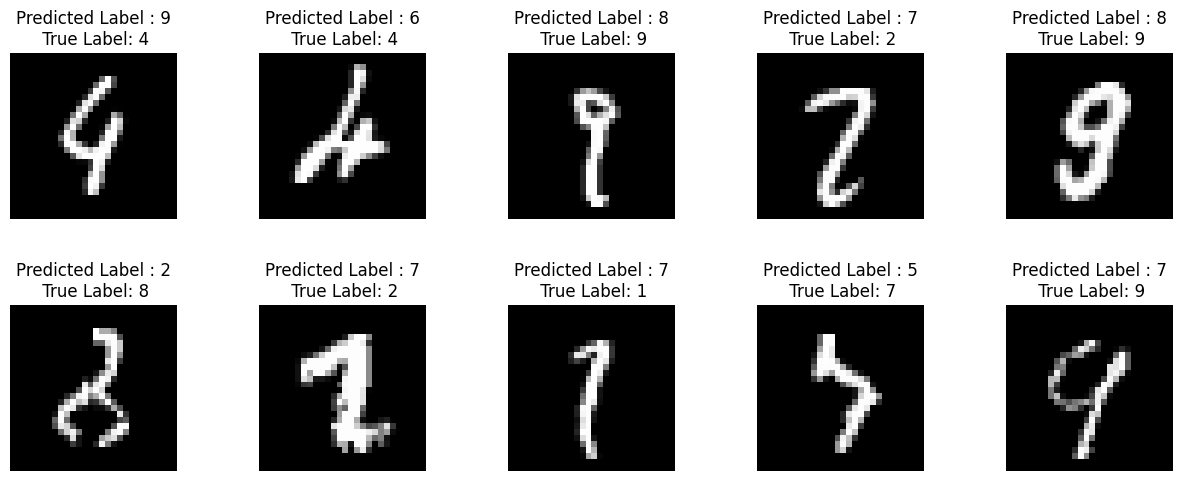

Training model: Logistic Regression with weight_decay=0.0001, beta1=0.9, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.2553, Train Acc: 92.94%, Test Loss: 0.2617, Test Acc: 92.68%
Epoch 2/10, Train Loss: 0.2544, Train Acc: 93.00%, Test Loss: 0.2612, Test Acc: 92.62%
Epoch 3/10, Train Loss: 0.2537, Train Acc: 93.00%, Test Loss: 0.2617, Test Acc: 92.67%
Epoch 4/10, Train Loss: 0.2532, Train Acc: 93.03%, Test Loss: 0.2628, Test Acc: 92.63%
Epoch 5/10, Train Loss: 0.2529, Train Acc: 93.05%, Test Loss: 0.2620, Test Acc: 92.62%
Epoch 6/10, Train Loss: 0.2525, Train Acc: 93.08%, Test Loss: 0.2633, Test Acc: 92.57%
Epoch 7/10, Train Loss: 0.2523, Train Acc: 93.08%, Test Loss: 0.2613, Test Acc: 92.66%
Epoch 8/10, Train Loss: 0.2521, Train Acc: 93.09%, Test Loss: 0.2645, Test Acc: 92.52%
Epoch 9/10, Train Loss: 0.2515, Train Acc: 93.09%, Test Loss: 0.2621, Test Acc: 92.50%
Epoch 10/10, Train Loss: 0.2511, Train Acc: 93.09%, Test Loss: 0.2611, Test Acc: 92.63%
Sensitivity Analysis: 9263 c

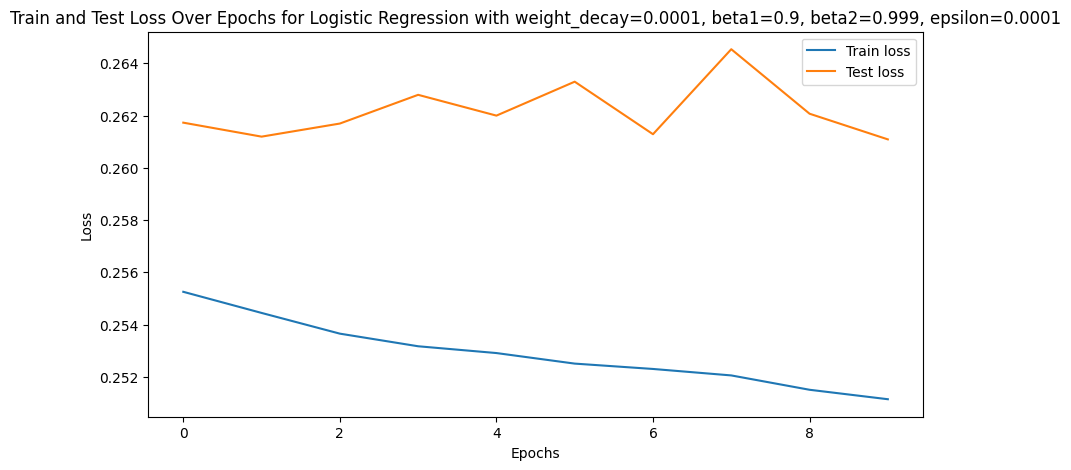

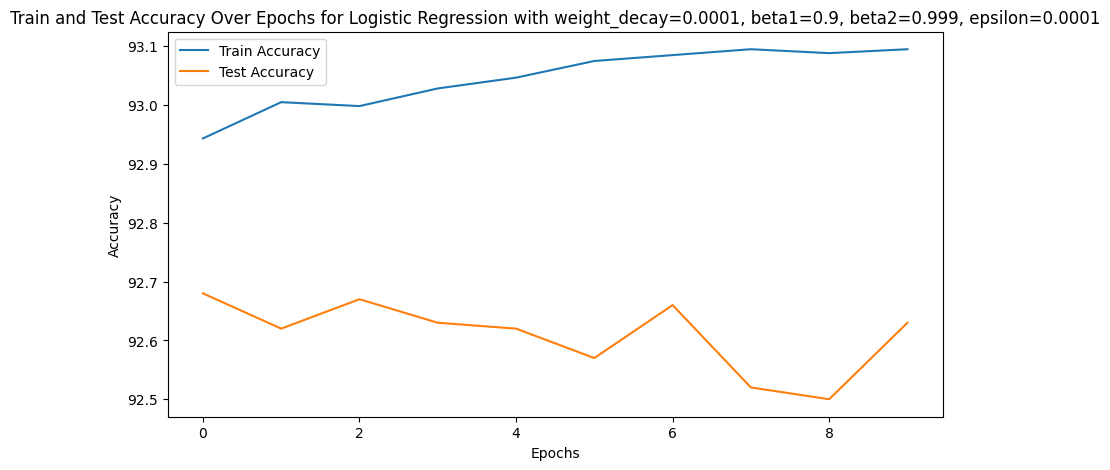

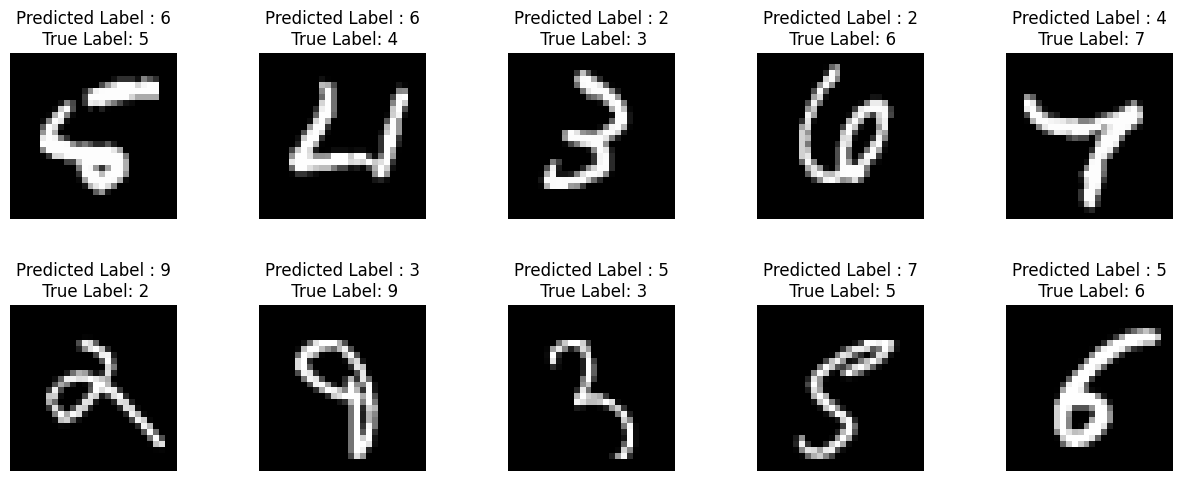

Training model: Multi Layer Network with weight_decay=0.0001, beta1=0.9, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0747, Train Acc: 97.65%, Test Loss: 0.0578, Test Acc: 98.24%
Epoch 2/10, Train Loss: 0.0759, Train Acc: 97.60%, Test Loss: 0.0577, Test Acc: 98.16%
Epoch 3/10, Train Loss: 0.0720, Train Acc: 97.71%, Test Loss: 0.0576, Test Acc: 98.22%
Epoch 4/10, Train Loss: 0.0728, Train Acc: 97.63%, Test Loss: 0.0622, Test Acc: 98.03%
Epoch 5/10, Train Loss: 0.0715, Train Acc: 97.72%, Test Loss: 0.0586, Test Acc: 98.27%
Epoch 6/10, Train Loss: 0.0713, Train Acc: 97.70%, Test Loss: 0.0620, Test Acc: 98.07%
Epoch 7/10, Train Loss: 0.0716, Train Acc: 97.68%, Test Loss: 0.0556, Test Acc: 98.32%
Epoch 8/10, Train Loss: 0.0676, Train Acc: 97.78%, Test Loss: 0.0589, Test Acc: 98.18%
Epoch 9/10, Train Loss: 0.0691, Train Acc: 97.80%, Test Loss: 0.0636, Test Acc: 98.13%
Epoch 10/10, Train Loss: 0.0656, Train Acc: 97.87%, Test Loss: 0.0644, Test Acc: 98.13%
Sensitivity Analysis: 9813 c

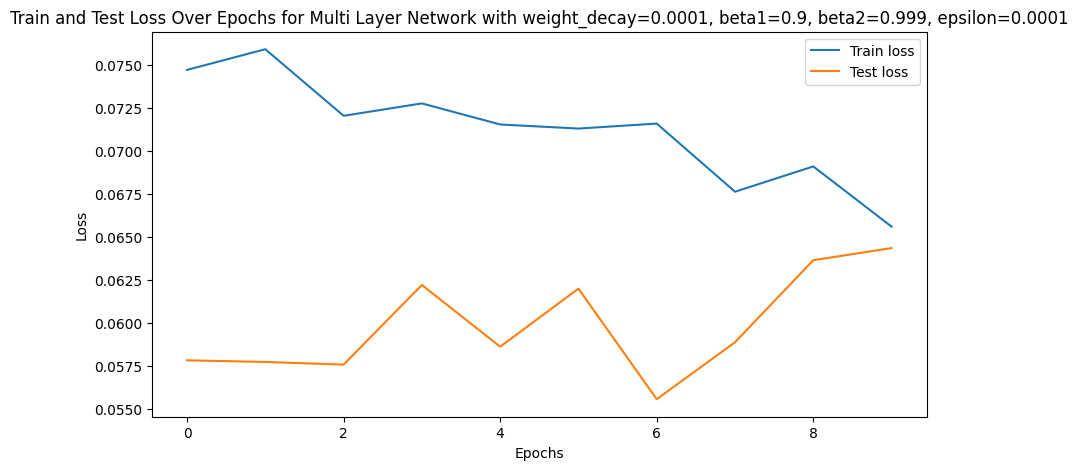

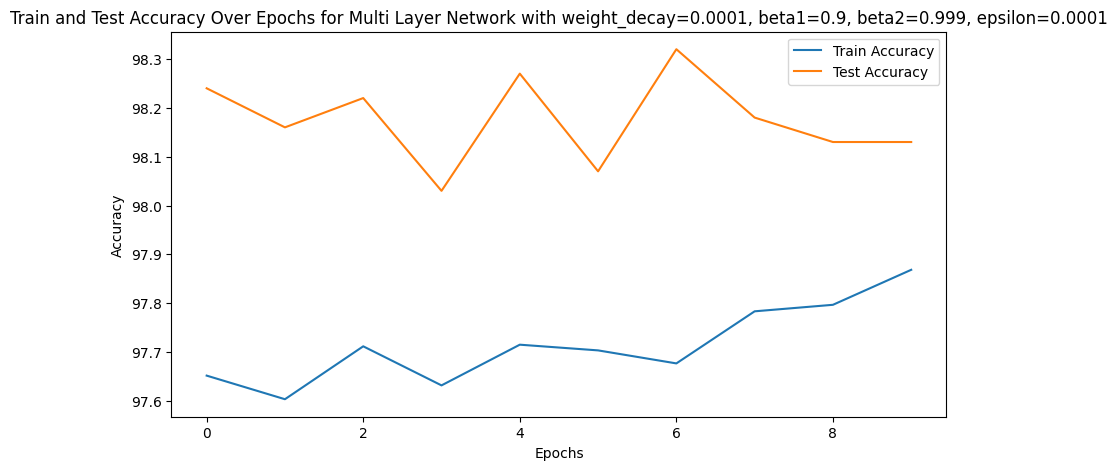

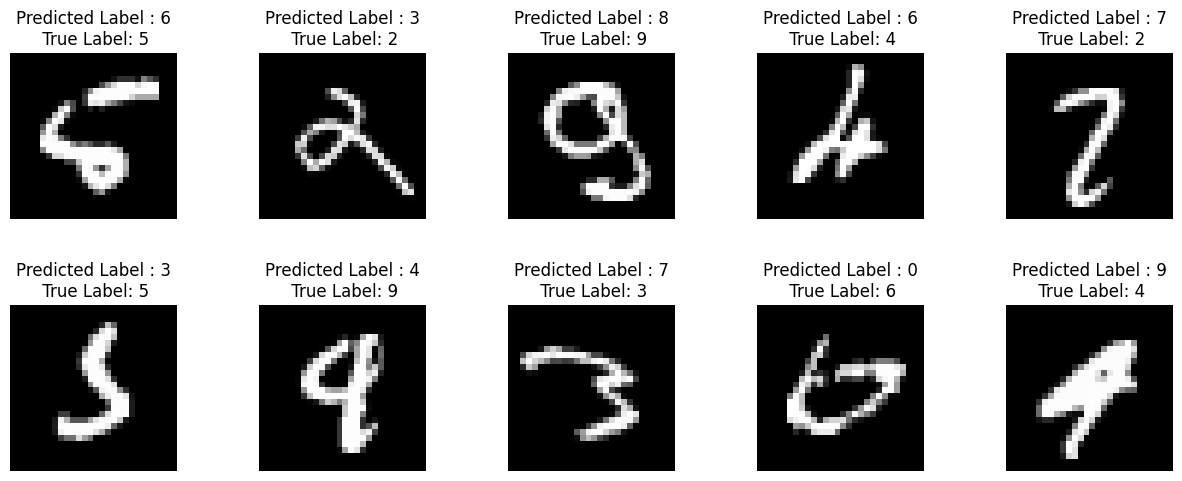

Training model: ConvNet with weight_decay=0.0001, beta1=0.9, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0114, Train Acc: 99.62%, Test Loss: 0.0494, Test Acc: 98.57%
Epoch 2/10, Train Loss: 0.0087, Train Acc: 99.70%, Test Loss: 0.0332, Test Acc: 99.09%
Epoch 3/10, Train Loss: 0.0101, Train Acc: 99.65%, Test Loss: 0.0265, Test Acc: 99.27%
Epoch 4/10, Train Loss: 0.0086, Train Acc: 99.70%, Test Loss: 0.0317, Test Acc: 99.15%
Epoch 5/10, Train Loss: 0.0066, Train Acc: 99.80%, Test Loss: 0.0310, Test Acc: 99.13%
Epoch 6/10, Train Loss: 0.0061, Train Acc: 99.80%, Test Loss: 0.0349, Test Acc: 98.86%
Epoch 7/10, Train Loss: 0.0074, Train Acc: 99.76%, Test Loss: 0.0375, Test Acc: 98.95%
Epoch 8/10, Train Loss: 0.0056, Train Acc: 99.81%, Test Loss: 0.0359, Test Acc: 99.05%
Epoch 9/10, Train Loss: 0.0059, Train Acc: 99.80%, Test Loss: 0.0275, Test Acc: 99.28%
Epoch 10/10, Train Loss: 0.0063, Train Acc: 99.79%, Test Loss: 0.0276, Test Acc: 99.19%
Sensitivity Analysis: 9919 correct and 8

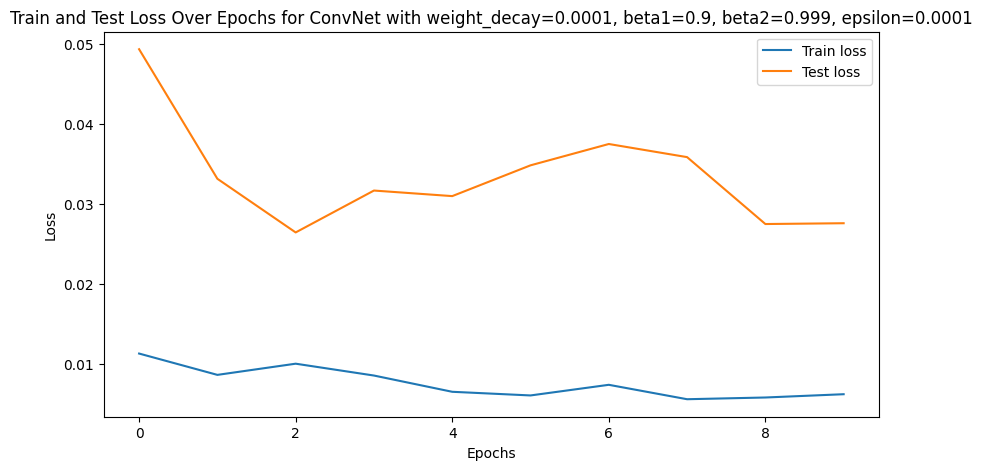

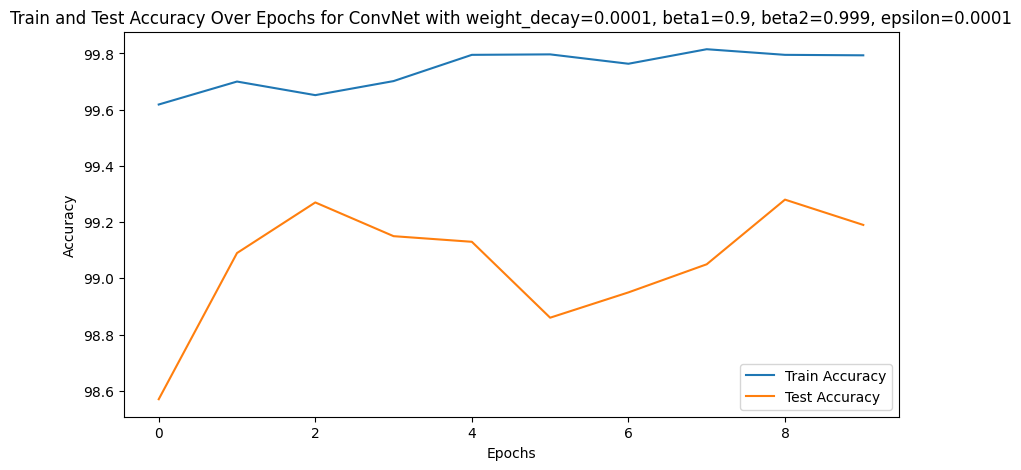

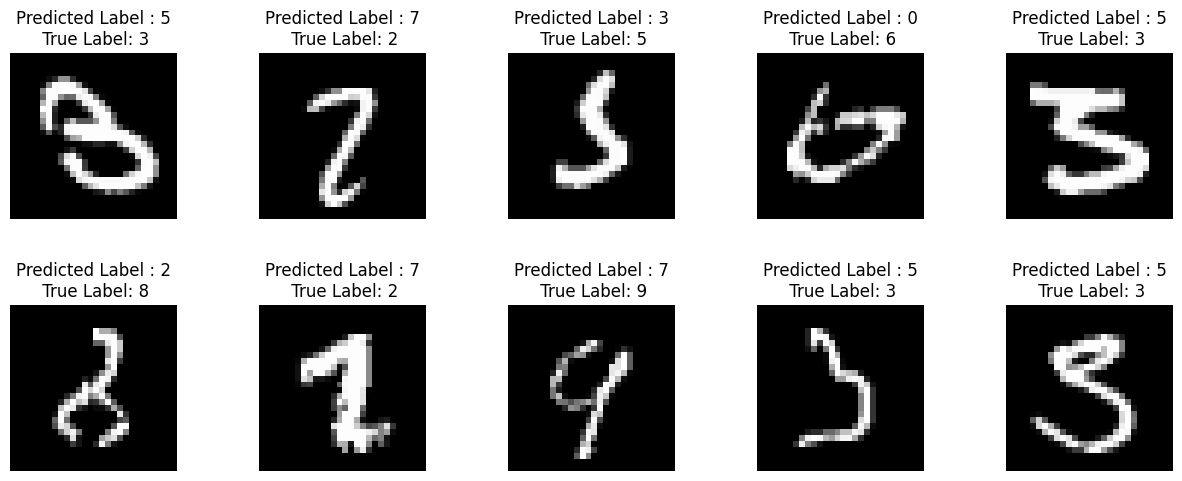

Training model: Logistic Regression with weight_decay=0.0001, beta1=0.9, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.2516, Train Acc: 93.06%, Test Loss: 0.2622, Test Acc: 92.56%
Epoch 2/10, Train Loss: 0.2514, Train Acc: 93.09%, Test Loss: 0.2610, Test Acc: 92.65%
Epoch 3/10, Train Loss: 0.2510, Train Acc: 93.06%, Test Loss: 0.2603, Test Acc: 92.61%
Epoch 4/10, Train Loss: 0.2507, Train Acc: 93.09%, Test Loss: 0.2671, Test Acc: 92.56%
Epoch 5/10, Train Loss: 0.2505, Train Acc: 93.06%, Test Loss: 0.2606, Test Acc: 92.62%
Epoch 6/10, Train Loss: 0.2498, Train Acc: 93.08%, Test Loss: 0.2621, Test Acc: 92.69%
Epoch 7/10, Train Loss: 0.2495, Train Acc: 93.12%, Test Loss: 0.2606, Test Acc: 92.70%
Epoch 8/10, Train Loss: 0.2498, Train Acc: 93.13%, Test Loss: 0.2605, Test Acc: 92.73%
Epoch 9/10, Train Loss: 0.2497, Train Acc: 93.14%, Test Loss: 0.2609, Test Acc: 92.66%
Epoch 10/10, Train Loss: 0.2492, Train Acc: 93.15%, Test Loss: 0.2618, Test Acc: 92.54%
Sensitivity Analysis: 9254 c

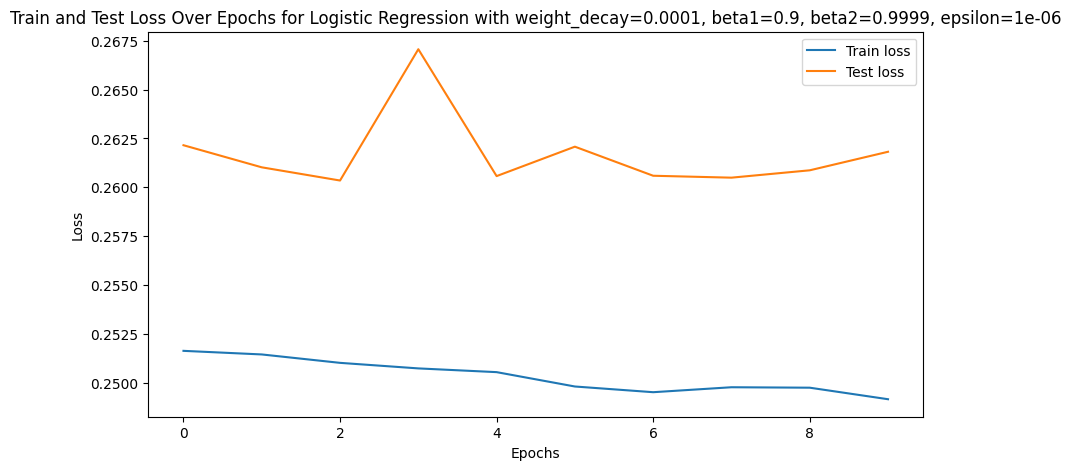

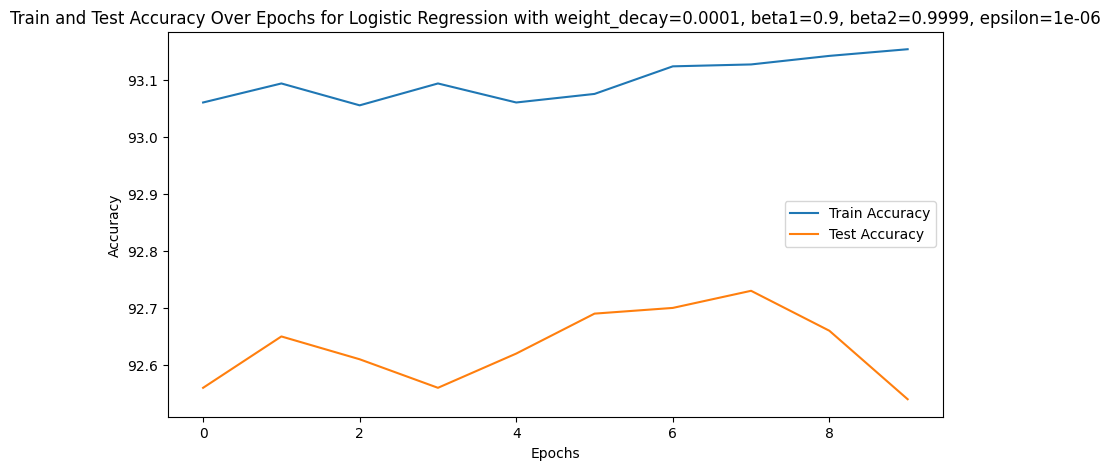

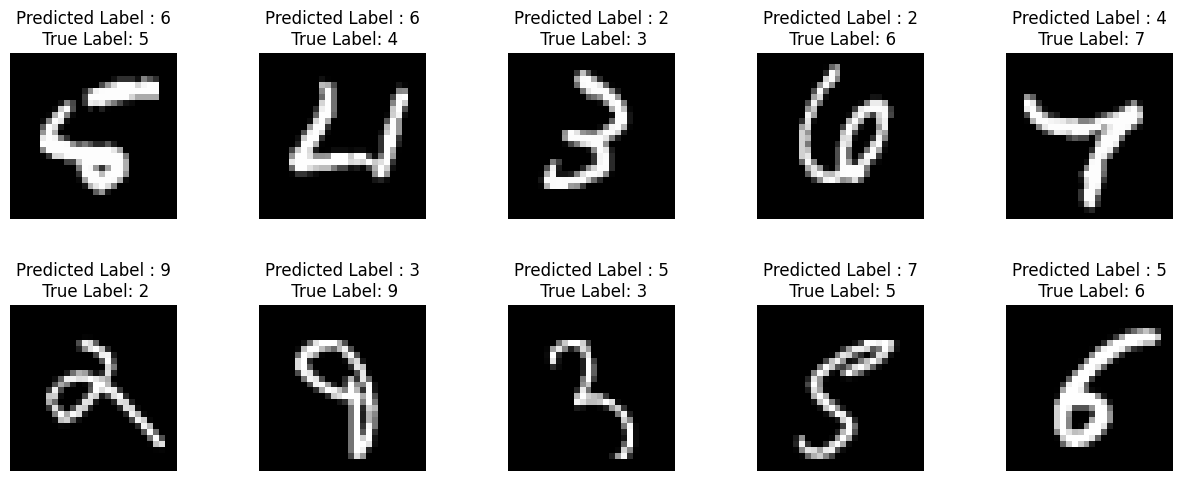

Training model: Multi Layer Network with weight_decay=0.0001, beta1=0.9, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0771, Train Acc: 97.60%, Test Loss: 0.0650, Test Acc: 98.12%
Epoch 2/10, Train Loss: 0.0730, Train Acc: 97.62%, Test Loss: 0.0584, Test Acc: 98.32%
Epoch 3/10, Train Loss: 0.0724, Train Acc: 97.79%, Test Loss: 0.0627, Test Acc: 98.18%
Epoch 4/10, Train Loss: 0.0697, Train Acc: 97.82%, Test Loss: 0.0617, Test Acc: 98.31%
Epoch 5/10, Train Loss: 0.0674, Train Acc: 97.89%, Test Loss: 0.0622, Test Acc: 98.29%
Epoch 6/10, Train Loss: 0.0695, Train Acc: 97.78%, Test Loss: 0.0602, Test Acc: 98.17%
Epoch 7/10, Train Loss: 0.0687, Train Acc: 97.72%, Test Loss: 0.0629, Test Acc: 98.15%
Epoch 8/10, Train Loss: 0.0670, Train Acc: 97.84%, Test Loss: 0.0626, Test Acc: 98.13%
Epoch 9/10, Train Loss: 0.0660, Train Acc: 97.90%, Test Loss: 0.0600, Test Acc: 98.23%
Epoch 10/10, Train Loss: 0.0650, Train Acc: 97.85%, Test Loss: 0.0610, Test Acc: 98.12%
Sensitivity Analysis: 9812 c

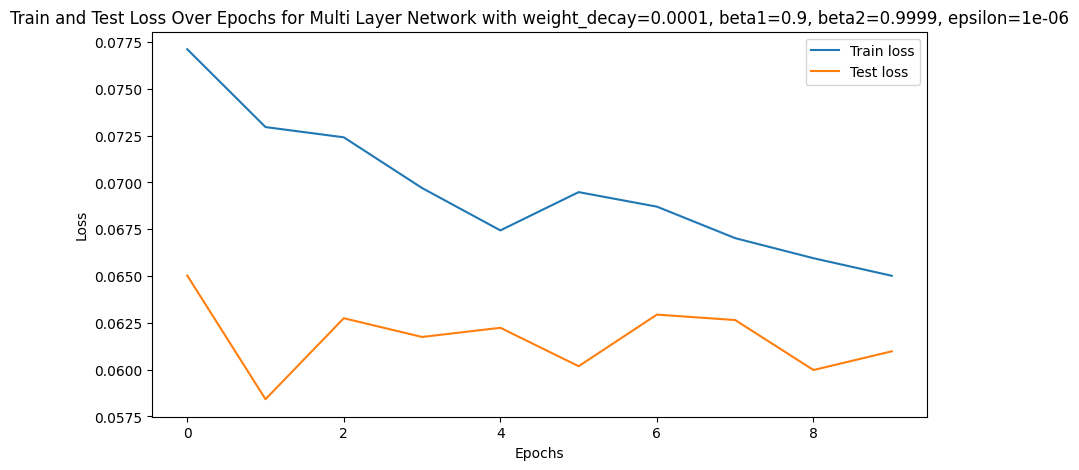

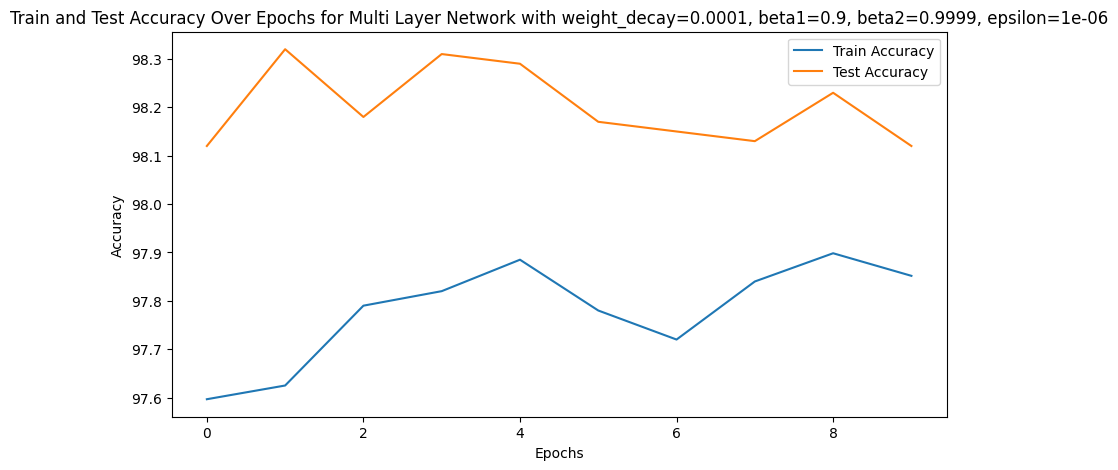

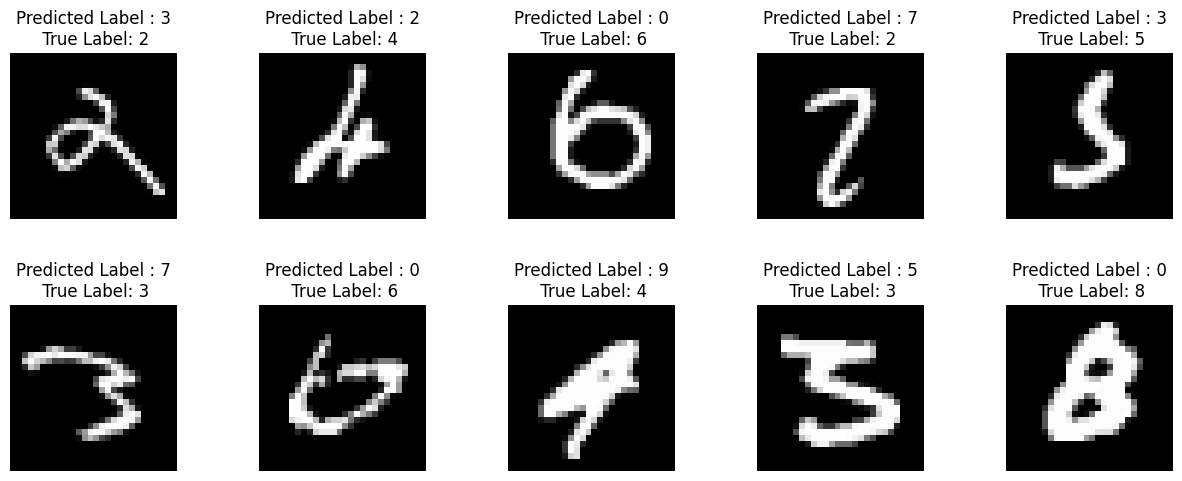

Training model: ConvNet with weight_decay=0.0001, beta1=0.9, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0097, Train Acc: 99.66%, Test Loss: 0.0403, Test Acc: 98.70%
Epoch 2/10, Train Loss: 0.0076, Train Acc: 99.75%, Test Loss: 0.0313, Test Acc: 99.02%
Epoch 3/10, Train Loss: 0.0066, Train Acc: 99.79%, Test Loss: 0.0401, Test Acc: 98.93%
Epoch 4/10, Train Loss: 0.0070, Train Acc: 99.78%, Test Loss: 0.0367, Test Acc: 99.02%
Epoch 5/10, Train Loss: 0.0072, Train Acc: 99.76%, Test Loss: 0.0348, Test Acc: 99.09%
Epoch 6/10, Train Loss: 0.0038, Train Acc: 99.89%, Test Loss: 0.0310, Test Acc: 99.15%
Epoch 7/10, Train Loss: 0.0047, Train Acc: 99.86%, Test Loss: 0.0326, Test Acc: 99.13%
Epoch 8/10, Train Loss: 0.0067, Train Acc: 99.77%, Test Loss: 0.0388, Test Acc: 99.01%
Epoch 9/10, Train Loss: 0.0065, Train Acc: 99.78%, Test Loss: 0.0292, Test Acc: 99.13%
Epoch 10/10, Train Loss: 0.0044, Train Acc: 99.86%, Test Loss: 0.0343, Test Acc: 99.05%
Sensitivity Analysis: 9905 correct and 9

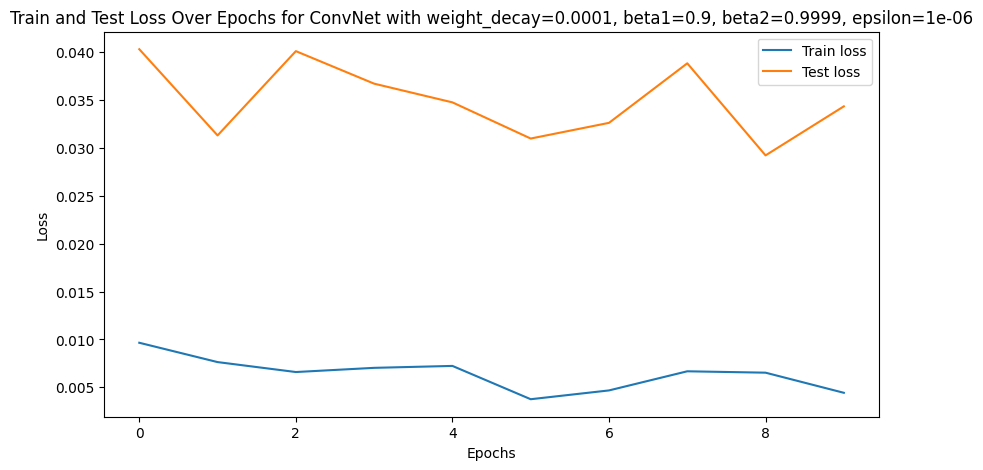

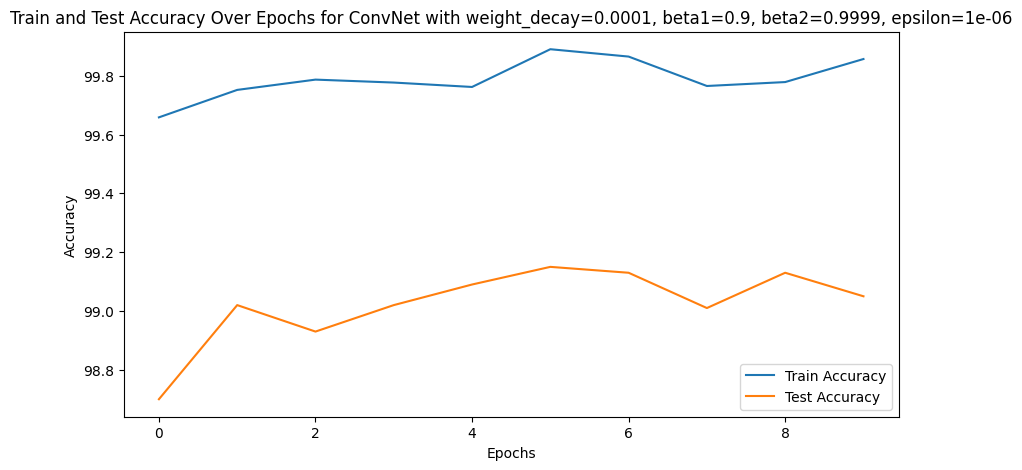

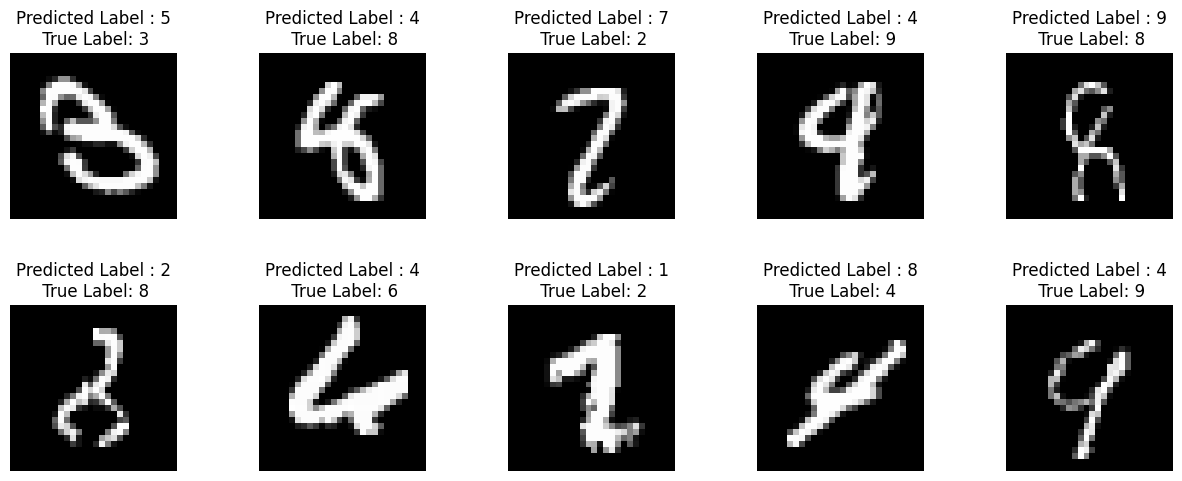

Training model: Logistic Regression with weight_decay=0.0001, beta1=0.9, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.2493, Train Acc: 93.14%, Test Loss: 0.2612, Test Acc: 92.70%
Epoch 2/10, Train Loss: 0.2485, Train Acc: 93.15%, Test Loss: 0.2600, Test Acc: 92.52%
Epoch 3/10, Train Loss: 0.2489, Train Acc: 93.13%, Test Loss: 0.2624, Test Acc: 92.60%
Epoch 4/10, Train Loss: 0.2487, Train Acc: 93.14%, Test Loss: 0.2610, Test Acc: 92.62%
Epoch 5/10, Train Loss: 0.2483, Train Acc: 93.19%, Test Loss: 0.2610, Test Acc: 92.63%
Epoch 6/10, Train Loss: 0.2484, Train Acc: 93.20%, Test Loss: 0.2599, Test Acc: 92.65%
Epoch 7/10, Train Loss: 0.2478, Train Acc: 93.15%, Test Loss: 0.2622, Test Acc: 92.68%
Epoch 8/10, Train Loss: 0.2478, Train Acc: 93.16%, Test Loss: 0.2636, Test Acc: 92.50%
Epoch 9/10, Train Loss: 0.2479, Train Acc: 93.16%, Test Loss: 0.2616, Test Acc: 92.58%
Epoch 10/10, Train Loss: 0.2477, Train Acc: 93.17%, Test Loss: 0.2618, Test Acc: 92.60%
Sensitivity Analysis: 9260 

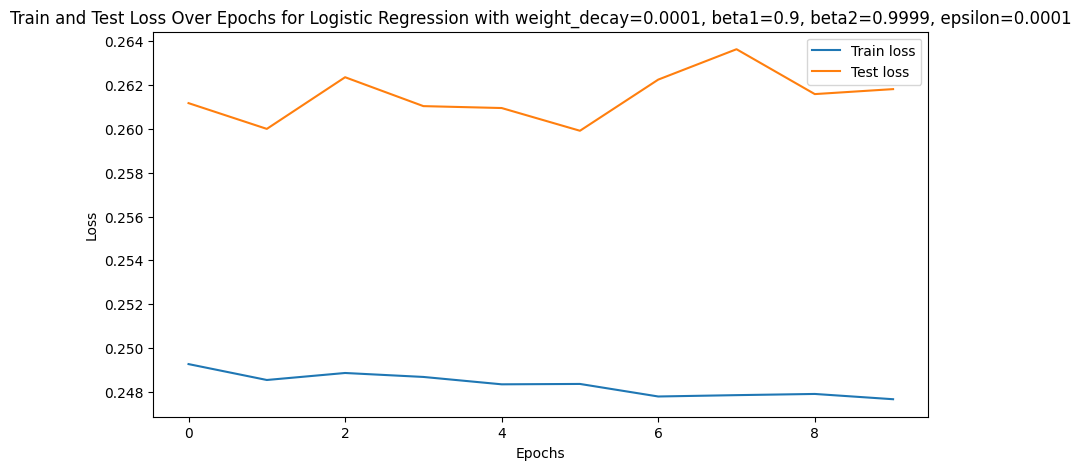

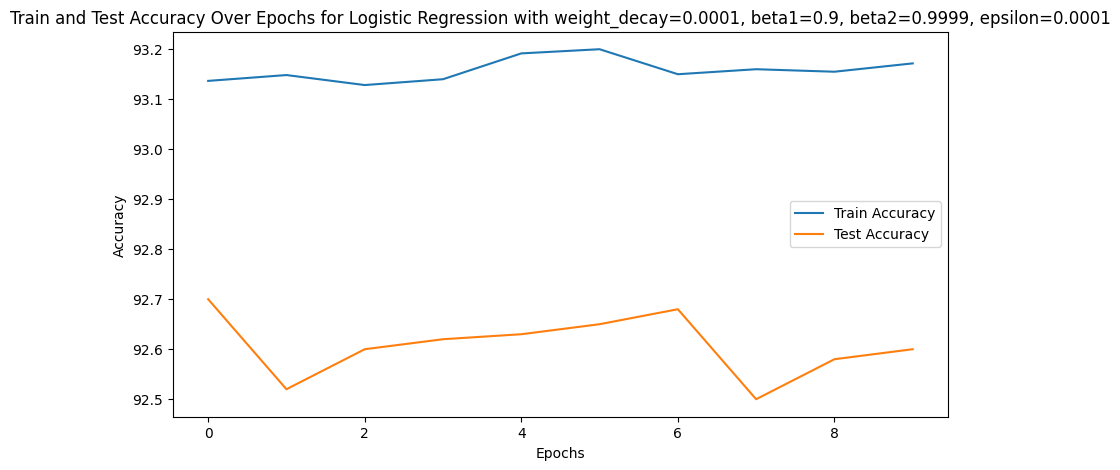

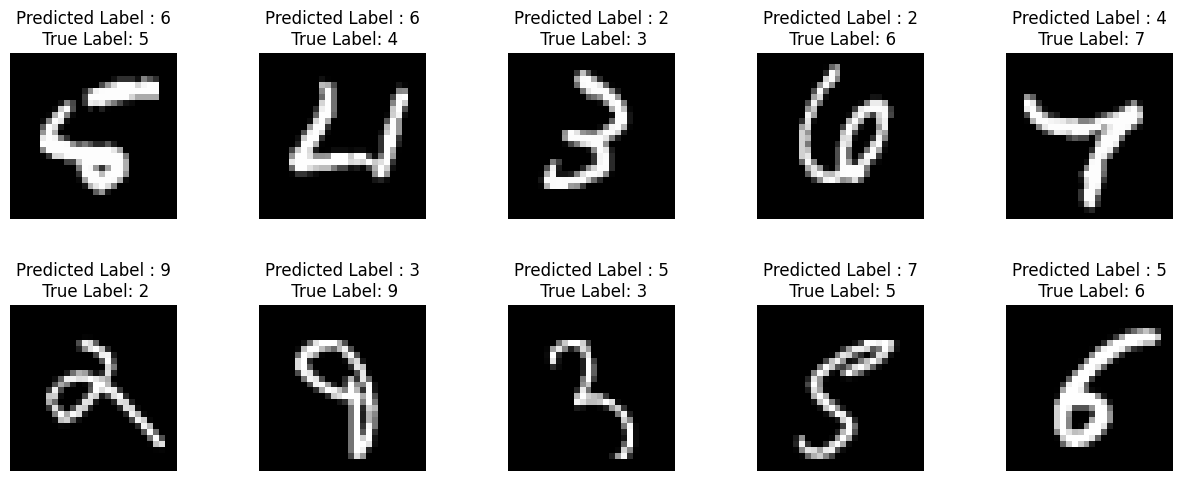

Training model: Multi Layer Network with weight_decay=0.0001, beta1=0.9, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0654, Train Acc: 97.86%, Test Loss: 0.0608, Test Acc: 98.15%
Epoch 2/10, Train Loss: 0.0639, Train Acc: 98.00%, Test Loss: 0.0572, Test Acc: 98.32%
Epoch 3/10, Train Loss: 0.0672, Train Acc: 97.92%, Test Loss: 0.0600, Test Acc: 98.19%
Epoch 4/10, Train Loss: 0.0647, Train Acc: 97.92%, Test Loss: 0.0556, Test Acc: 98.36%
Epoch 5/10, Train Loss: 0.0644, Train Acc: 98.00%, Test Loss: 0.0593, Test Acc: 98.22%
Epoch 6/10, Train Loss: 0.0616, Train Acc: 98.02%, Test Loss: 0.0592, Test Acc: 98.27%
Epoch 7/10, Train Loss: 0.0629, Train Acc: 98.03%, Test Loss: 0.0588, Test Acc: 98.41%
Epoch 8/10, Train Loss: 0.0613, Train Acc: 98.02%, Test Loss: 0.0600, Test Acc: 98.23%
Epoch 9/10, Train Loss: 0.0634, Train Acc: 97.96%, Test Loss: 0.0580, Test Acc: 98.23%
Epoch 10/10, Train Loss: 0.0623, Train Acc: 97.98%, Test Loss: 0.0548, Test Acc: 98.26%
Sensitivity Analysis: 9826 

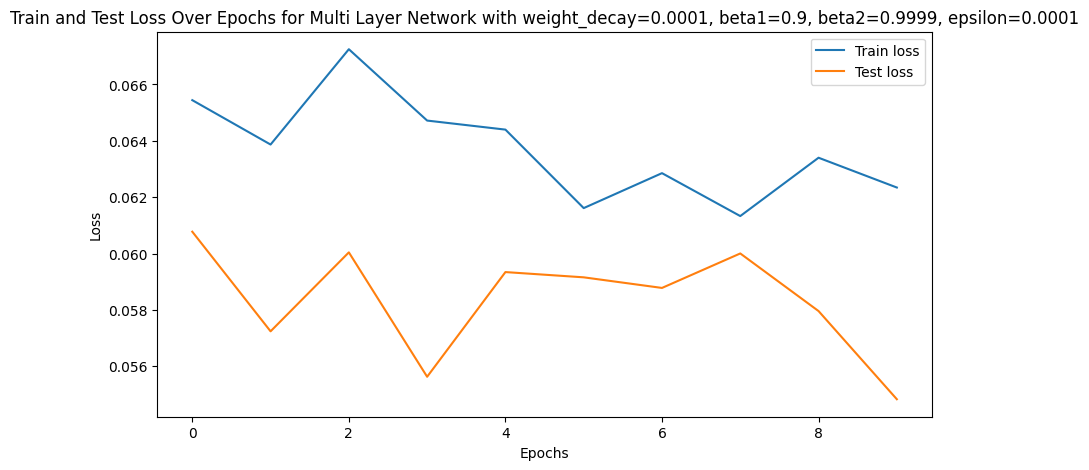

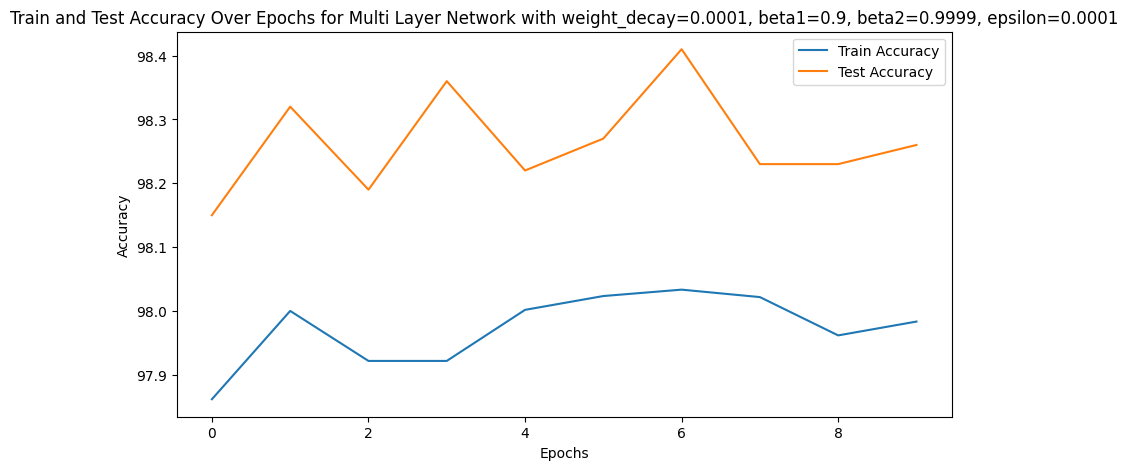

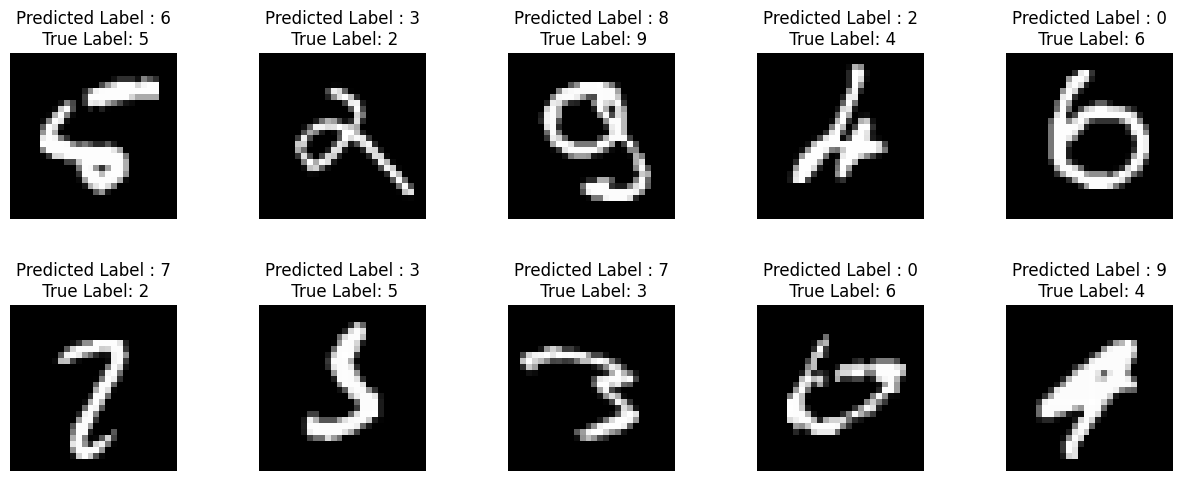

Training model: ConvNet with weight_decay=0.0001, beta1=0.9, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0052, Train Acc: 99.83%, Test Loss: 0.0278, Test Acc: 99.20%
Epoch 2/10, Train Loss: 0.0037, Train Acc: 99.89%, Test Loss: 0.0268, Test Acc: 99.23%
Epoch 3/10, Train Loss: 0.0042, Train Acc: 99.87%, Test Loss: 0.0387, Test Acc: 98.95%
Epoch 4/10, Train Loss: 0.0046, Train Acc: 99.85%, Test Loss: 0.0303, Test Acc: 99.16%
Epoch 5/10, Train Loss: 0.0052, Train Acc: 99.83%, Test Loss: 0.0368, Test Acc: 99.07%
Epoch 6/10, Train Loss: 0.0033, Train Acc: 99.89%, Test Loss: 0.0267, Test Acc: 99.21%
Epoch 7/10, Train Loss: 0.0033, Train Acc: 99.90%, Test Loss: 0.0363, Test Acc: 99.08%
Epoch 8/10, Train Loss: 0.0042, Train Acc: 99.87%, Test Loss: 0.0318, Test Acc: 99.06%
Epoch 9/10, Train Loss: 0.0059, Train Acc: 99.81%, Test Loss: 0.0334, Test Acc: 99.12%
Epoch 10/10, Train Loss: 0.0034, Train Acc: 99.91%, Test Loss: 0.0452, Test Acc: 98.99%
Sensitivity Analysis: 9899 correct and 

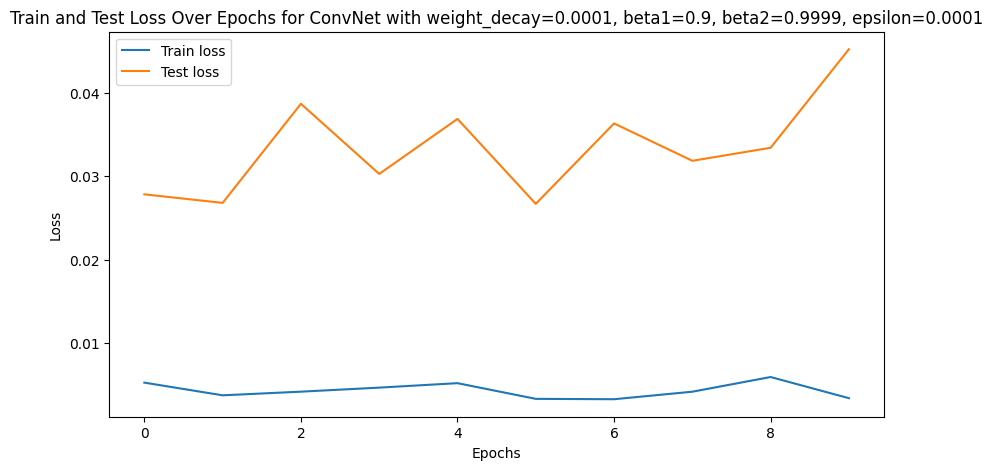

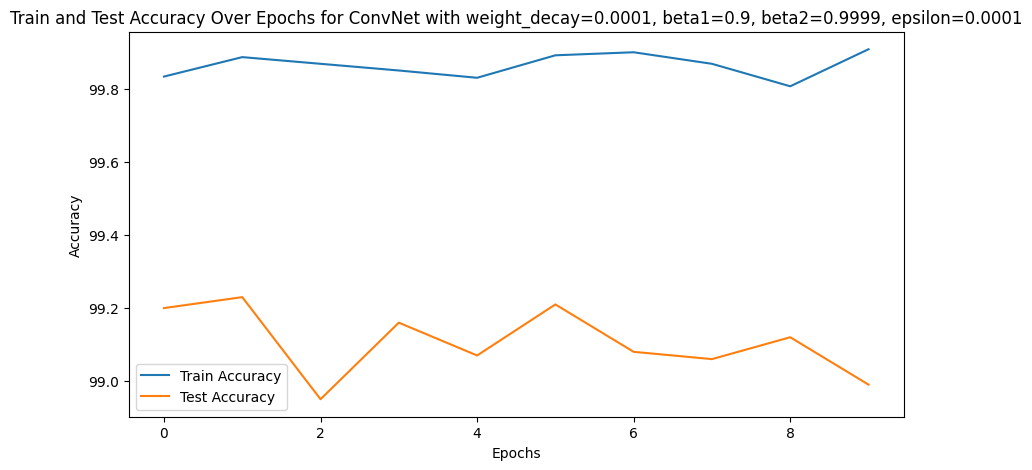

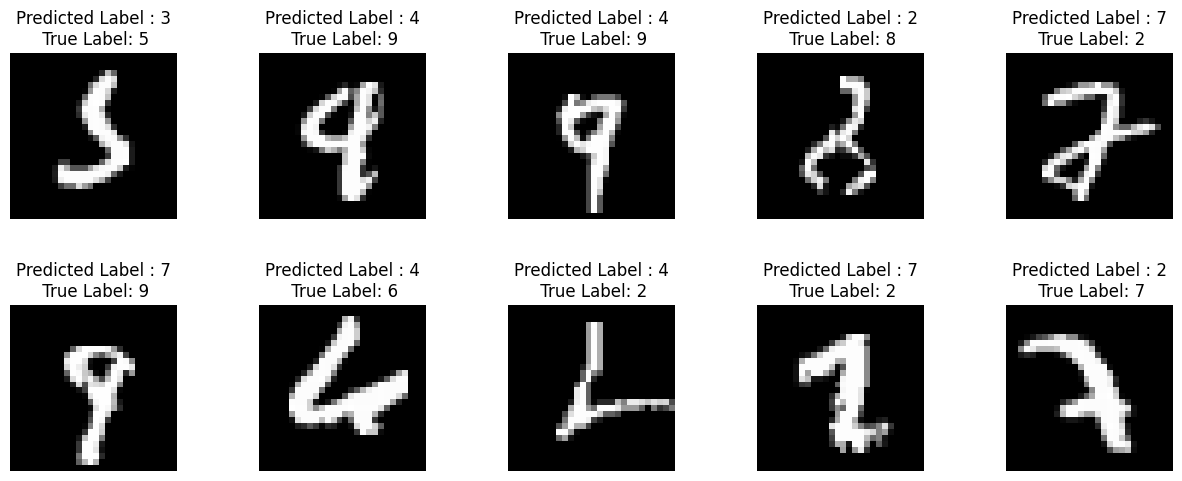

Training model: Logistic Regression with weight_decay=0.0001, beta1=0.99, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.2486, Train Acc: 93.14%, Test Loss: 0.2619, Test Acc: 92.74%
Epoch 2/10, Train Loss: 0.2479, Train Acc: 93.16%, Test Loss: 0.2614, Test Acc: 92.81%
Epoch 3/10, Train Loss: 0.2468, Train Acc: 93.18%, Test Loss: 0.2623, Test Acc: 92.70%
Epoch 4/10, Train Loss: 0.2467, Train Acc: 93.22%, Test Loss: 0.2615, Test Acc: 92.55%
Epoch 5/10, Train Loss: 0.2469, Train Acc: 93.23%, Test Loss: 0.2601, Test Acc: 92.74%
Epoch 6/10, Train Loss: 0.2465, Train Acc: 93.22%, Test Loss: 0.2636, Test Acc: 92.59%
Epoch 7/10, Train Loss: 0.2470, Train Acc: 93.15%, Test Loss: 0.2660, Test Acc: 92.45%
Epoch 8/10, Train Loss: 0.2472, Train Acc: 93.19%, Test Loss: 0.2628, Test Acc: 92.68%
Epoch 9/10, Train Loss: 0.2462, Train Acc: 93.24%, Test Loss: 0.2639, Test Acc: 92.58%
Epoch 10/10, Train Loss: 0.2462, Train Acc: 93.21%, Test Loss: 0.2621, Test Acc: 92.60%
Sensitivity Analysis: 9260 c

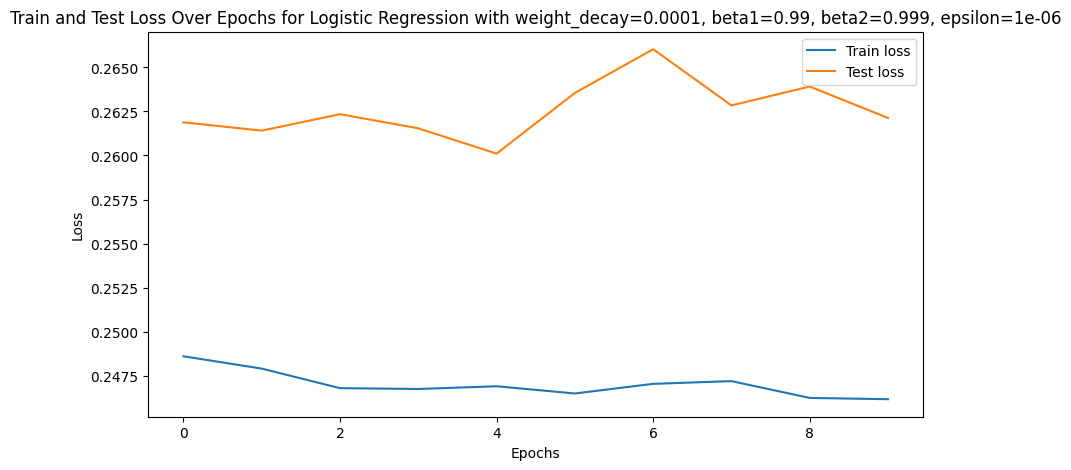

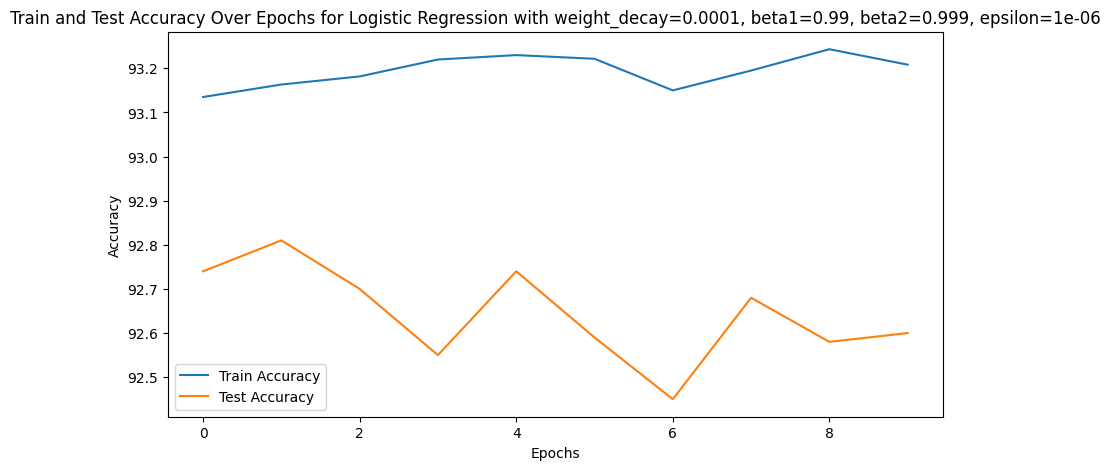

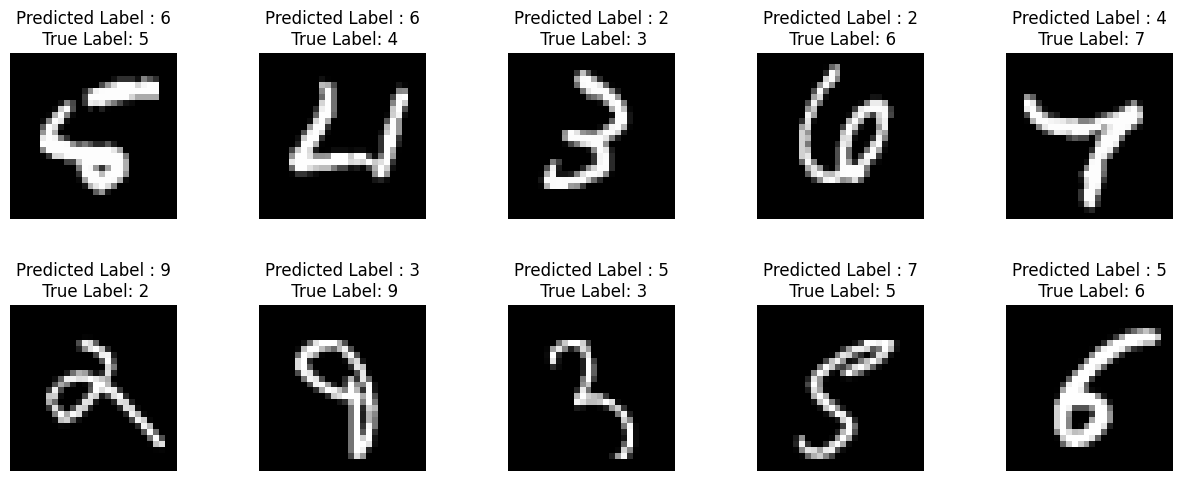

Training model: Multi Layer Network with weight_decay=0.0001, beta1=0.99, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0783, Train Acc: 97.45%, Test Loss: 0.0624, Test Acc: 98.31%
Epoch 2/10, Train Loss: 0.0673, Train Acc: 97.81%, Test Loss: 0.0605, Test Acc: 98.23%
Epoch 3/10, Train Loss: 0.0640, Train Acc: 97.95%, Test Loss: 0.0607, Test Acc: 98.14%
Epoch 4/10, Train Loss: 0.0648, Train Acc: 97.95%, Test Loss: 0.0570, Test Acc: 98.23%
Epoch 5/10, Train Loss: 0.0661, Train Acc: 97.89%, Test Loss: 0.0592, Test Acc: 98.27%
Epoch 6/10, Train Loss: 0.0661, Train Acc: 97.88%, Test Loss: 0.0563, Test Acc: 98.40%
Epoch 7/10, Train Loss: 0.0663, Train Acc: 97.88%, Test Loss: 0.0651, Test Acc: 98.13%
Epoch 8/10, Train Loss: 0.0649, Train Acc: 97.89%, Test Loss: 0.0598, Test Acc: 98.41%
Epoch 9/10, Train Loss: 0.0650, Train Acc: 97.96%, Test Loss: 0.0602, Test Acc: 98.27%
Epoch 10/10, Train Loss: 0.0622, Train Acc: 98.01%, Test Loss: 0.0570, Test Acc: 98.33%
Sensitivity Analysis: 9833 c

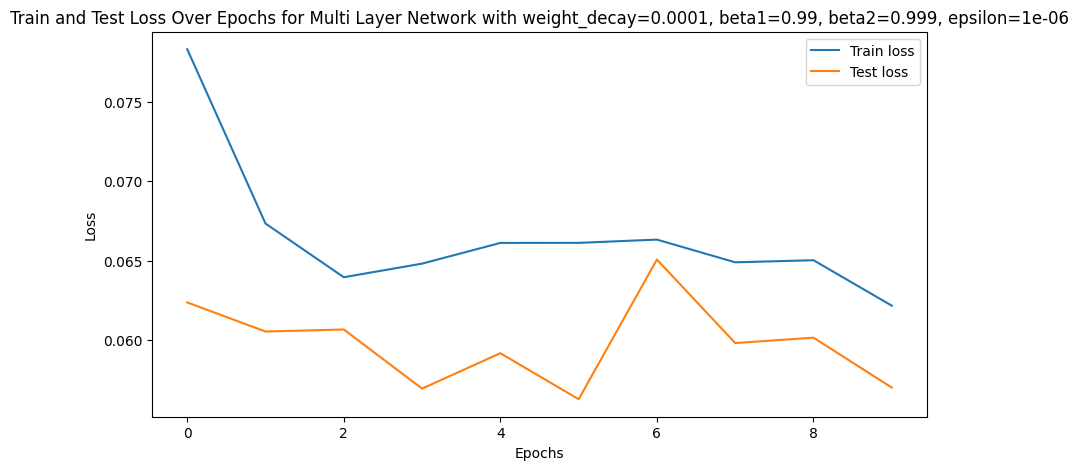

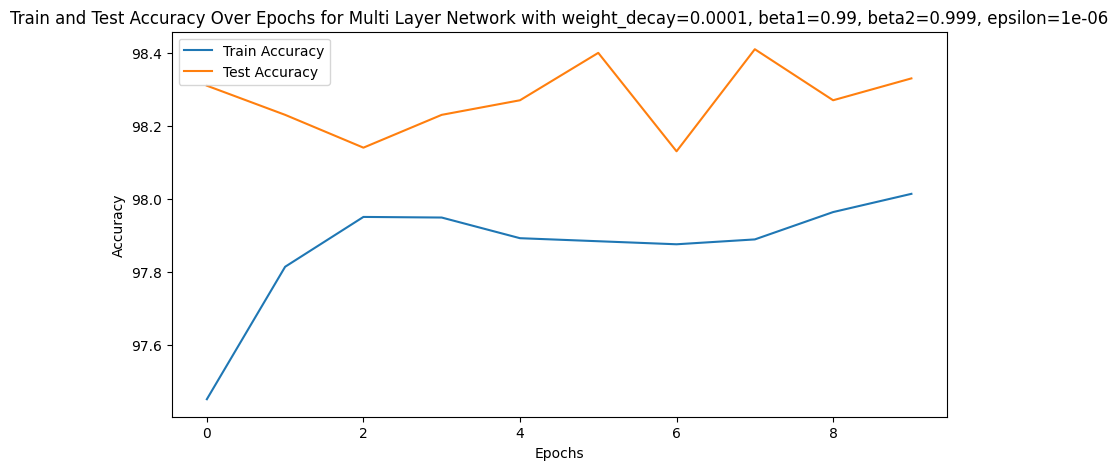

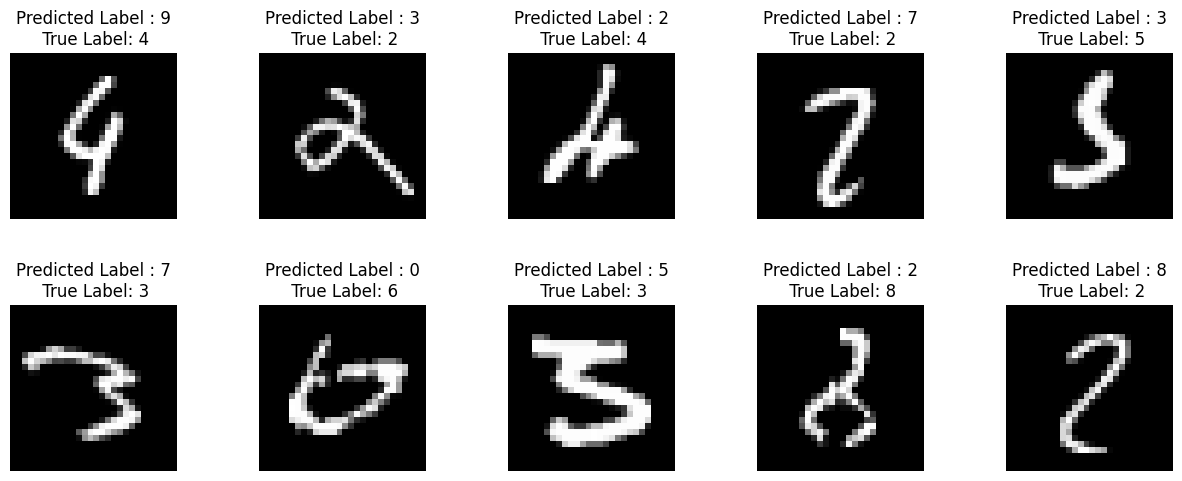

Training model: ConvNet with weight_decay=0.0001, beta1=0.99, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0067, Train Acc: 99.77%, Test Loss: 0.0326, Test Acc: 99.03%
Epoch 2/10, Train Loss: 0.0049, Train Acc: 99.84%, Test Loss: 0.0397, Test Acc: 99.03%
Epoch 3/10, Train Loss: 0.0043, Train Acc: 99.85%, Test Loss: 0.0331, Test Acc: 99.22%
Epoch 4/10, Train Loss: 0.0032, Train Acc: 99.91%, Test Loss: 0.0338, Test Acc: 99.09%
Epoch 5/10, Train Loss: 0.0027, Train Acc: 99.94%, Test Loss: 0.0291, Test Acc: 99.13%
Epoch 6/10, Train Loss: 0.0041, Train Acc: 99.88%, Test Loss: 0.0343, Test Acc: 99.10%
Epoch 7/10, Train Loss: 0.0053, Train Acc: 99.81%, Test Loss: 0.0347, Test Acc: 98.99%
Epoch 8/10, Train Loss: 0.0043, Train Acc: 99.86%, Test Loss: 0.0343, Test Acc: 99.11%
Epoch 9/10, Train Loss: 0.0033, Train Acc: 99.89%, Test Loss: 0.0314, Test Acc: 99.11%
Epoch 10/10, Train Loss: 0.0034, Train Acc: 99.89%, Test Loss: 0.0313, Test Acc: 99.16%
Sensitivity Analysis: 9916 correct and 8

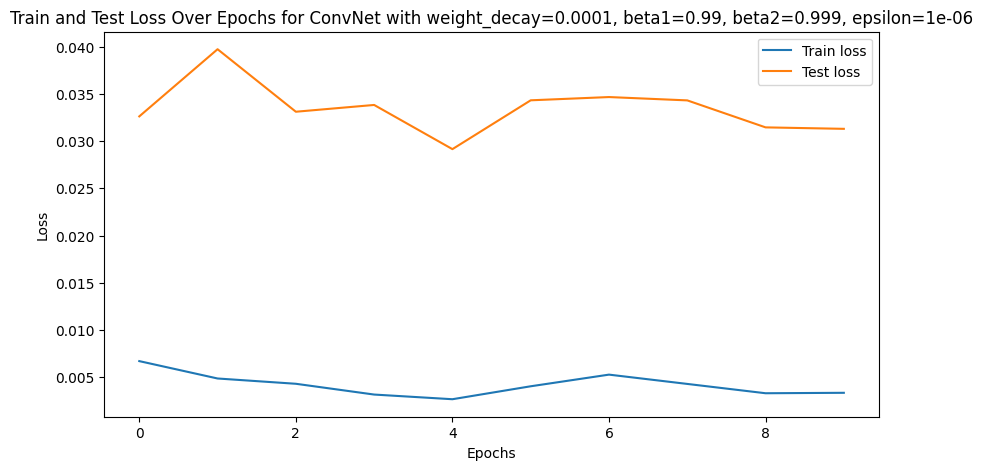

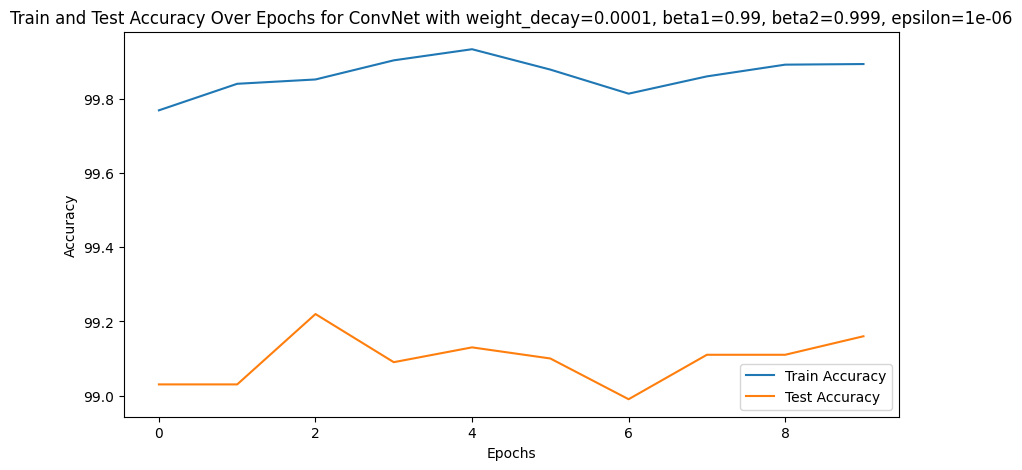

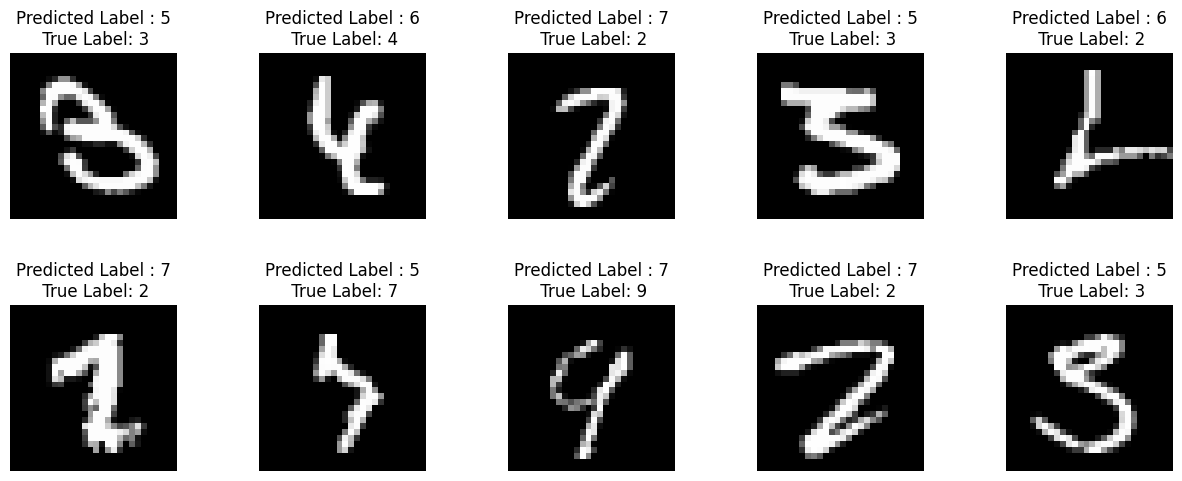

Training model: Logistic Regression with weight_decay=0.0001, beta1=0.99, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.2479, Train Acc: 93.12%, Test Loss: 0.2613, Test Acc: 92.56%
Epoch 2/10, Train Loss: 0.2459, Train Acc: 93.20%, Test Loss: 0.2606, Test Acc: 92.58%
Epoch 3/10, Train Loss: 0.2460, Train Acc: 93.26%, Test Loss: 0.2623, Test Acc: 92.54%
Epoch 4/10, Train Loss: 0.2456, Train Acc: 93.21%, Test Loss: 0.2634, Test Acc: 92.48%
Epoch 5/10, Train Loss: 0.2477, Train Acc: 93.16%, Test Loss: 0.2636, Test Acc: 92.55%
Epoch 6/10, Train Loss: 0.2459, Train Acc: 93.17%, Test Loss: 0.2597, Test Acc: 92.63%
Epoch 7/10, Train Loss: 0.2453, Train Acc: 93.24%, Test Loss: 0.2608, Test Acc: 92.65%
Epoch 8/10, Train Loss: 0.2455, Train Acc: 93.23%, Test Loss: 0.2608, Test Acc: 92.62%
Epoch 9/10, Train Loss: 0.2454, Train Acc: 93.27%, Test Loss: 0.2609, Test Acc: 92.55%
Epoch 10/10, Train Loss: 0.2459, Train Acc: 93.19%, Test Loss: 0.2616, Test Acc: 92.62%
Sensitivity Analysis: 9262 

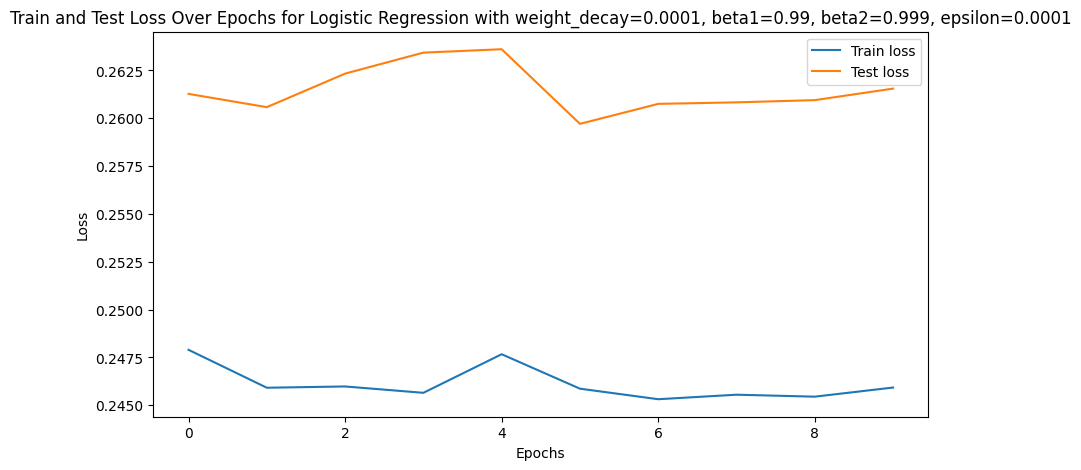

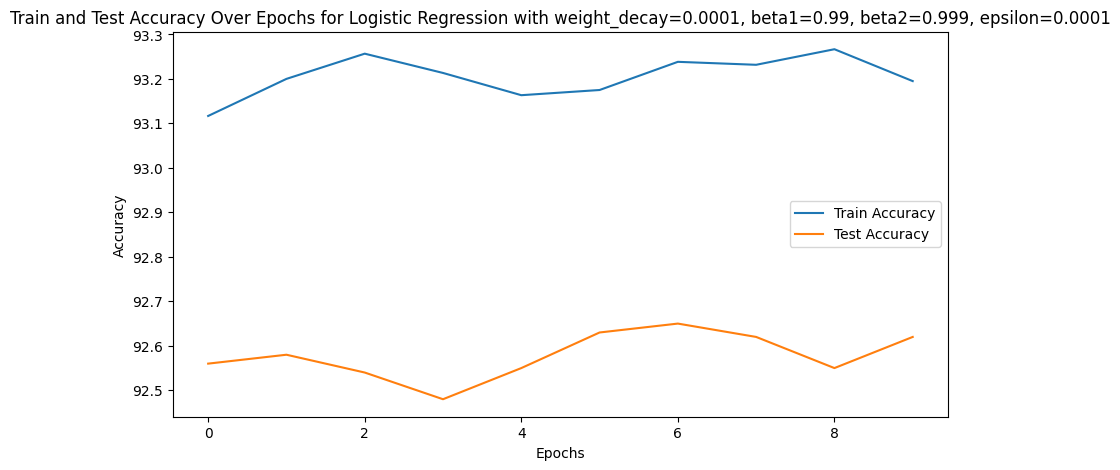

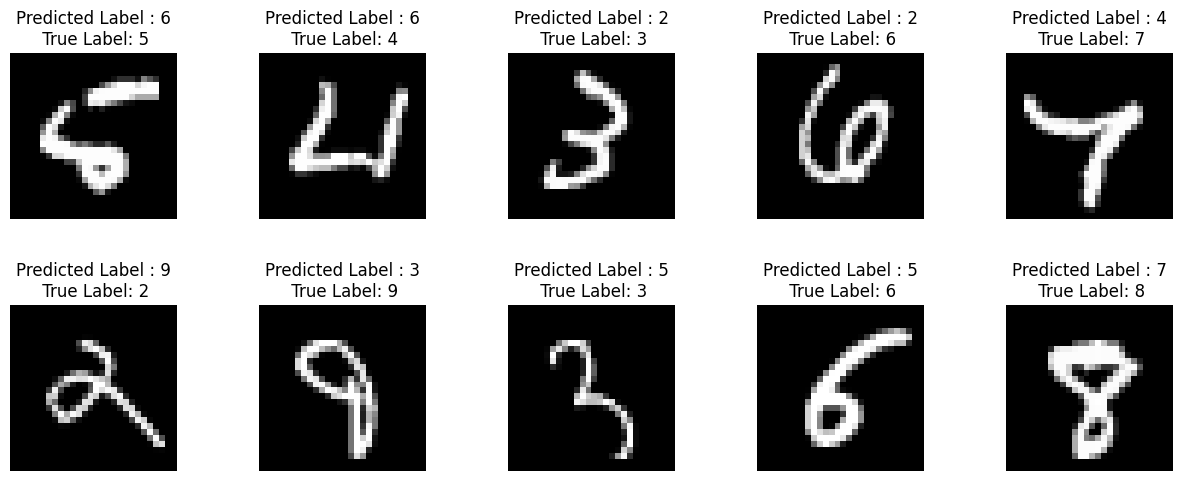

Training model: Multi Layer Network with weight_decay=0.0001, beta1=0.99, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0696, Train Acc: 97.86%, Test Loss: 0.0591, Test Acc: 98.37%
Epoch 2/10, Train Loss: 0.0636, Train Acc: 97.95%, Test Loss: 0.0567, Test Acc: 98.39%
Epoch 3/10, Train Loss: 0.0589, Train Acc: 98.04%, Test Loss: 0.0585, Test Acc: 98.27%
Epoch 4/10, Train Loss: 0.0608, Train Acc: 98.06%, Test Loss: 0.0595, Test Acc: 98.37%
Epoch 5/10, Train Loss: 0.0581, Train Acc: 98.11%, Test Loss: 0.0608, Test Acc: 98.30%
Epoch 6/10, Train Loss: 0.0614, Train Acc: 97.97%, Test Loss: 0.0571, Test Acc: 98.20%
Epoch 7/10, Train Loss: 0.0638, Train Acc: 97.96%, Test Loss: 0.0592, Test Acc: 98.34%
Epoch 8/10, Train Loss: 0.0623, Train Acc: 97.99%, Test Loss: 0.0611, Test Acc: 98.17%
Epoch 9/10, Train Loss: 0.0596, Train Acc: 98.08%, Test Loss: 0.0622, Test Acc: 98.32%
Epoch 10/10, Train Loss: 0.0601, Train Acc: 98.07%, Test Loss: 0.0601, Test Acc: 98.34%
Sensitivity Analysis: 9834 

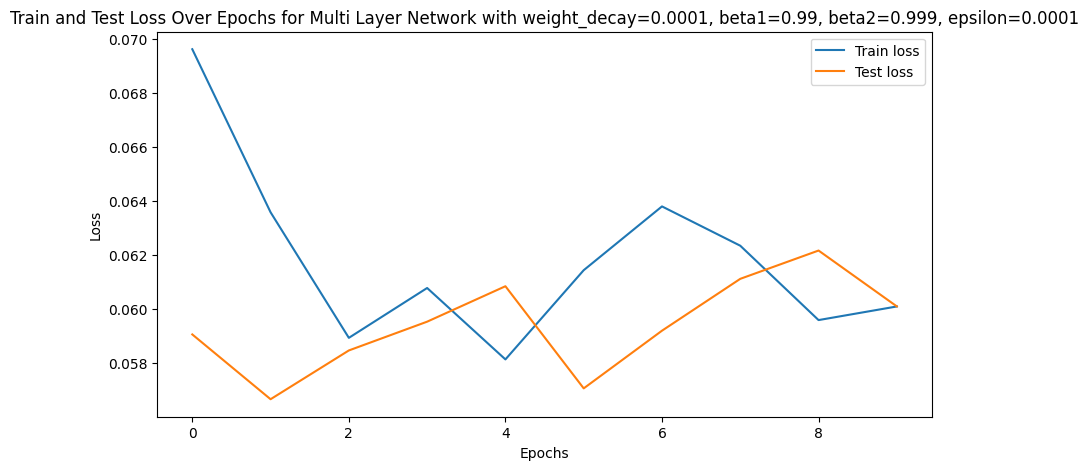

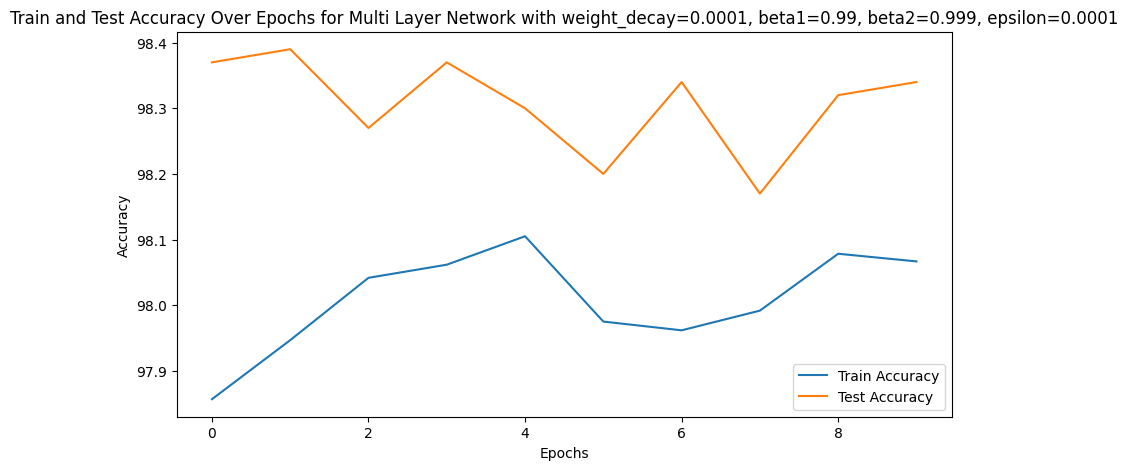

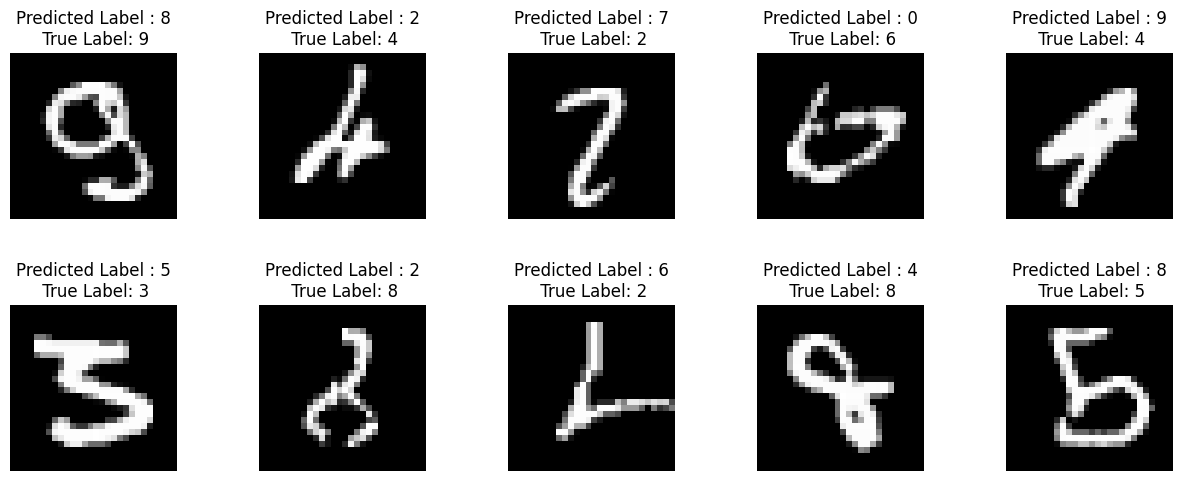

Training model: ConvNet with weight_decay=0.0001, beta1=0.99, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0045, Train Acc: 99.86%, Test Loss: 0.0350, Test Acc: 99.01%
Epoch 2/10, Train Loss: 0.0028, Train Acc: 99.92%, Test Loss: 0.0301, Test Acc: 99.21%
Epoch 3/10, Train Loss: 0.0027, Train Acc: 99.91%, Test Loss: 0.0304, Test Acc: 99.12%
Epoch 4/10, Train Loss: 0.0035, Train Acc: 99.91%, Test Loss: 0.0298, Test Acc: 99.16%
Epoch 5/10, Train Loss: 0.0033, Train Acc: 99.91%, Test Loss: 0.0317, Test Acc: 99.17%
Epoch 6/10, Train Loss: 0.0043, Train Acc: 99.88%, Test Loss: 0.0301, Test Acc: 99.13%
Epoch 7/10, Train Loss: 0.0035, Train Acc: 99.89%, Test Loss: 0.0435, Test Acc: 98.94%
Epoch 8/10, Train Loss: 0.0025, Train Acc: 99.93%, Test Loss: 0.0338, Test Acc: 99.10%
Epoch 9/10, Train Loss: 0.0019, Train Acc: 99.95%, Test Loss: 0.0352, Test Acc: 99.03%
Epoch 10/10, Train Loss: 0.0031, Train Acc: 99.91%, Test Loss: 0.0383, Test Acc: 99.02%
Sensitivity Analysis: 9902 correct and 

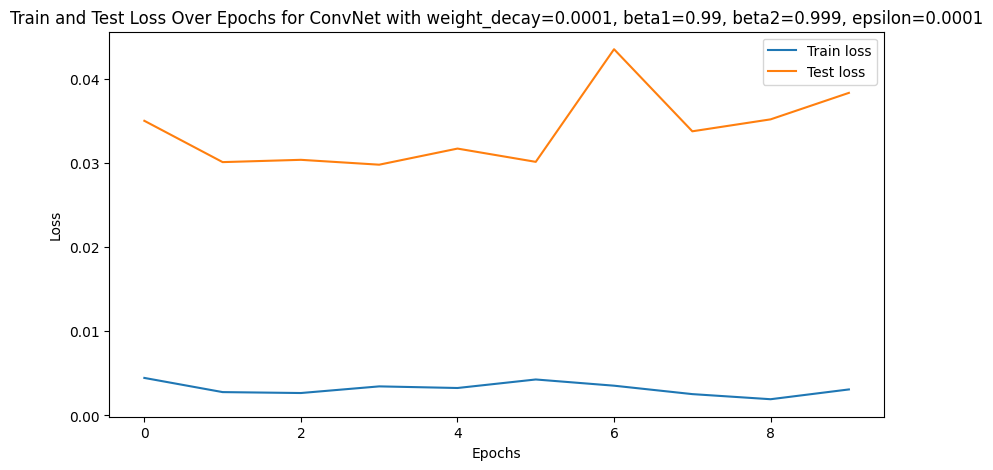

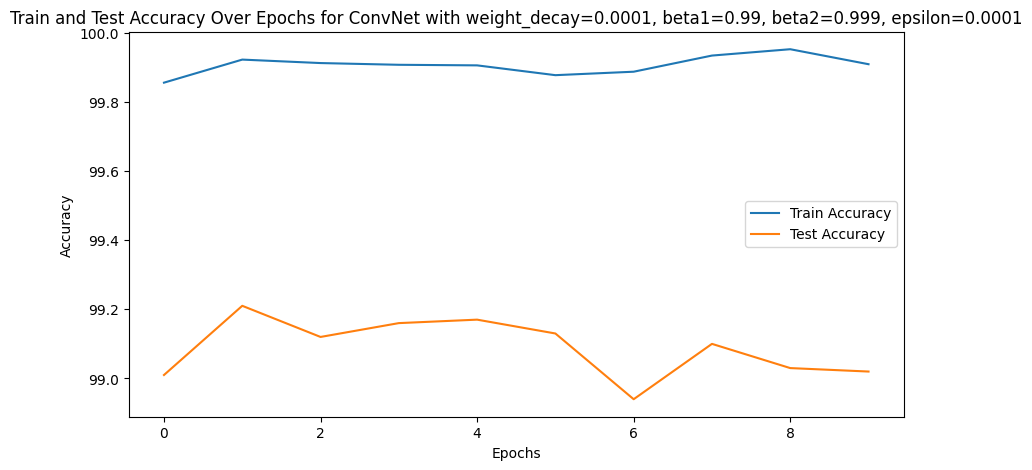

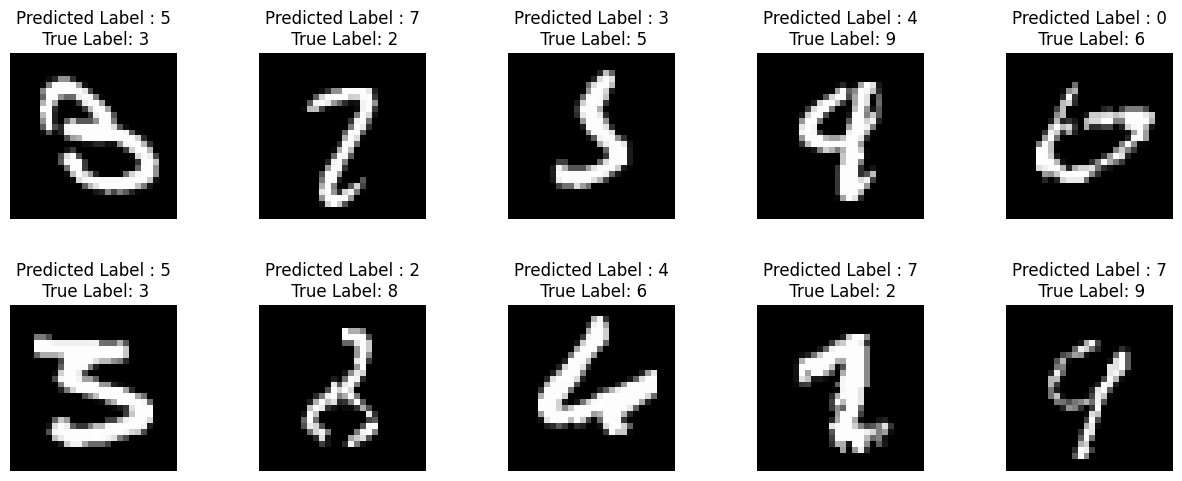

Training model: Logistic Regression with weight_decay=0.0001, beta1=0.99, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.2477, Train Acc: 93.16%, Test Loss: 0.2637, Test Acc: 92.55%
Epoch 2/10, Train Loss: 0.2459, Train Acc: 93.23%, Test Loss: 0.2610, Test Acc: 92.61%
Epoch 3/10, Train Loss: 0.2461, Train Acc: 93.22%, Test Loss: 0.2613, Test Acc: 92.56%
Epoch 4/10, Train Loss: 0.2461, Train Acc: 93.22%, Test Loss: 0.2622, Test Acc: 92.57%
Epoch 5/10, Train Loss: 0.2456, Train Acc: 93.17%, Test Loss: 0.2617, Test Acc: 92.63%
Epoch 6/10, Train Loss: 0.2457, Train Acc: 93.20%, Test Loss: 0.2609, Test Acc: 92.63%
Epoch 7/10, Train Loss: 0.2457, Train Acc: 93.22%, Test Loss: 0.2626, Test Acc: 92.60%
Epoch 8/10, Train Loss: 0.2459, Train Acc: 93.24%, Test Loss: 0.2622, Test Acc: 92.55%
Epoch 9/10, Train Loss: 0.2451, Train Acc: 93.25%, Test Loss: 0.2639, Test Acc: 92.59%
Epoch 10/10, Train Loss: 0.2454, Train Acc: 93.19%, Test Loss: 0.2631, Test Acc: 92.64%
Sensitivity Analysis: 9264 

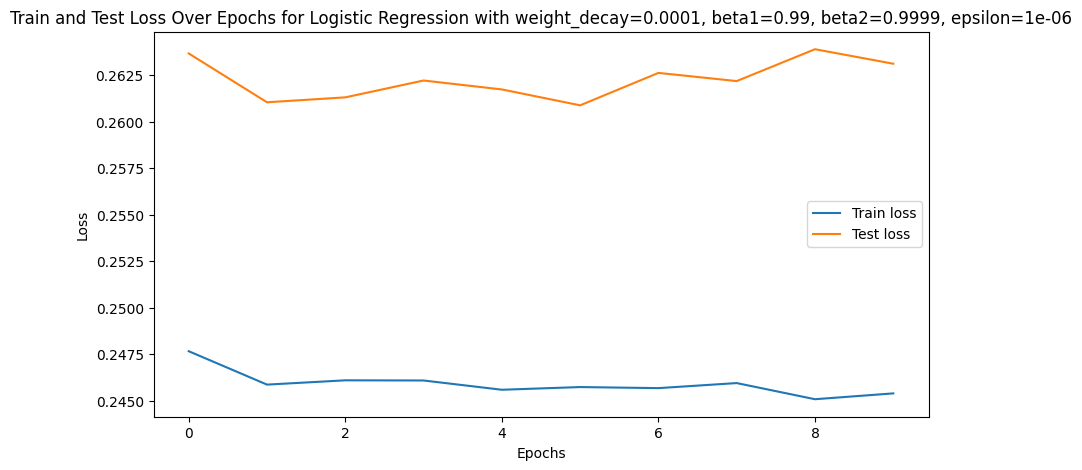

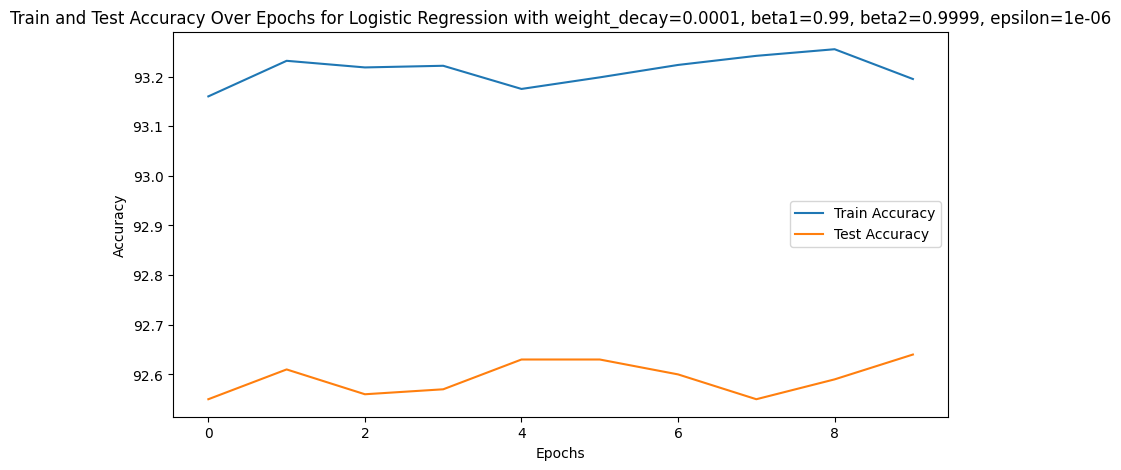

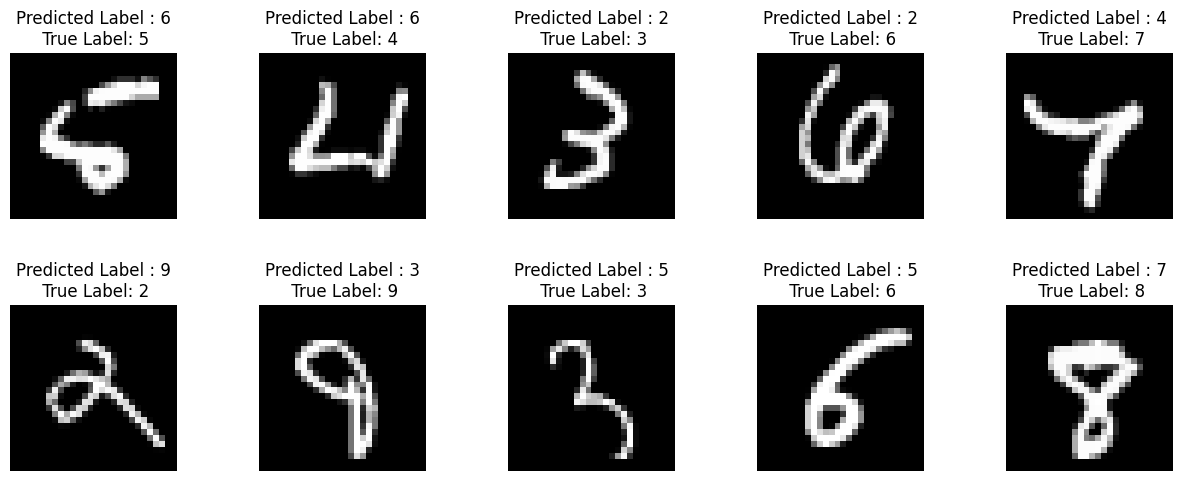

Training model: Multi Layer Network with weight_decay=0.0001, beta1=0.99, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0746, Train Acc: 97.55%, Test Loss: 0.0641, Test Acc: 98.23%
Epoch 2/10, Train Loss: 0.0641, Train Acc: 97.99%, Test Loss: 0.0589, Test Acc: 98.29%
Epoch 3/10, Train Loss: 0.0618, Train Acc: 97.97%, Test Loss: 0.0632, Test Acc: 98.24%
Epoch 4/10, Train Loss: 0.0653, Train Acc: 97.88%, Test Loss: 0.0581, Test Acc: 98.30%
Epoch 5/10, Train Loss: 0.0615, Train Acc: 97.96%, Test Loss: 0.0578, Test Acc: 98.29%
Epoch 6/10, Train Loss: 0.0592, Train Acc: 98.06%, Test Loss: 0.0602, Test Acc: 98.26%
Epoch 7/10, Train Loss: 0.0604, Train Acc: 98.06%, Test Loss: 0.0590, Test Acc: 98.35%
Epoch 8/10, Train Loss: 0.0618, Train Acc: 98.01%, Test Loss: 0.0671, Test Acc: 98.25%
Epoch 9/10, Train Loss: 0.0622, Train Acc: 97.99%, Test Loss: 0.0636, Test Acc: 98.14%
Epoch 10/10, Train Loss: 0.0619, Train Acc: 98.03%, Test Loss: 0.0629, Test Acc: 98.07%
Sensitivity Analysis: 9807 

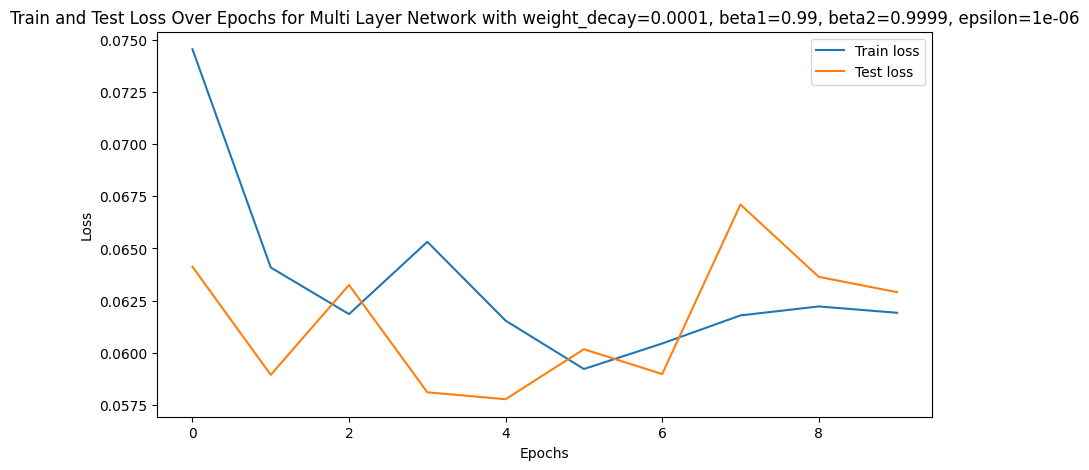

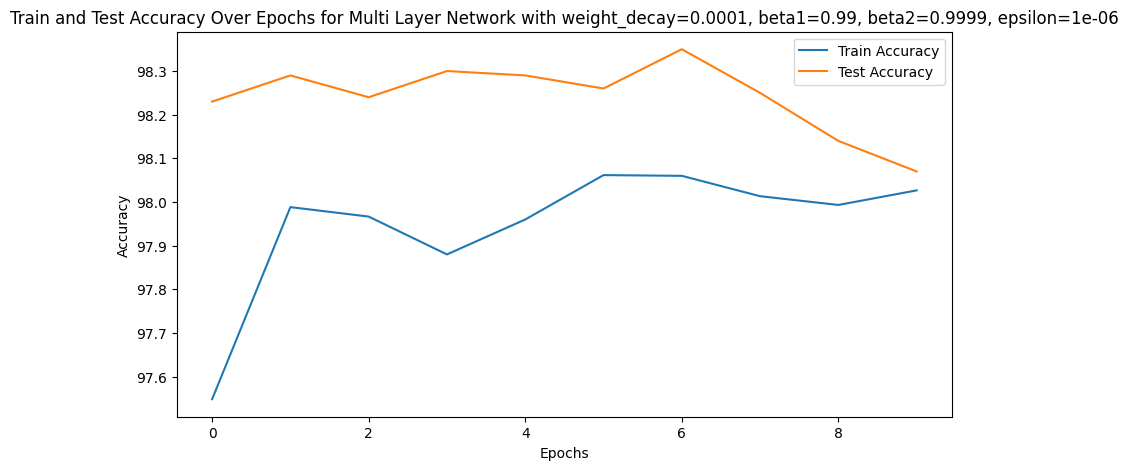

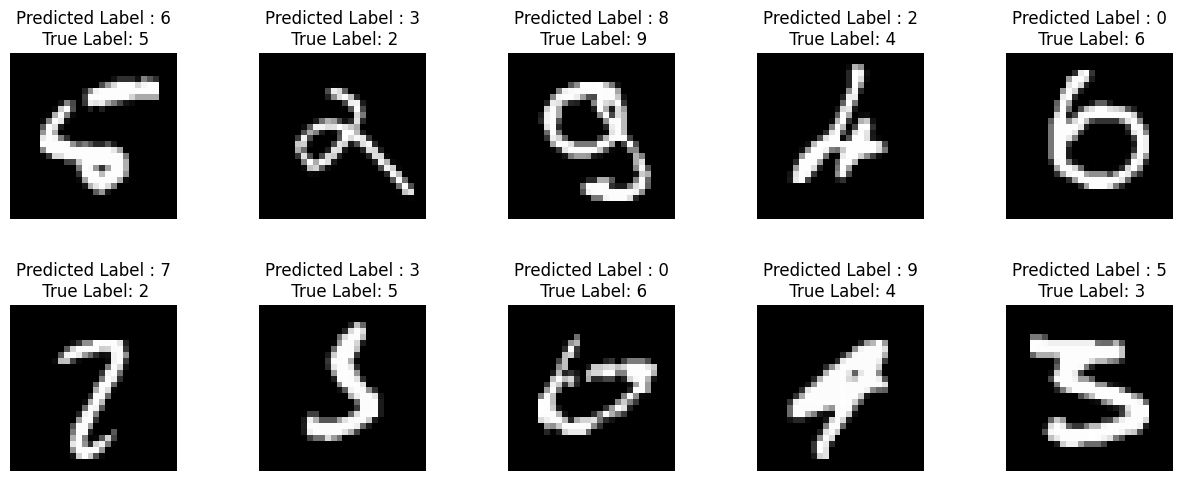

Training model: ConvNet with weight_decay=0.0001, beta1=0.99, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0067, Train Acc: 99.76%, Test Loss: 0.0308, Test Acc: 99.13%
Epoch 2/10, Train Loss: 0.0030, Train Acc: 99.91%, Test Loss: 0.0296, Test Acc: 99.12%
Epoch 3/10, Train Loss: 0.0020, Train Acc: 99.95%, Test Loss: 0.0356, Test Acc: 99.04%
Epoch 4/10, Train Loss: 0.0034, Train Acc: 99.89%, Test Loss: 0.0298, Test Acc: 99.12%
Epoch 5/10, Train Loss: 0.0038, Train Acc: 99.89%, Test Loss: 0.0350, Test Acc: 99.05%
Epoch 6/10, Train Loss: 0.0042, Train Acc: 99.87%, Test Loss: 0.0424, Test Acc: 98.87%
Epoch 7/10, Train Loss: 0.0050, Train Acc: 99.83%, Test Loss: 0.0357, Test Acc: 99.15%
Epoch 8/10, Train Loss: 0.0036, Train Acc: 99.91%, Test Loss: 0.0309, Test Acc: 99.09%
Epoch 9/10, Train Loss: 0.0021, Train Acc: 99.94%, Test Loss: 0.0288, Test Acc: 99.21%
Epoch 10/10, Train Loss: 0.0009, Train Acc: 99.99%, Test Loss: 0.0325, Test Acc: 99.14%
Sensitivity Analysis: 9914 correct and 

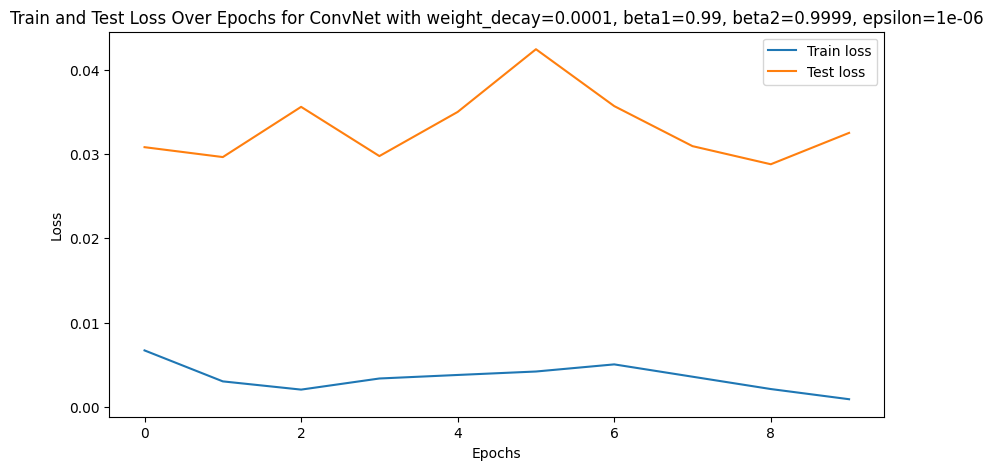

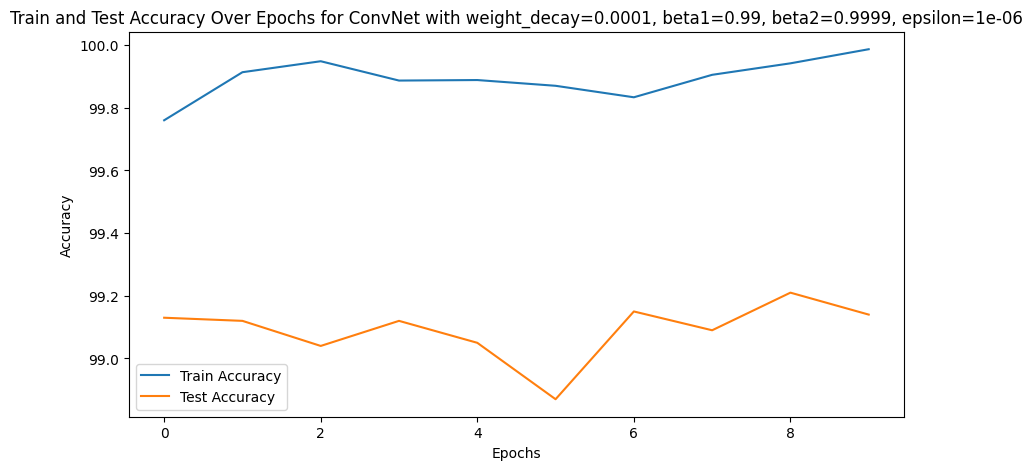

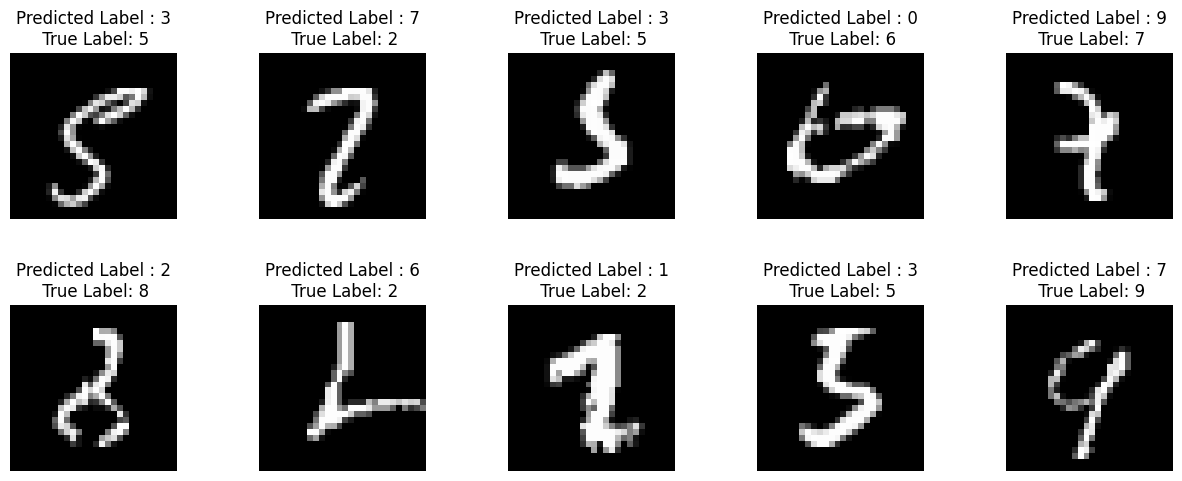

Training model: Logistic Regression with weight_decay=0.0001, beta1=0.99, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.2465, Train Acc: 93.21%, Test Loss: 0.2633, Test Acc: 92.59%
Epoch 2/10, Train Loss: 0.2448, Train Acc: 93.31%, Test Loss: 0.2636, Test Acc: 92.54%
Epoch 3/10, Train Loss: 0.2454, Train Acc: 93.19%, Test Loss: 0.2636, Test Acc: 92.57%
Epoch 4/10, Train Loss: 0.2452, Train Acc: 93.23%, Test Loss: 0.2635, Test Acc: 92.56%
Epoch 5/10, Train Loss: 0.2454, Train Acc: 93.25%, Test Loss: 0.2616, Test Acc: 92.64%
Epoch 6/10, Train Loss: 0.2452, Train Acc: 93.18%, Test Loss: 0.2609, Test Acc: 92.63%
Epoch 7/10, Train Loss: 0.2449, Train Acc: 93.25%, Test Loss: 0.2613, Test Acc: 92.74%
Epoch 8/10, Train Loss: 0.2448, Train Acc: 93.26%, Test Loss: 0.2621, Test Acc: 92.51%
Epoch 9/10, Train Loss: 0.2444, Train Acc: 93.18%, Test Loss: 0.2625, Test Acc: 92.55%
Epoch 10/10, Train Loss: 0.2448, Train Acc: 93.23%, Test Loss: 0.2625, Test Acc: 92.62%
Sensitivity Analysis: 9262

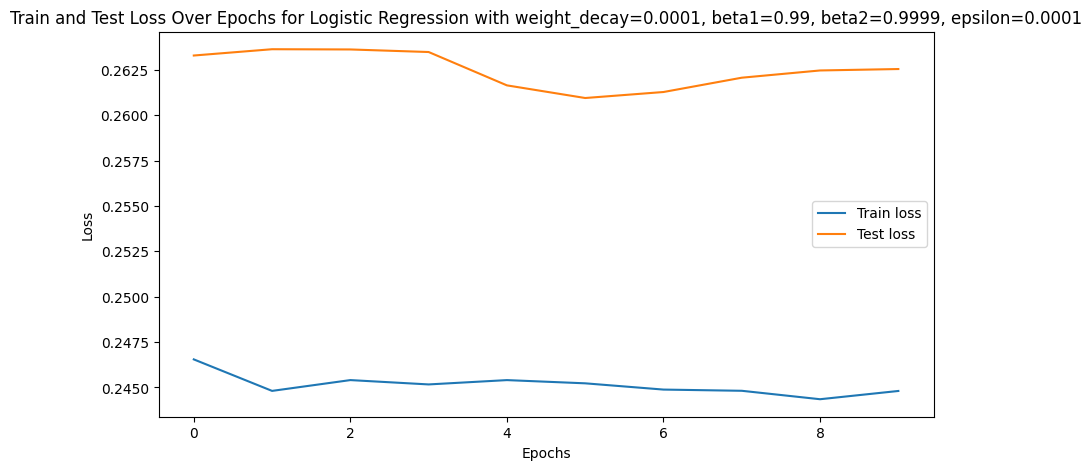

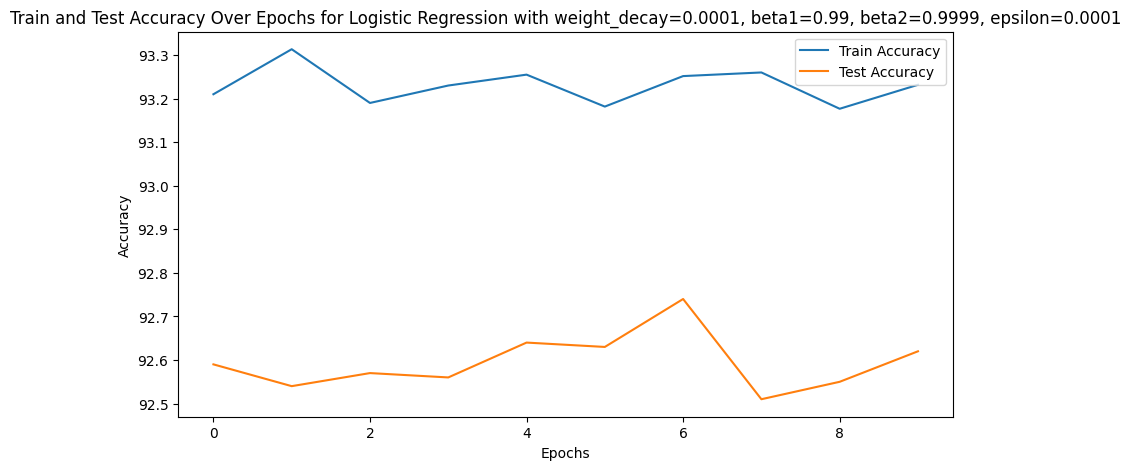

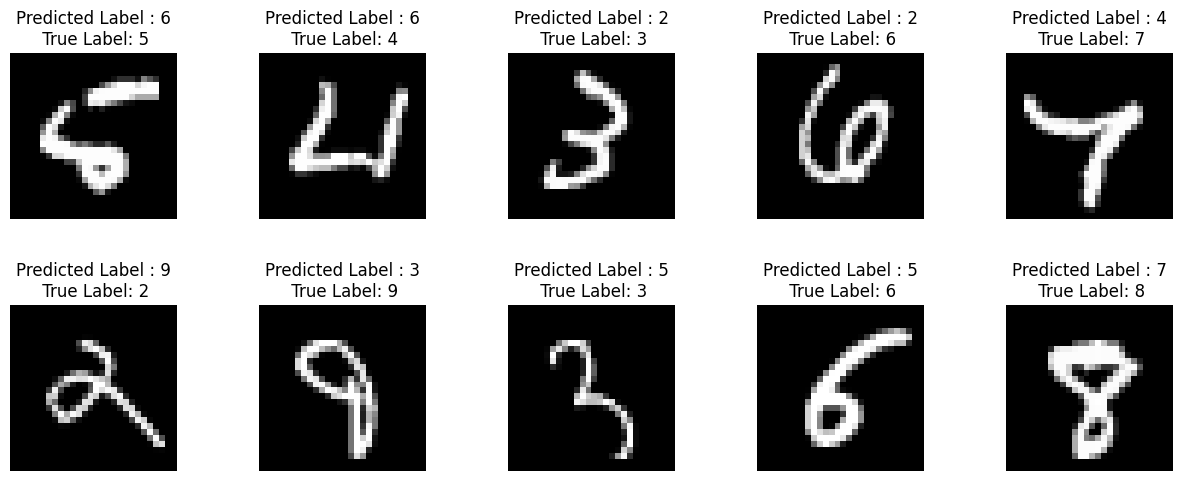

Training model: Multi Layer Network with weight_decay=0.0001, beta1=0.99, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0663, Train Acc: 97.92%, Test Loss: 0.0621, Test Acc: 98.28%
Epoch 2/10, Train Loss: 0.0610, Train Acc: 98.01%, Test Loss: 0.0633, Test Acc: 98.17%
Epoch 3/10, Train Loss: 0.0569, Train Acc: 98.17%, Test Loss: 0.0597, Test Acc: 98.32%
Epoch 4/10, Train Loss: 0.0583, Train Acc: 98.08%, Test Loss: 0.0613, Test Acc: 98.23%
Epoch 5/10, Train Loss: 0.0613, Train Acc: 98.02%, Test Loss: 0.0589, Test Acc: 98.31%
Epoch 6/10, Train Loss: 0.0563, Train Acc: 98.20%, Test Loss: 0.0581, Test Acc: 98.23%
Epoch 7/10, Train Loss: 0.0590, Train Acc: 98.09%, Test Loss: 0.0593, Test Acc: 98.35%
Epoch 8/10, Train Loss: 0.0584, Train Acc: 98.08%, Test Loss: 0.0626, Test Acc: 98.26%
Epoch 9/10, Train Loss: 0.0594, Train Acc: 98.11%, Test Loss: 0.0616, Test Acc: 98.20%
Epoch 10/10, Train Loss: 0.0574, Train Acc: 98.12%, Test Loss: 0.0589, Test Acc: 98.39%
Sensitivity Analysis: 9839

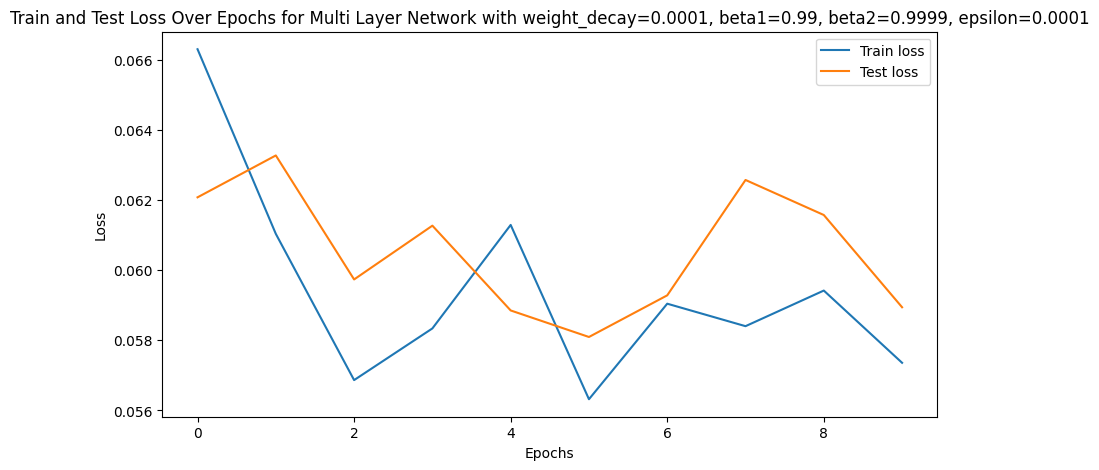

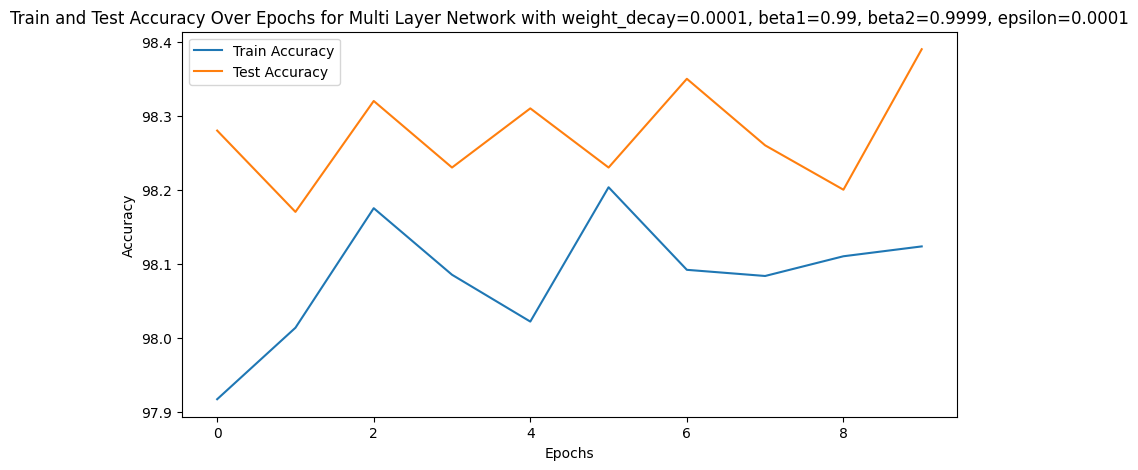

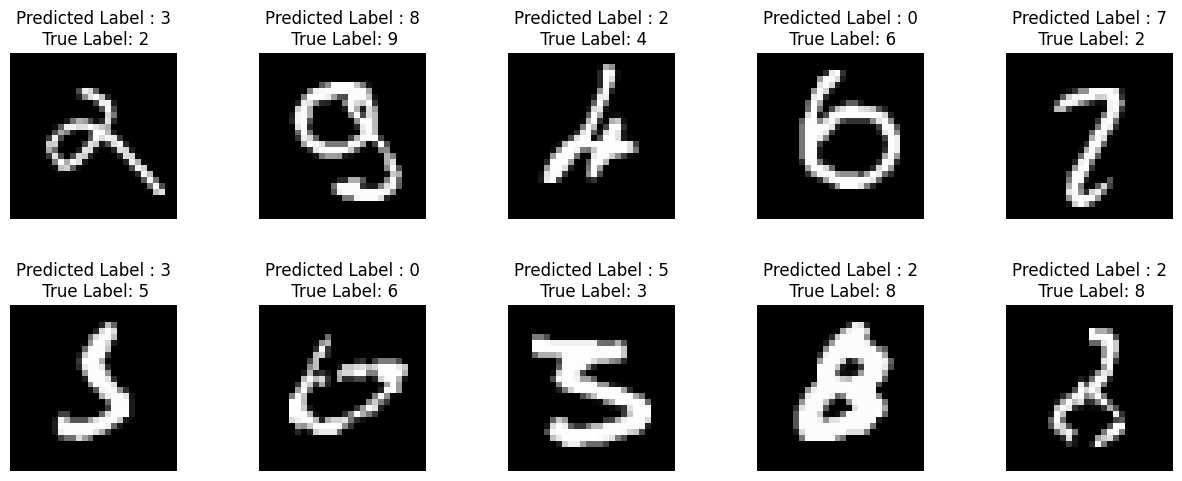

Training model: ConvNet with weight_decay=0.0001, beta1=0.99, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0032, Train Acc: 99.90%, Test Loss: 0.0339, Test Acc: 99.07%
Epoch 2/10, Train Loss: 0.0023, Train Acc: 99.95%, Test Loss: 0.0334, Test Acc: 99.15%
Epoch 3/10, Train Loss: 0.0020, Train Acc: 99.96%, Test Loss: 0.0407, Test Acc: 98.98%
Epoch 4/10, Train Loss: 0.0030, Train Acc: 99.92%, Test Loss: 0.0320, Test Acc: 99.15%
Epoch 5/10, Train Loss: 0.0039, Train Acc: 99.88%, Test Loss: 0.0385, Test Acc: 99.02%
Epoch 6/10, Train Loss: 0.0053, Train Acc: 99.80%, Test Loss: 0.0352, Test Acc: 98.94%
Epoch 7/10, Train Loss: 0.0040, Train Acc: 99.88%, Test Loss: 0.0384, Test Acc: 99.05%
Epoch 8/10, Train Loss: 0.0023, Train Acc: 99.93%, Test Loss: 0.0330, Test Acc: 99.22%
Epoch 9/10, Train Loss: 0.0014, Train Acc: 99.96%, Test Loss: 0.0287, Test Acc: 99.22%
Epoch 10/10, Train Loss: 0.0007, Train Acc: 100.00%, Test Loss: 0.0295, Test Acc: 99.14%
Sensitivity Analysis: 9914 correct an

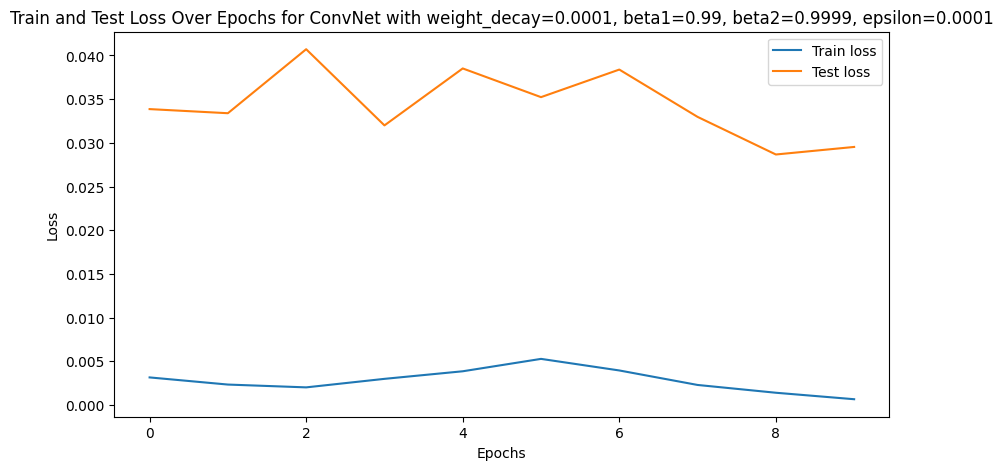

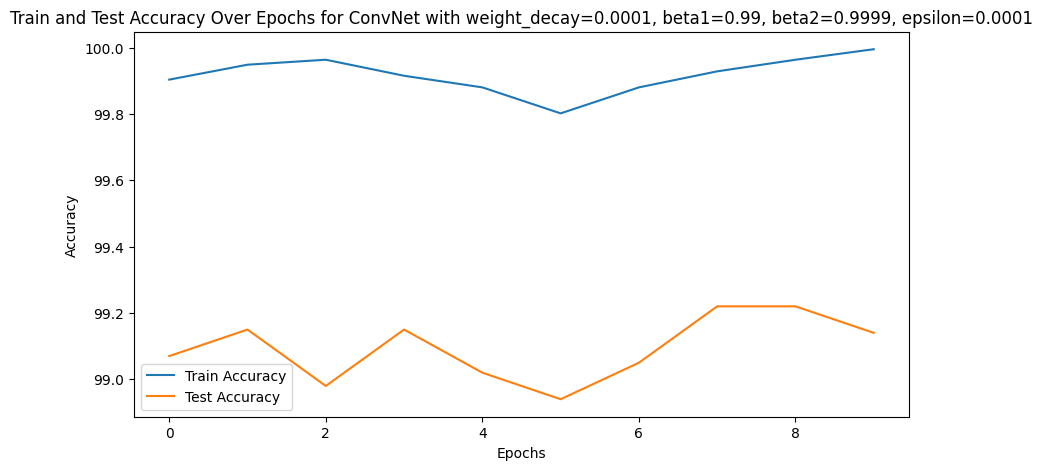

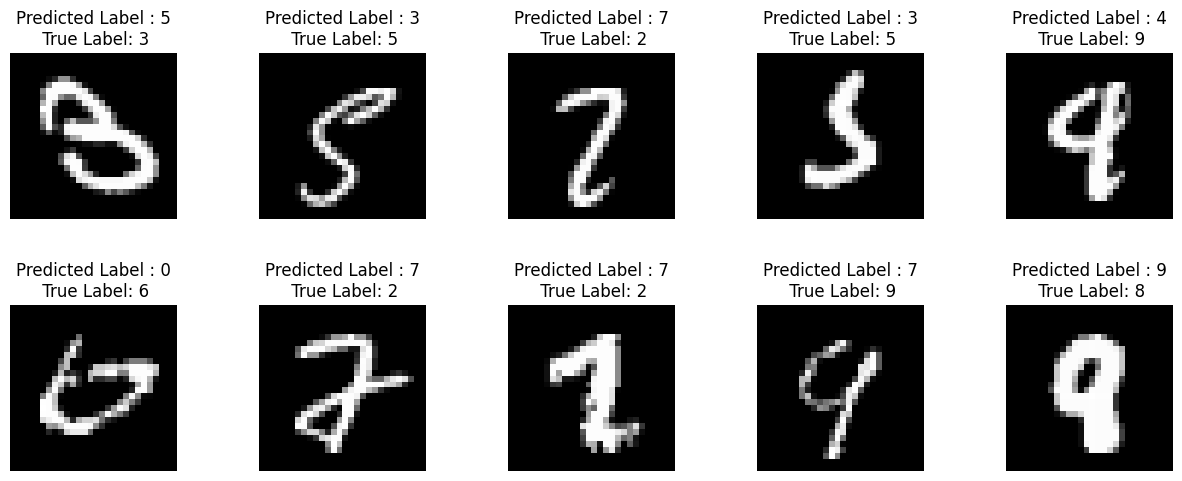

Training model: Logistic Regression with weight_decay=0.001, beta1=0.9, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.2522, Train Acc: 93.06%, Test Loss: 0.2668, Test Acc: 92.41%
Epoch 2/10, Train Loss: 0.2623, Train Acc: 92.82%, Test Loss: 0.2716, Test Acc: 92.31%
Epoch 3/10, Train Loss: 0.2692, Train Acc: 92.62%, Test Loss: 0.2769, Test Acc: 92.06%
Epoch 4/10, Train Loss: 0.2739, Train Acc: 92.50%, Test Loss: 0.2795, Test Acc: 91.99%
Epoch 5/10, Train Loss: 0.2779, Train Acc: 92.41%, Test Loss: 0.2781, Test Acc: 92.06%
Epoch 6/10, Train Loss: 0.2799, Train Acc: 92.33%, Test Loss: 0.2797, Test Acc: 92.04%
Epoch 7/10, Train Loss: 0.2816, Train Acc: 92.30%, Test Loss: 0.2786, Test Acc: 92.05%
Epoch 8/10, Train Loss: 0.2828, Train Acc: 92.27%, Test Loss: 0.2810, Test Acc: 92.00%
Epoch 9/10, Train Loss: 0.2839, Train Acc: 92.25%, Test Loss: 0.2804, Test Acc: 92.03%
Epoch 10/10, Train Loss: 0.2850, Train Acc: 92.22%, Test Loss: 0.2835, Test Acc: 91.94%
Sensitivity Analysis: 9194 cor

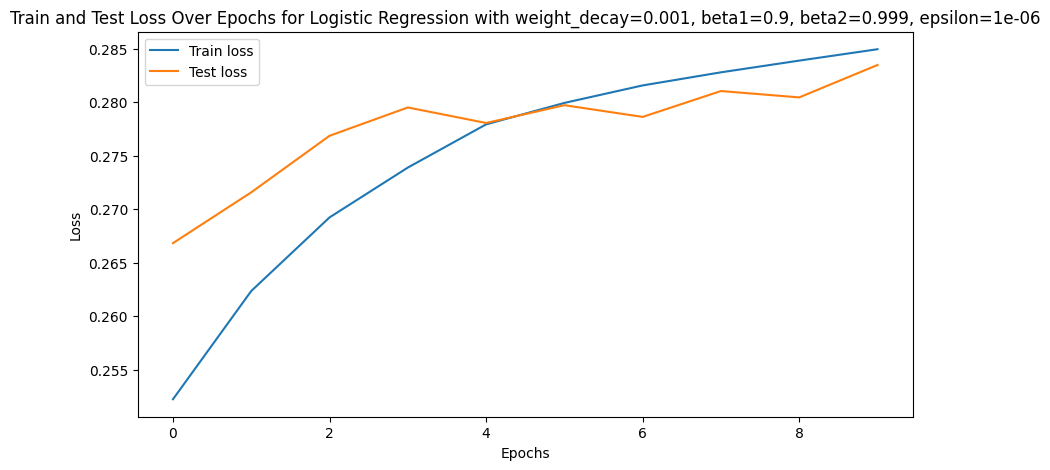

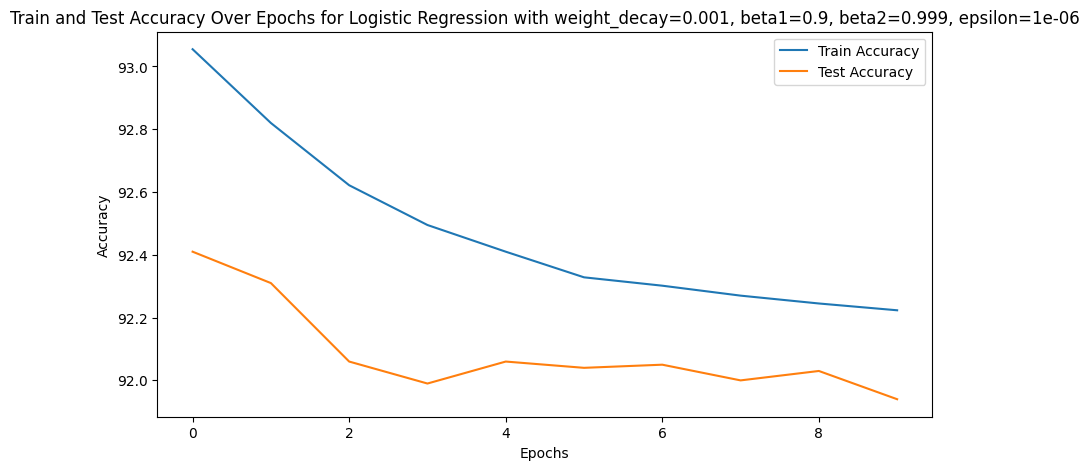

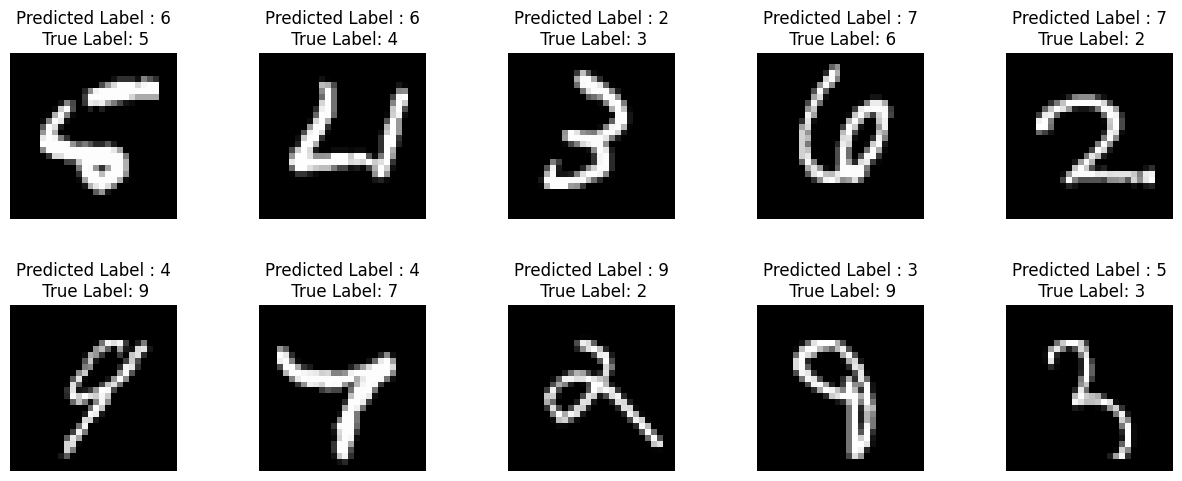

Training model: Multi Layer Network with weight_decay=0.001, beta1=0.9, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0789, Train Acc: 97.57%, Test Loss: 0.0636, Test Acc: 98.10%
Epoch 2/10, Train Loss: 0.0938, Train Acc: 97.16%, Test Loss: 0.0634, Test Acc: 97.88%
Epoch 3/10, Train Loss: 0.1046, Train Acc: 96.96%, Test Loss: 0.0702, Test Acc: 97.80%
Epoch 4/10, Train Loss: 0.1124, Train Acc: 96.60%, Test Loss: 0.0738, Test Acc: 97.76%
Epoch 5/10, Train Loss: 0.1174, Train Acc: 96.48%, Test Loss: 0.0726, Test Acc: 97.83%
Epoch 6/10, Train Loss: 0.1168, Train Acc: 96.56%, Test Loss: 0.0705, Test Acc: 97.78%
Epoch 7/10, Train Loss: 0.1186, Train Acc: 96.41%, Test Loss: 0.0687, Test Acc: 97.75%
Epoch 8/10, Train Loss: 0.1171, Train Acc: 96.59%, Test Loss: 0.0708, Test Acc: 97.68%
Epoch 9/10, Train Loss: 0.1193, Train Acc: 96.38%, Test Loss: 0.0753, Test Acc: 97.73%
Epoch 10/10, Train Loss: 0.1182, Train Acc: 96.41%, Test Loss: 0.0742, Test Acc: 97.67%
Sensitivity Analysis: 9767 cor

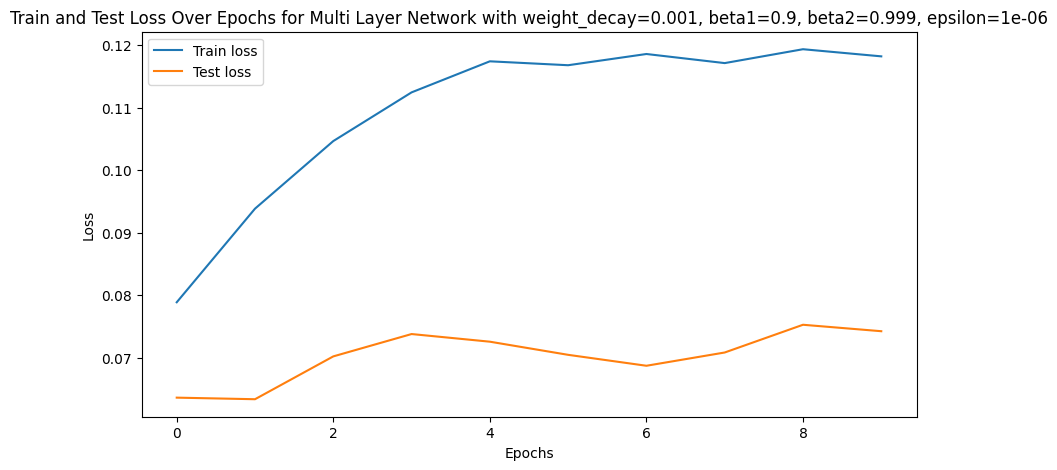

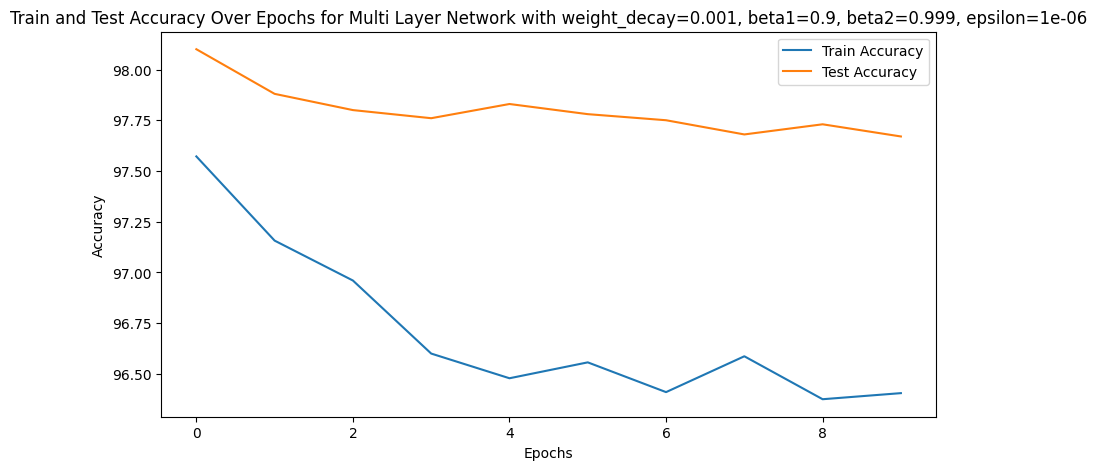

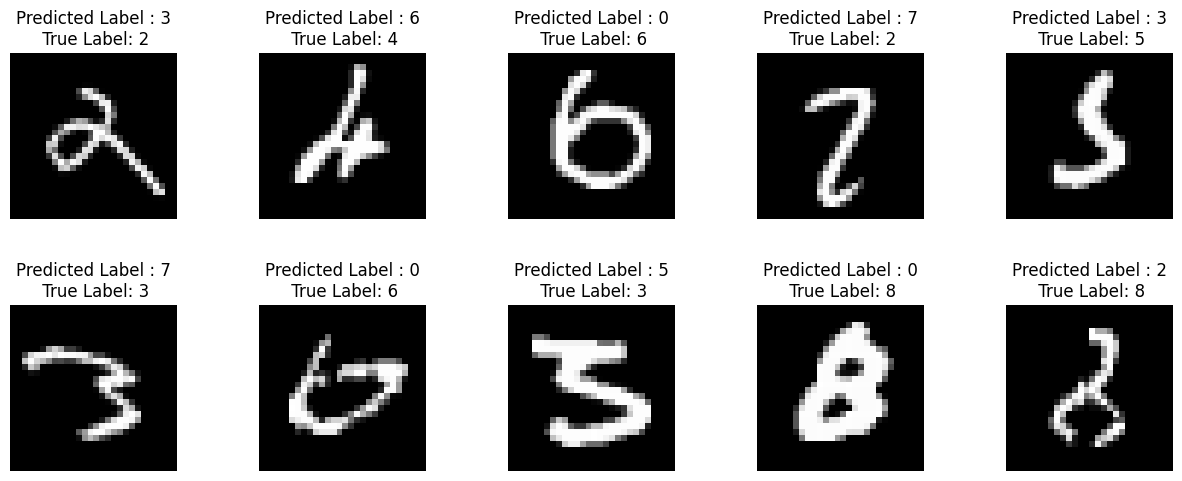

Training model: ConvNet with weight_decay=0.001, beta1=0.9, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0103, Train Acc: 99.68%, Test Loss: 0.0281, Test Acc: 99.04%
Epoch 2/10, Train Loss: 0.0119, Train Acc: 99.67%, Test Loss: 0.0324, Test Acc: 99.00%
Epoch 3/10, Train Loss: 0.0130, Train Acc: 99.63%, Test Loss: 0.0298, Test Acc: 99.06%
Epoch 4/10, Train Loss: 0.0147, Train Acc: 99.56%, Test Loss: 0.0347, Test Acc: 98.97%
Epoch 5/10, Train Loss: 0.0140, Train Acc: 99.62%, Test Loss: 0.0318, Test Acc: 99.02%
Epoch 6/10, Train Loss: 0.0143, Train Acc: 99.60%, Test Loss: 0.0326, Test Acc: 98.92%
Epoch 7/10, Train Loss: 0.0149, Train Acc: 99.55%, Test Loss: 0.0317, Test Acc: 98.99%
Epoch 8/10, Train Loss: 0.0147, Train Acc: 99.60%, Test Loss: 0.0352, Test Acc: 98.81%
Epoch 9/10, Train Loss: 0.0137, Train Acc: 99.63%, Test Loss: 0.0250, Test Acc: 99.24%
Epoch 10/10, Train Loss: 0.0145, Train Acc: 99.62%, Test Loss: 0.0283, Test Acc: 98.97%
Sensitivity Analysis: 9897 correct and 103

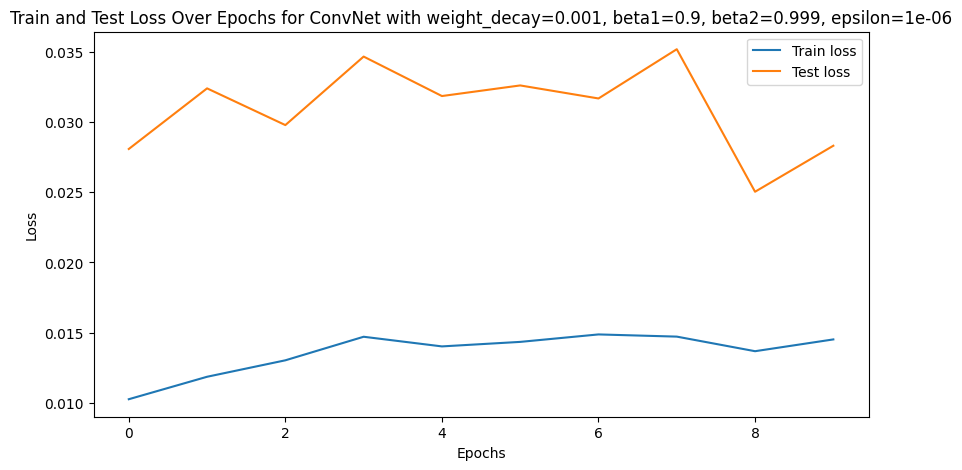

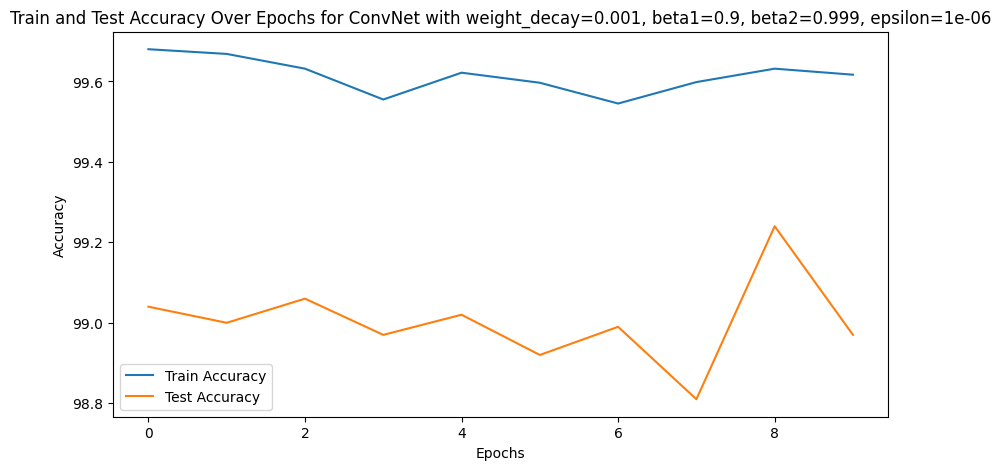

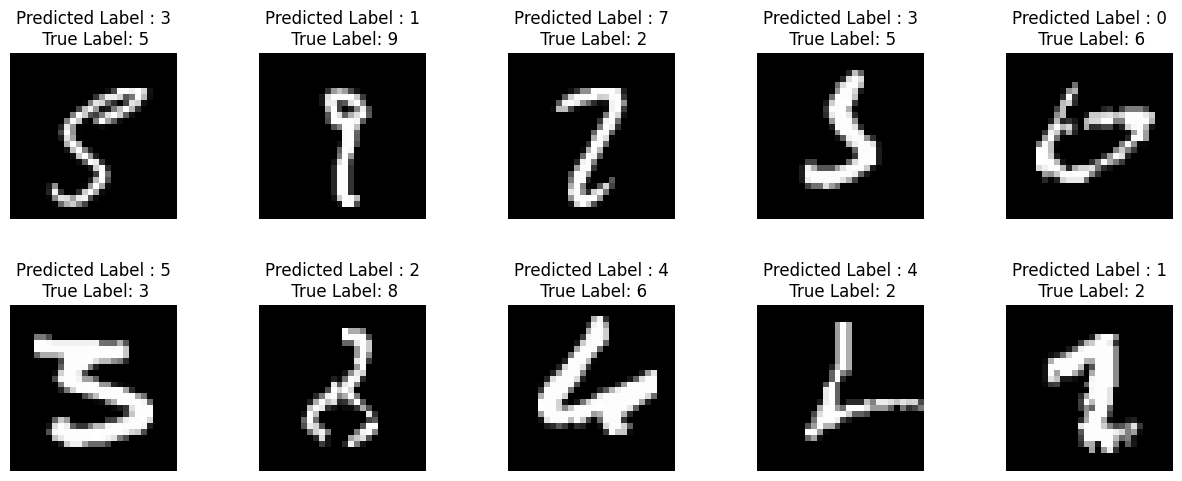

Training model: Logistic Regression with weight_decay=0.001, beta1=0.9, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.2859, Train Acc: 92.18%, Test Loss: 0.2810, Test Acc: 92.10%
Epoch 2/10, Train Loss: 0.2864, Train Acc: 92.14%, Test Loss: 0.2831, Test Acc: 92.11%
Epoch 3/10, Train Loss: 0.2866, Train Acc: 92.14%, Test Loss: 0.2834, Test Acc: 92.10%
Epoch 4/10, Train Loss: 0.2870, Train Acc: 92.14%, Test Loss: 0.2832, Test Acc: 92.07%
Epoch 5/10, Train Loss: 0.2873, Train Acc: 92.17%, Test Loss: 0.2826, Test Acc: 92.15%
Epoch 6/10, Train Loss: 0.2876, Train Acc: 92.12%, Test Loss: 0.2819, Test Acc: 92.10%
Epoch 7/10, Train Loss: 0.2878, Train Acc: 92.09%, Test Loss: 0.2822, Test Acc: 92.25%
Epoch 8/10, Train Loss: 0.2876, Train Acc: 92.11%, Test Loss: 0.2804, Test Acc: 92.12%
Epoch 9/10, Train Loss: 0.2882, Train Acc: 92.09%, Test Loss: 0.2828, Test Acc: 92.15%
Epoch 10/10, Train Loss: 0.2883, Train Acc: 92.14%, Test Loss: 0.2810, Test Acc: 92.19%
Sensitivity Analysis: 9219 co

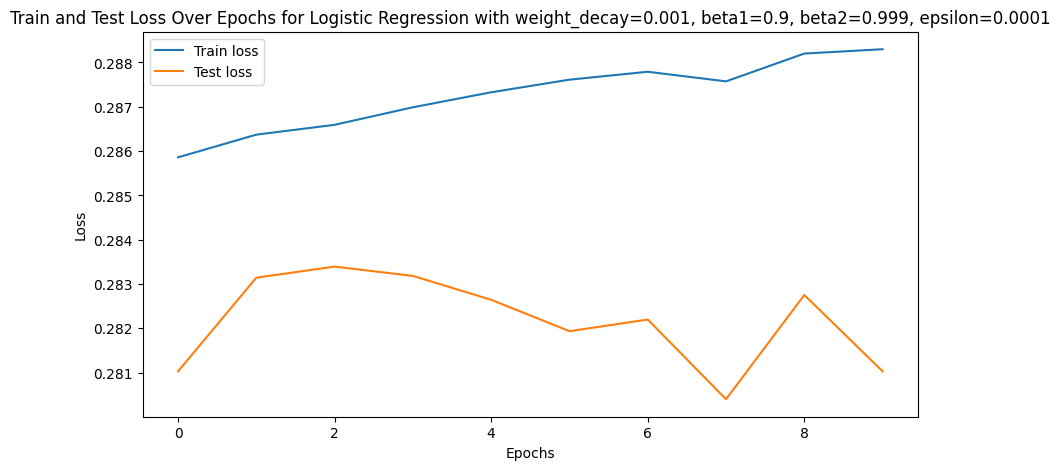

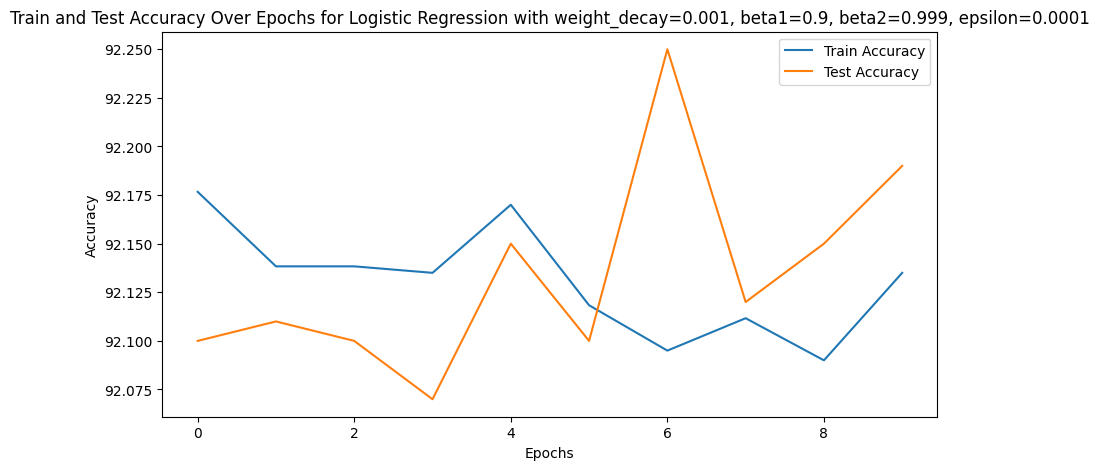

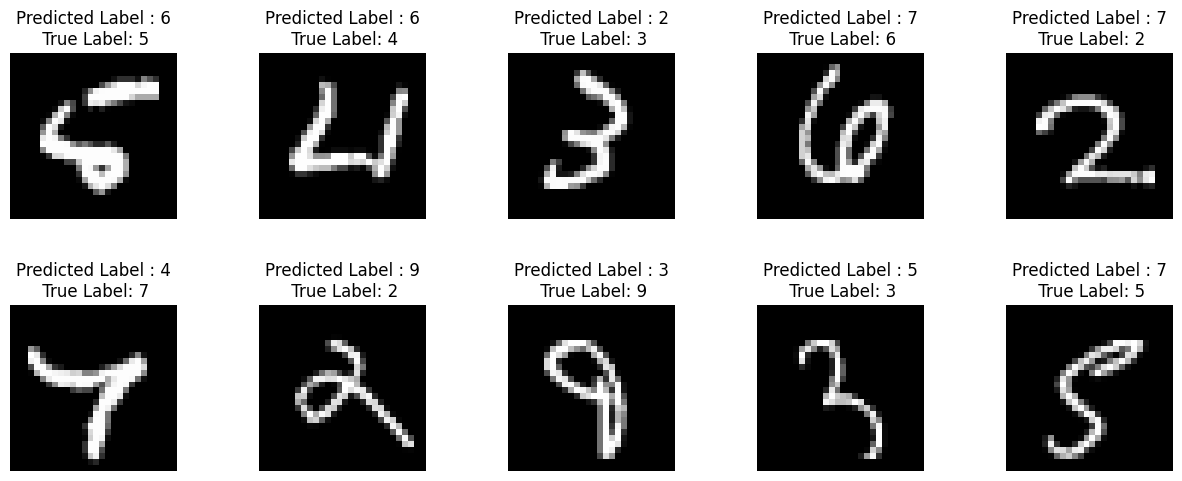

Training model: Multi Layer Network with weight_decay=0.001, beta1=0.9, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.1193, Train Acc: 96.48%, Test Loss: 0.0782, Test Acc: 97.55%
Epoch 2/10, Train Loss: 0.1204, Train Acc: 96.36%, Test Loss: 0.0738, Test Acc: 97.63%
Epoch 3/10, Train Loss: 0.1192, Train Acc: 96.39%, Test Loss: 0.0768, Test Acc: 97.50%
Epoch 4/10, Train Loss: 0.1201, Train Acc: 96.38%, Test Loss: 0.0716, Test Acc: 97.89%
Epoch 5/10, Train Loss: 0.1200, Train Acc: 96.39%, Test Loss: 0.0740, Test Acc: 97.68%
Epoch 6/10, Train Loss: 0.1196, Train Acc: 96.44%, Test Loss: 0.0765, Test Acc: 97.66%
Epoch 7/10, Train Loss: 0.1187, Train Acc: 96.47%, Test Loss: 0.0710, Test Acc: 97.66%
Epoch 8/10, Train Loss: 0.1213, Train Acc: 96.37%, Test Loss: 0.0715, Test Acc: 97.76%
Epoch 9/10, Train Loss: 0.1190, Train Acc: 96.41%, Test Loss: 0.0724, Test Acc: 97.71%
Epoch 10/10, Train Loss: 0.1197, Train Acc: 96.46%, Test Loss: 0.0748, Test Acc: 97.63%
Sensitivity Analysis: 9763 co

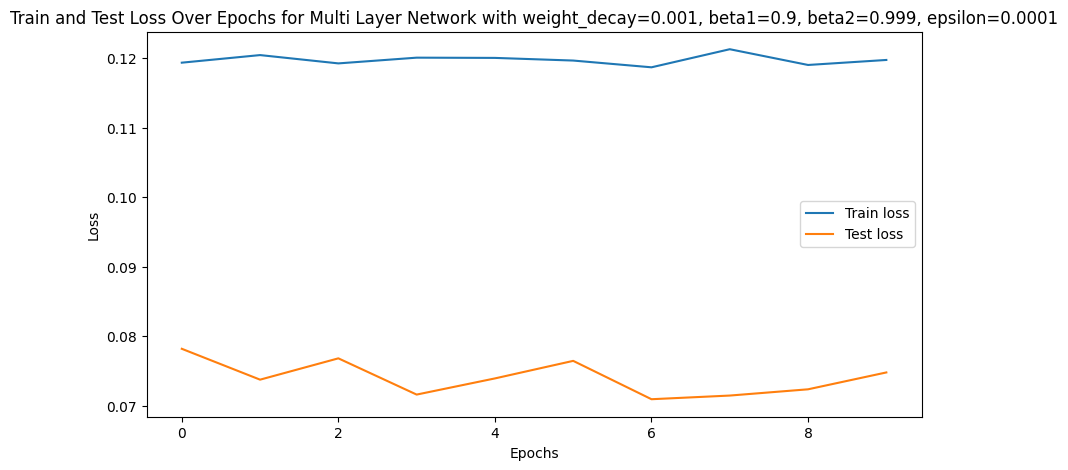

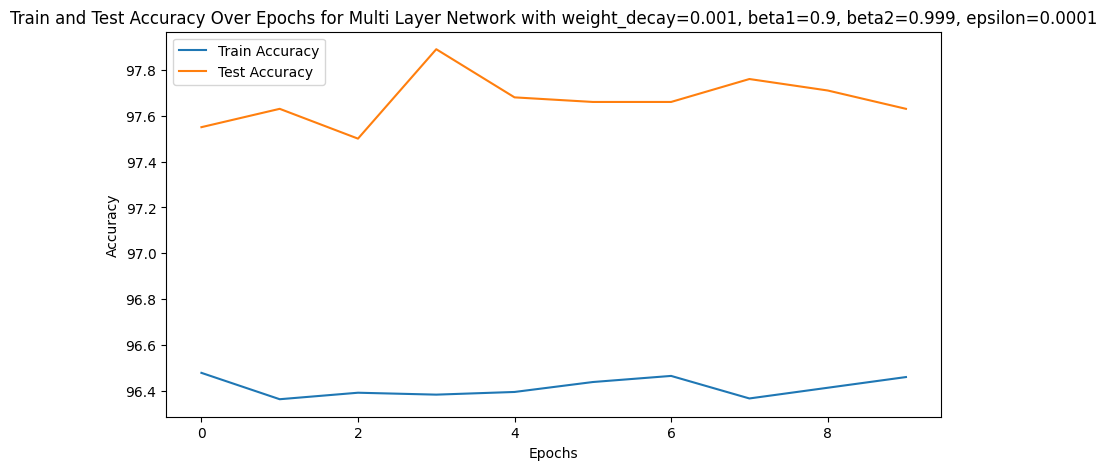

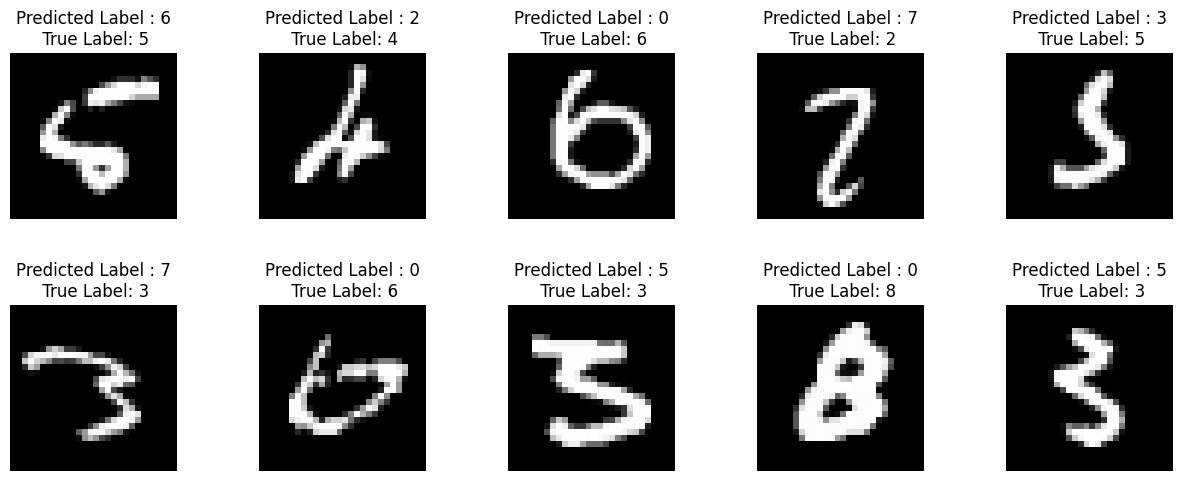

Training model: ConvNet with weight_decay=0.001, beta1=0.9, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0148, Train Acc: 99.61%, Test Loss: 0.0282, Test Acc: 99.12%
Epoch 2/10, Train Loss: 0.0150, Train Acc: 99.59%, Test Loss: 0.0339, Test Acc: 98.91%
Epoch 3/10, Train Loss: 0.0136, Train Acc: 99.61%, Test Loss: 0.0299, Test Acc: 99.09%
Epoch 4/10, Train Loss: 0.0132, Train Acc: 99.67%, Test Loss: 0.0296, Test Acc: 98.98%
Epoch 5/10, Train Loss: 0.0149, Train Acc: 99.57%, Test Loss: 0.0303, Test Acc: 99.06%
Epoch 6/10, Train Loss: 0.0136, Train Acc: 99.65%, Test Loss: 0.0307, Test Acc: 99.03%
Epoch 7/10, Train Loss: 0.0135, Train Acc: 99.62%, Test Loss: 0.0336, Test Acc: 98.96%
Epoch 8/10, Train Loss: 0.0137, Train Acc: 99.63%, Test Loss: 0.0272, Test Acc: 99.14%
Epoch 9/10, Train Loss: 0.0129, Train Acc: 99.67%, Test Loss: 0.0338, Test Acc: 98.87%
Epoch 10/10, Train Loss: 0.0153, Train Acc: 99.59%, Test Loss: 0.0364, Test Acc: 98.93%
Sensitivity Analysis: 9893 correct and 10

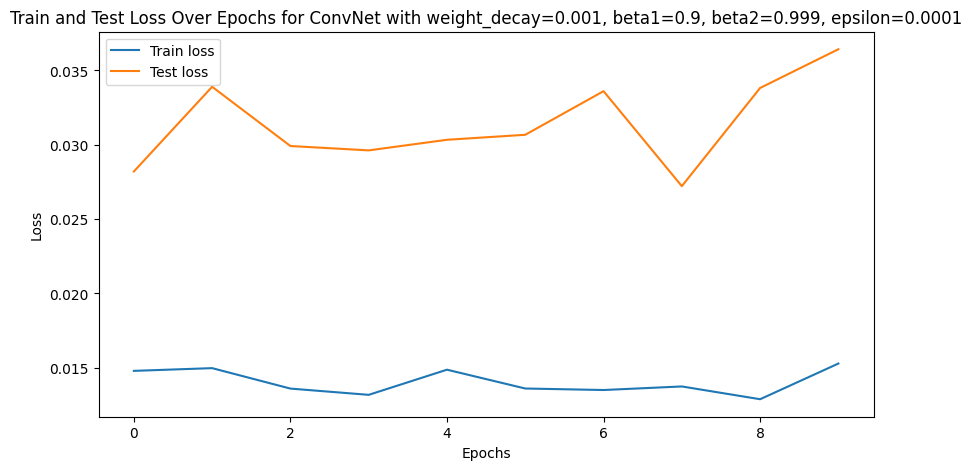

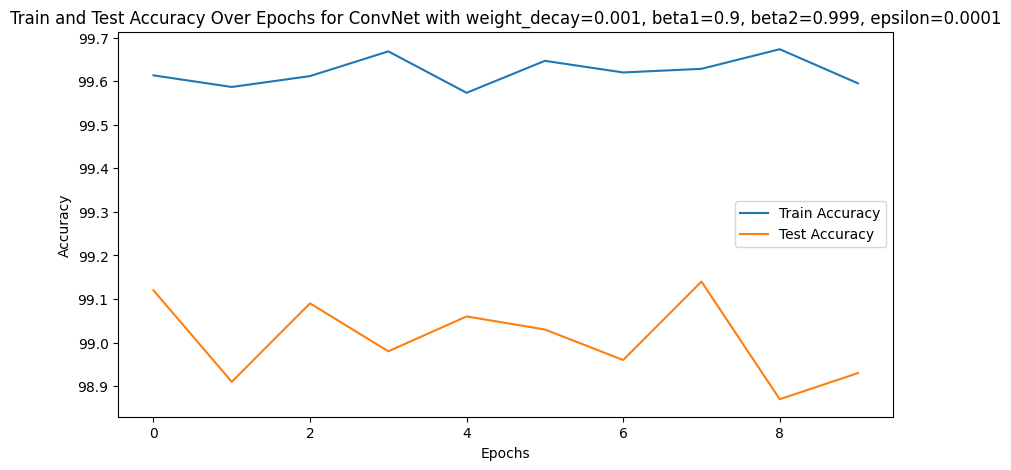

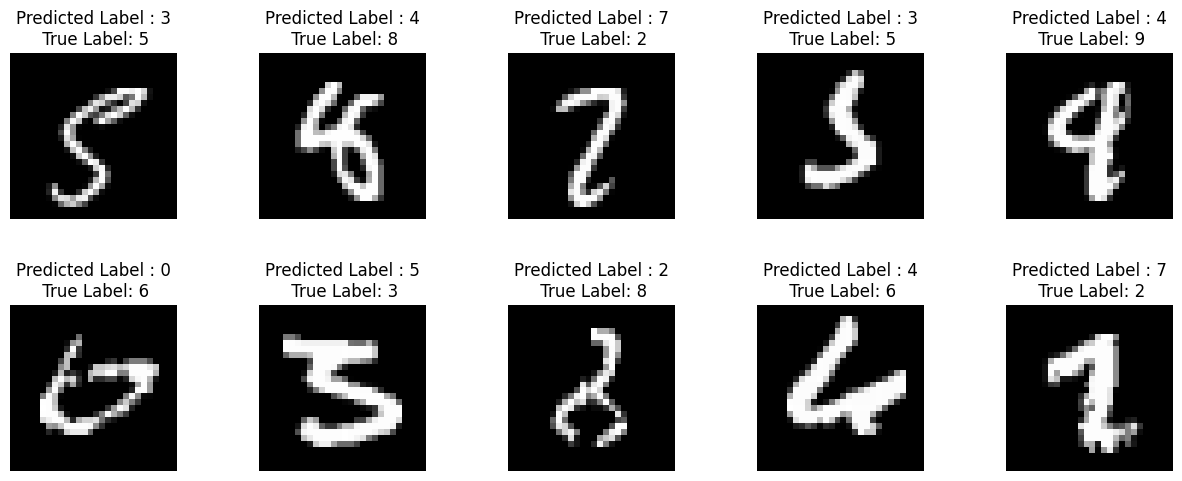

Training model: Logistic Regression with weight_decay=0.001, beta1=0.9, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.2889, Train Acc: 92.09%, Test Loss: 0.2835, Test Acc: 92.08%
Epoch 2/10, Train Loss: 0.2890, Train Acc: 92.11%, Test Loss: 0.2831, Test Acc: 92.25%
Epoch 3/10, Train Loss: 0.2888, Train Acc: 92.16%, Test Loss: 0.2824, Test Acc: 92.11%
Epoch 4/10, Train Loss: 0.2889, Train Acc: 92.06%, Test Loss: 0.2824, Test Acc: 92.34%
Epoch 5/10, Train Loss: 0.2894, Train Acc: 92.07%, Test Loss: 0.2792, Test Acc: 92.29%
Epoch 6/10, Train Loss: 0.2893, Train Acc: 92.07%, Test Loss: 0.2842, Test Acc: 92.25%
Epoch 7/10, Train Loss: 0.2891, Train Acc: 92.09%, Test Loss: 0.2845, Test Acc: 92.11%
Epoch 8/10, Train Loss: 0.2892, Train Acc: 92.12%, Test Loss: 0.2809, Test Acc: 92.07%
Epoch 9/10, Train Loss: 0.2889, Train Acc: 92.08%, Test Loss: 0.2818, Test Acc: 92.17%
Epoch 10/10, Train Loss: 0.2890, Train Acc: 92.11%, Test Loss: 0.2818, Test Acc: 92.19%
Sensitivity Analysis: 9219 co

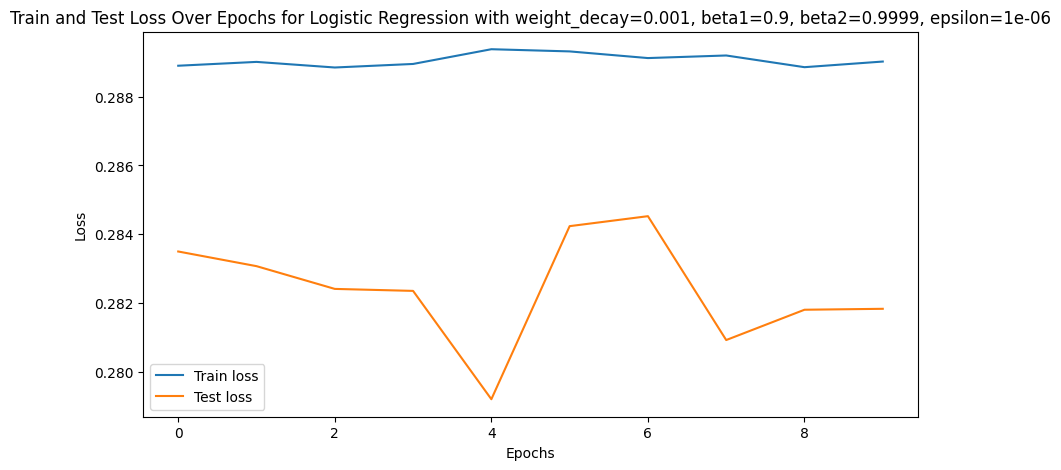

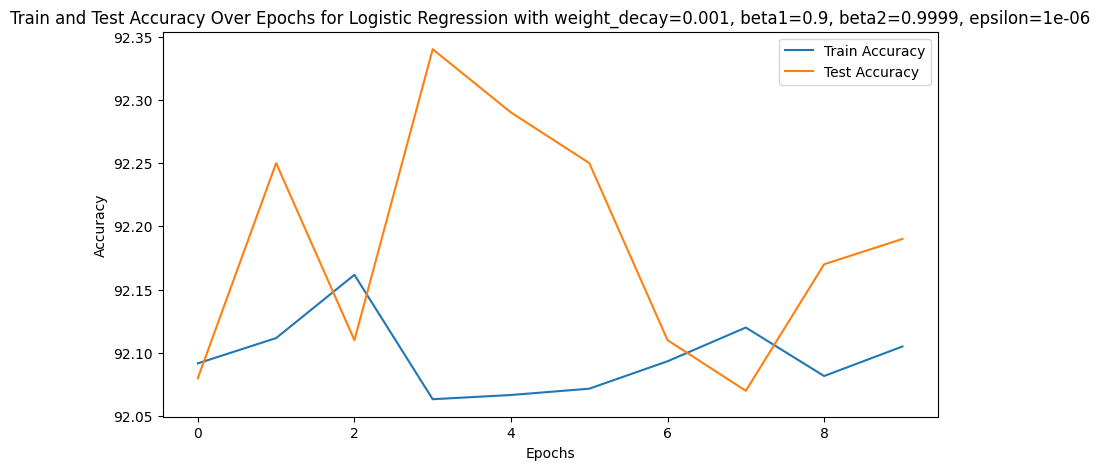

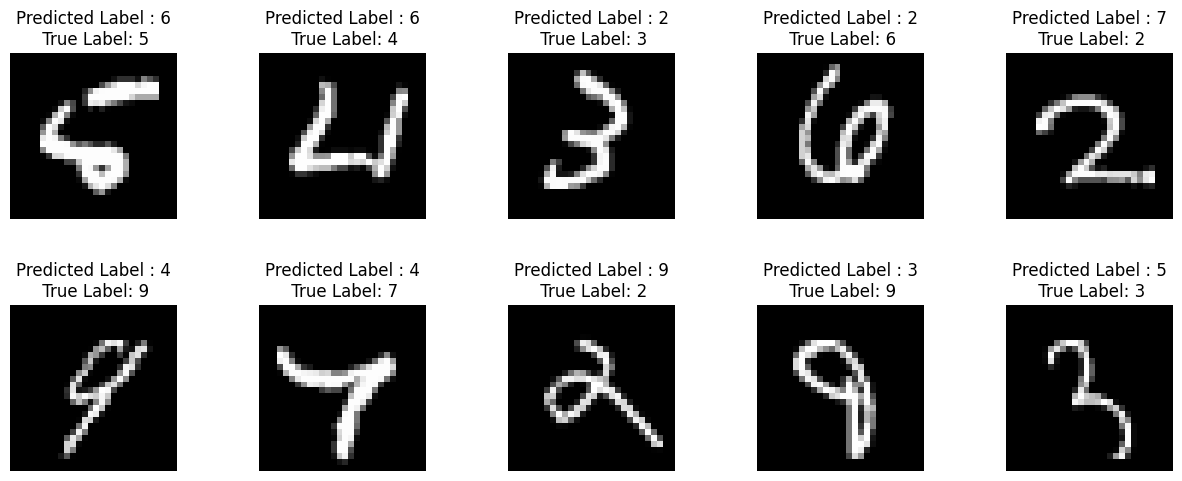

Training model: Multi Layer Network with weight_decay=0.001, beta1=0.9, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.1281, Train Acc: 96.15%, Test Loss: 0.0764, Test Acc: 97.59%
Epoch 2/10, Train Loss: 0.1246, Train Acc: 96.18%, Test Loss: 0.0720, Test Acc: 97.82%
Epoch 3/10, Train Loss: 0.1221, Train Acc: 96.36%, Test Loss: 0.0726, Test Acc: 97.64%
Epoch 4/10, Train Loss: 0.1240, Train Acc: 96.30%, Test Loss: 0.0777, Test Acc: 97.58%
Epoch 5/10, Train Loss: 0.1213, Train Acc: 96.31%, Test Loss: 0.0748, Test Acc: 97.80%
Epoch 6/10, Train Loss: 0.1222, Train Acc: 96.34%, Test Loss: 0.0743, Test Acc: 97.70%
Epoch 7/10, Train Loss: 0.1220, Train Acc: 96.30%, Test Loss: 0.0765, Test Acc: 97.54%
Epoch 8/10, Train Loss: 0.1218, Train Acc: 96.31%, Test Loss: 0.0754, Test Acc: 97.63%
Epoch 9/10, Train Loss: 0.1237, Train Acc: 96.34%, Test Loss: 0.0713, Test Acc: 97.79%
Epoch 10/10, Train Loss: 0.1204, Train Acc: 96.36%, Test Loss: 0.0760, Test Acc: 97.66%
Sensitivity Analysis: 9766 co

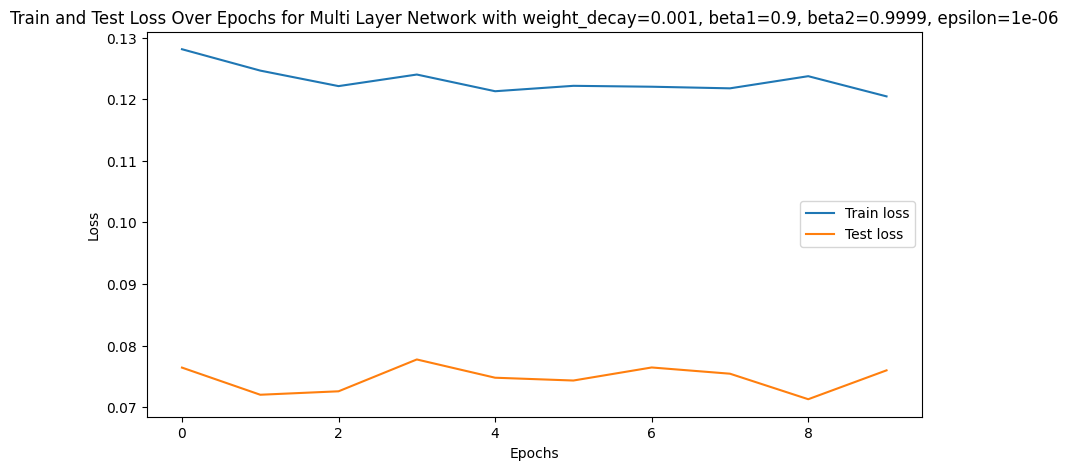

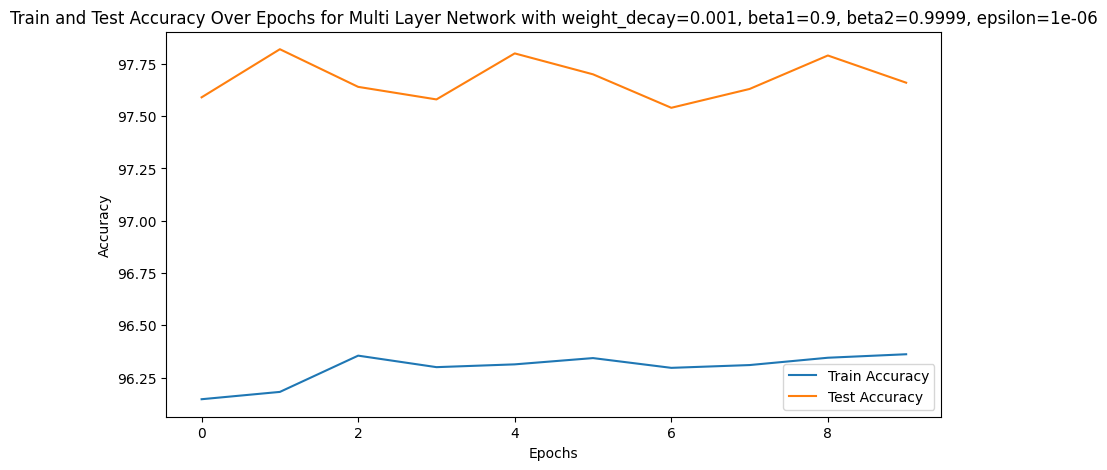

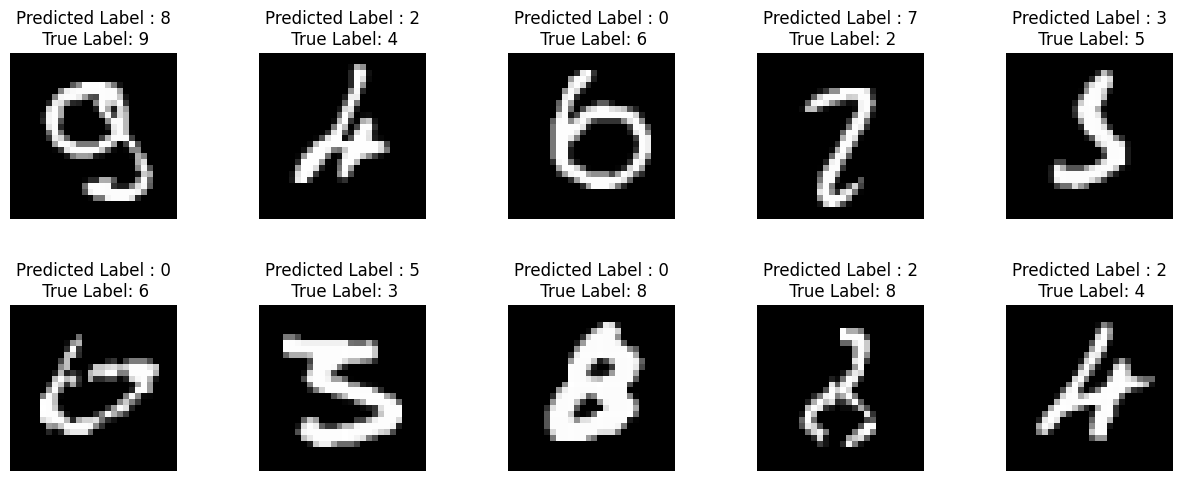

Training model: ConvNet with weight_decay=0.001, beta1=0.9, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0151, Train Acc: 99.56%, Test Loss: 0.0361, Test Acc: 98.91%
Epoch 2/10, Train Loss: 0.0143, Train Acc: 99.61%, Test Loss: 0.0268, Test Acc: 99.12%
Epoch 3/10, Train Loss: 0.0134, Train Acc: 99.62%, Test Loss: 0.0303, Test Acc: 99.08%
Epoch 4/10, Train Loss: 0.0131, Train Acc: 99.66%, Test Loss: 0.0315, Test Acc: 98.98%
Epoch 5/10, Train Loss: 0.0151, Train Acc: 99.56%, Test Loss: 0.0296, Test Acc: 99.00%
Epoch 6/10, Train Loss: 0.0139, Train Acc: 99.61%, Test Loss: 0.0340, Test Acc: 98.80%
Epoch 7/10, Train Loss: 0.0134, Train Acc: 99.63%, Test Loss: 0.0429, Test Acc: 98.75%
Epoch 8/10, Train Loss: 0.0149, Train Acc: 99.58%, Test Loss: 0.0335, Test Acc: 98.98%
Epoch 9/10, Train Loss: 0.0131, Train Acc: 99.67%, Test Loss: 0.0308, Test Acc: 99.01%
Epoch 10/10, Train Loss: 0.0138, Train Acc: 99.62%, Test Loss: 0.0346, Test Acc: 98.95%
Sensitivity Analysis: 9895 correct and 10

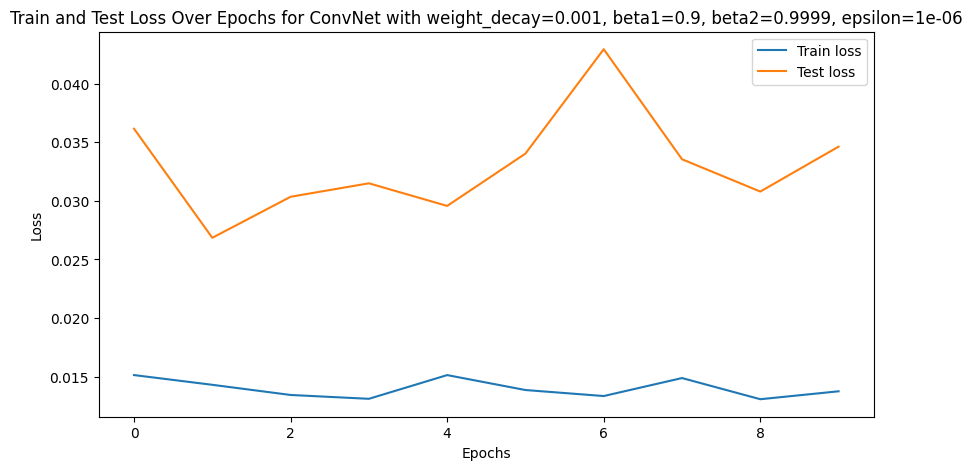

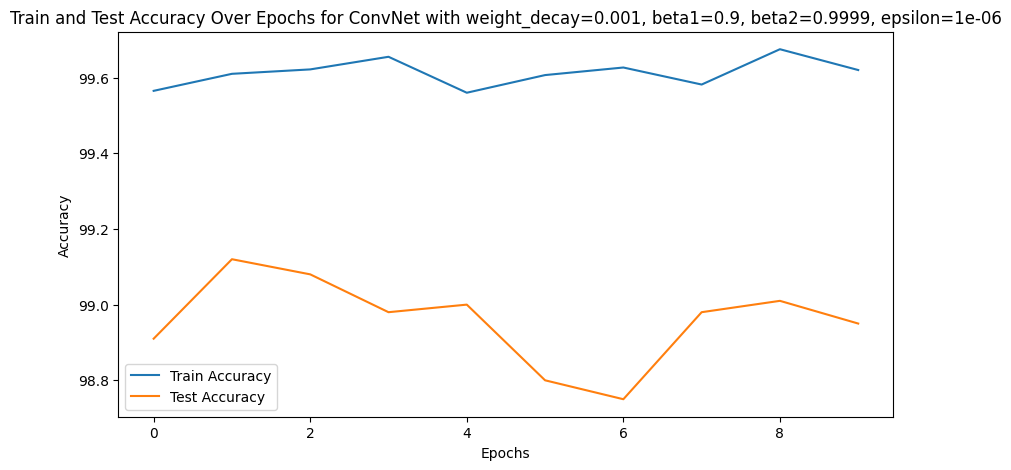

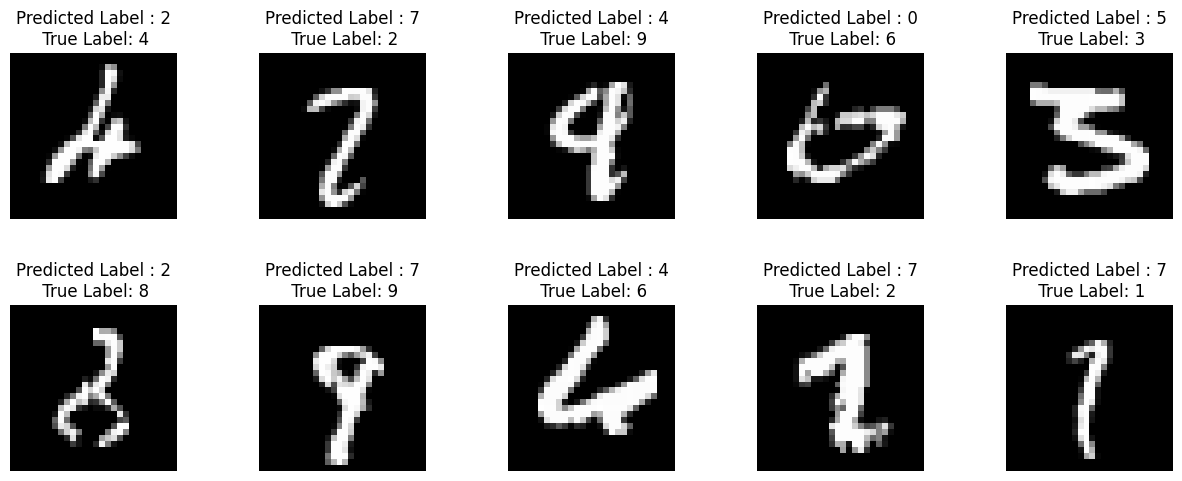

Training model: Logistic Regression with weight_decay=0.001, beta1=0.9, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.2896, Train Acc: 92.11%, Test Loss: 0.2820, Test Acc: 92.27%
Epoch 2/10, Train Loss: 0.2895, Train Acc: 92.11%, Test Loss: 0.2845, Test Acc: 92.14%
Epoch 3/10, Train Loss: 0.2893, Train Acc: 92.15%, Test Loss: 0.2829, Test Acc: 92.03%
Epoch 4/10, Train Loss: 0.2893, Train Acc: 92.08%, Test Loss: 0.2831, Test Acc: 92.14%
Epoch 5/10, Train Loss: 0.2894, Train Acc: 92.12%, Test Loss: 0.2821, Test Acc: 92.16%
Epoch 6/10, Train Loss: 0.2894, Train Acc: 92.05%, Test Loss: 0.2827, Test Acc: 92.15%
Epoch 7/10, Train Loss: 0.2892, Train Acc: 91.97%, Test Loss: 0.2827, Test Acc: 92.26%
Epoch 8/10, Train Loss: 0.2895, Train Acc: 92.09%, Test Loss: 0.2821, Test Acc: 92.13%
Epoch 9/10, Train Loss: 0.2891, Train Acc: 92.17%, Test Loss: 0.2809, Test Acc: 92.30%
Epoch 10/10, Train Loss: 0.2895, Train Acc: 92.11%, Test Loss: 0.2814, Test Acc: 92.14%
Sensitivity Analysis: 9214 c

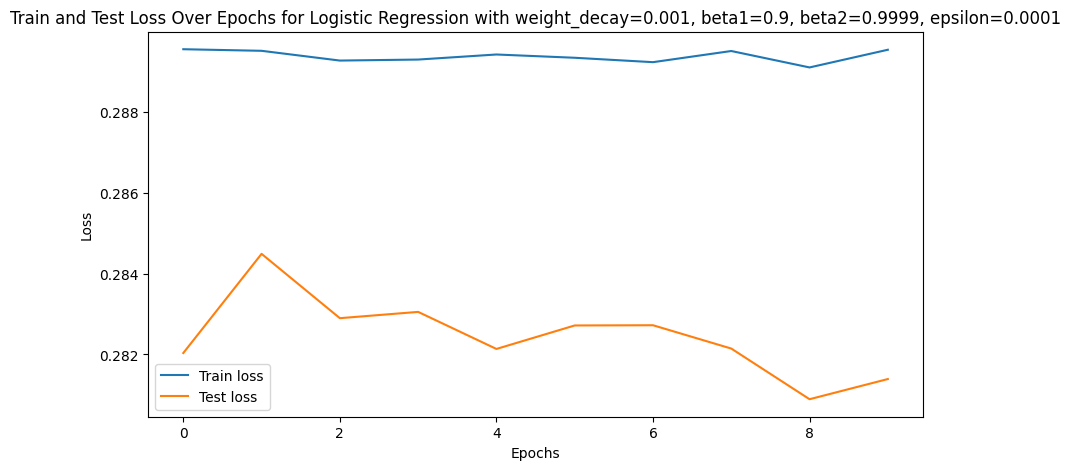

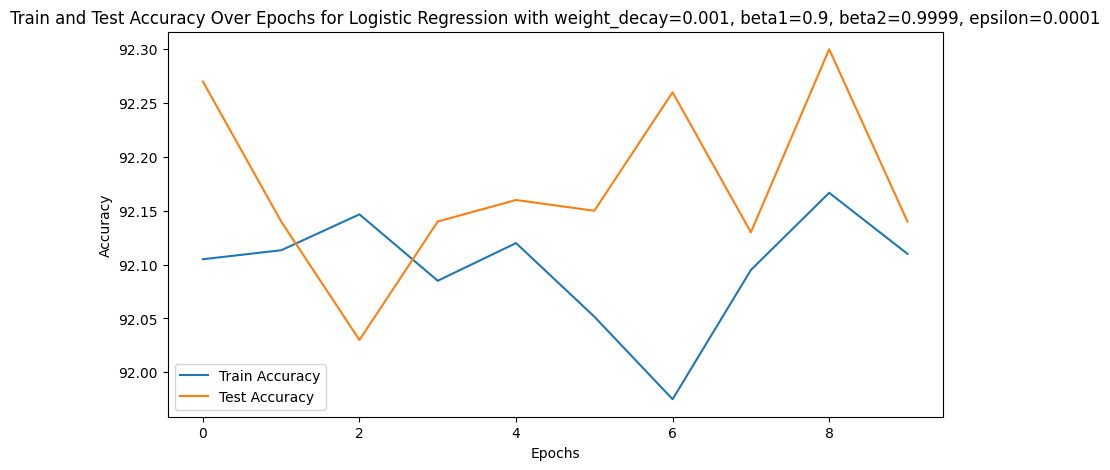

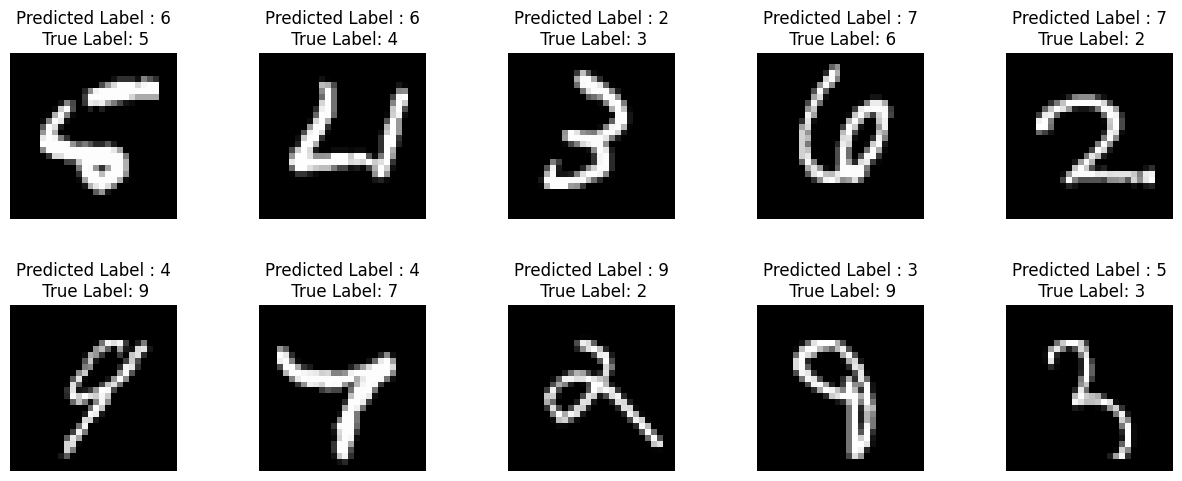

Training model: Multi Layer Network with weight_decay=0.001, beta1=0.9, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.1231, Train Acc: 96.29%, Test Loss: 0.0771, Test Acc: 97.63%
Epoch 2/10, Train Loss: 0.1210, Train Acc: 96.39%, Test Loss: 0.0736, Test Acc: 97.68%
Epoch 3/10, Train Loss: 0.1202, Train Acc: 96.51%, Test Loss: 0.0727, Test Acc: 97.77%
Epoch 4/10, Train Loss: 0.1194, Train Acc: 96.40%, Test Loss: 0.0722, Test Acc: 97.70%
Epoch 5/10, Train Loss: 0.1204, Train Acc: 96.44%, Test Loss: 0.0726, Test Acc: 97.81%
Epoch 6/10, Train Loss: 0.1198, Train Acc: 96.42%, Test Loss: 0.0710, Test Acc: 97.77%
Epoch 7/10, Train Loss: 0.1183, Train Acc: 96.47%, Test Loss: 0.0746, Test Acc: 97.76%
Epoch 8/10, Train Loss: 0.1194, Train Acc: 96.42%, Test Loss: 0.0720, Test Acc: 97.92%
Epoch 9/10, Train Loss: 0.1208, Train Acc: 96.39%, Test Loss: 0.0732, Test Acc: 97.82%
Epoch 10/10, Train Loss: 0.1182, Train Acc: 96.51%, Test Loss: 0.0696, Test Acc: 97.83%
Sensitivity Analysis: 9783 c

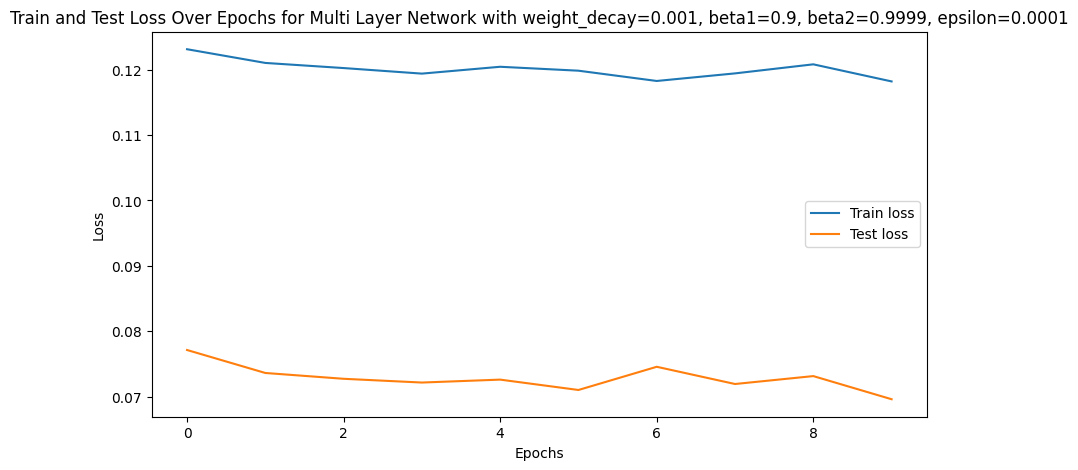

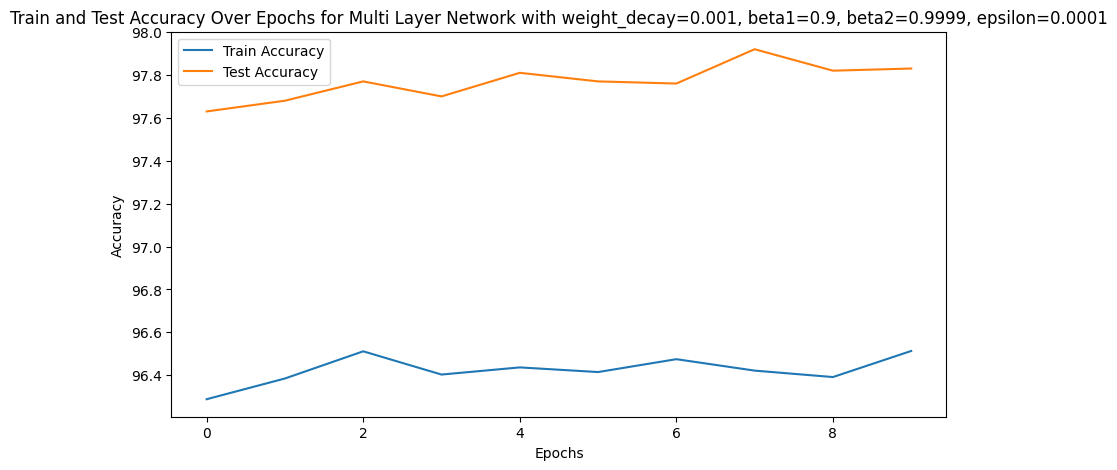

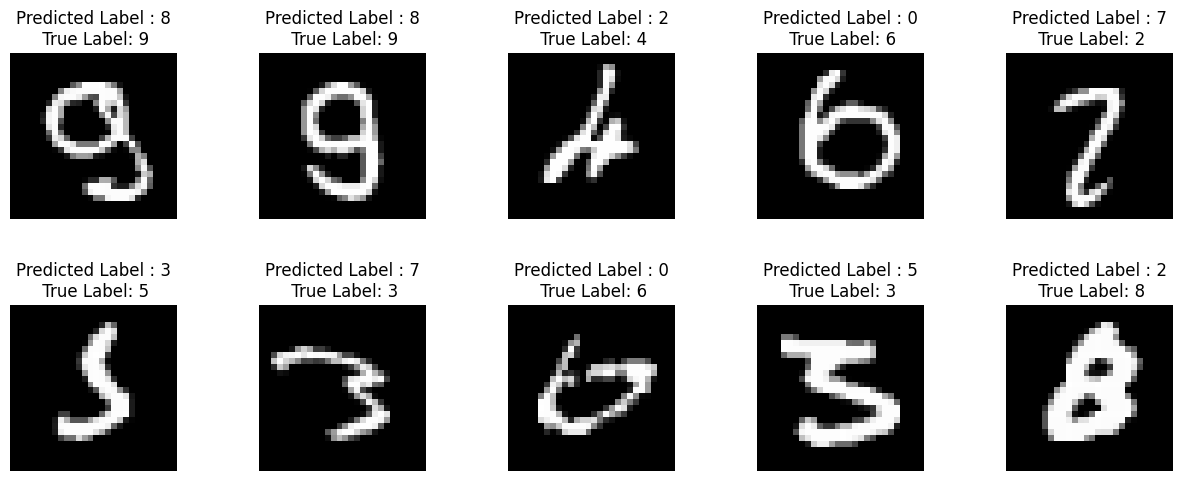

Training model: ConvNet with weight_decay=0.001, beta1=0.9, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0139, Train Acc: 99.60%, Test Loss: 0.0314, Test Acc: 99.05%
Epoch 2/10, Train Loss: 0.0135, Train Acc: 99.62%, Test Loss: 0.0306, Test Acc: 99.01%
Epoch 3/10, Train Loss: 0.0131, Train Acc: 99.64%, Test Loss: 0.0327, Test Acc: 98.97%
Epoch 4/10, Train Loss: 0.0138, Train Acc: 99.61%, Test Loss: 0.0510, Test Acc: 98.38%
Epoch 5/10, Train Loss: 0.0144, Train Acc: 99.57%, Test Loss: 0.0277, Test Acc: 99.19%
Epoch 6/10, Train Loss: 0.0130, Train Acc: 99.67%, Test Loss: 0.0301, Test Acc: 99.02%
Epoch 7/10, Train Loss: 0.0118, Train Acc: 99.69%, Test Loss: 0.0300, Test Acc: 99.02%
Epoch 8/10, Train Loss: 0.0142, Train Acc: 99.57%, Test Loss: 0.0312, Test Acc: 99.07%
Epoch 9/10, Train Loss: 0.0122, Train Acc: 99.68%, Test Loss: 0.0314, Test Acc: 99.01%
Epoch 10/10, Train Loss: 0.0133, Train Acc: 99.62%, Test Loss: 0.0325, Test Acc: 99.01%
Sensitivity Analysis: 9901 correct and 9

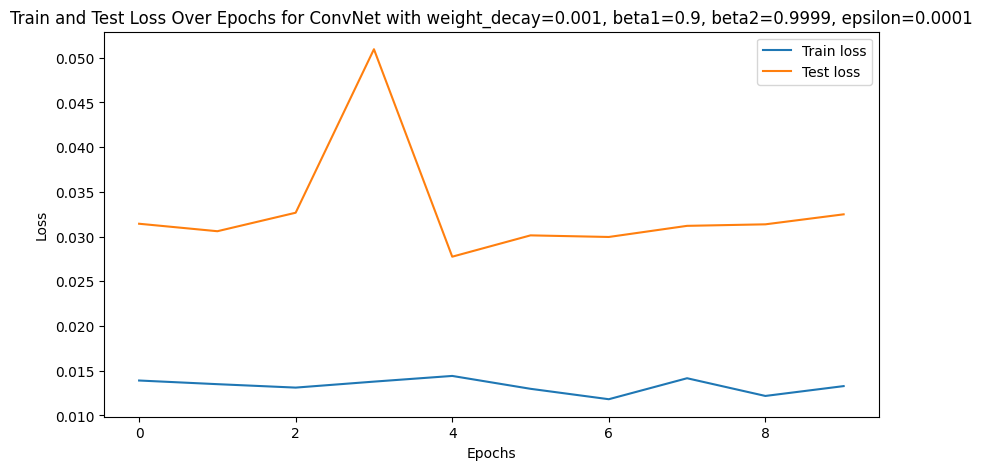

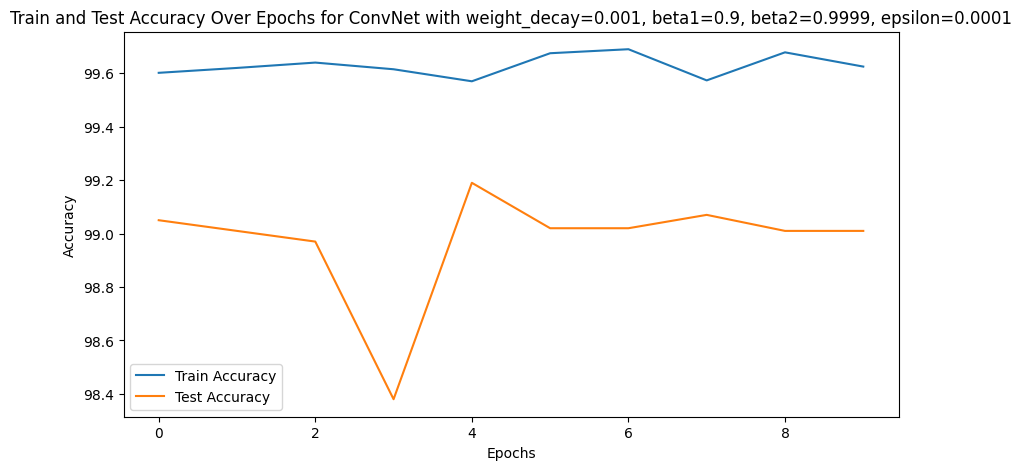

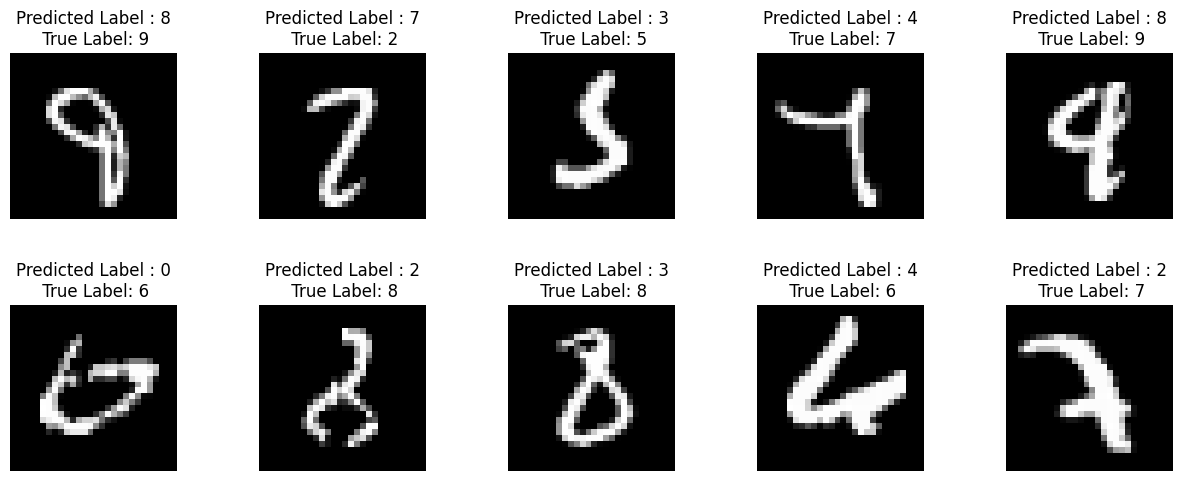

Training model: Logistic Regression with weight_decay=0.001, beta1=0.99, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.2904, Train Acc: 92.01%, Test Loss: 0.2838, Test Acc: 92.13%
Epoch 2/10, Train Loss: 0.2888, Train Acc: 92.16%, Test Loss: 0.2821, Test Acc: 92.22%
Epoch 3/10, Train Loss: 0.2892, Train Acc: 92.10%, Test Loss: 0.2819, Test Acc: 92.18%
Epoch 4/10, Train Loss: 0.2890, Train Acc: 92.07%, Test Loss: 0.2829, Test Acc: 92.04%
Epoch 5/10, Train Loss: 0.2887, Train Acc: 92.11%, Test Loss: 0.2832, Test Acc: 92.16%
Epoch 6/10, Train Loss: 0.2890, Train Acc: 92.11%, Test Loss: 0.2830, Test Acc: 91.95%
Epoch 7/10, Train Loss: 0.2887, Train Acc: 92.21%, Test Loss: 0.2841, Test Acc: 92.16%
Epoch 8/10, Train Loss: 0.2886, Train Acc: 92.11%, Test Loss: 0.2825, Test Acc: 92.20%
Epoch 9/10, Train Loss: 0.2889, Train Acc: 92.12%, Test Loss: 0.2835, Test Acc: 92.19%
Epoch 10/10, Train Loss: 0.2891, Train Acc: 92.07%, Test Loss: 0.2844, Test Acc: 92.16%
Sensitivity Analysis: 9216 co

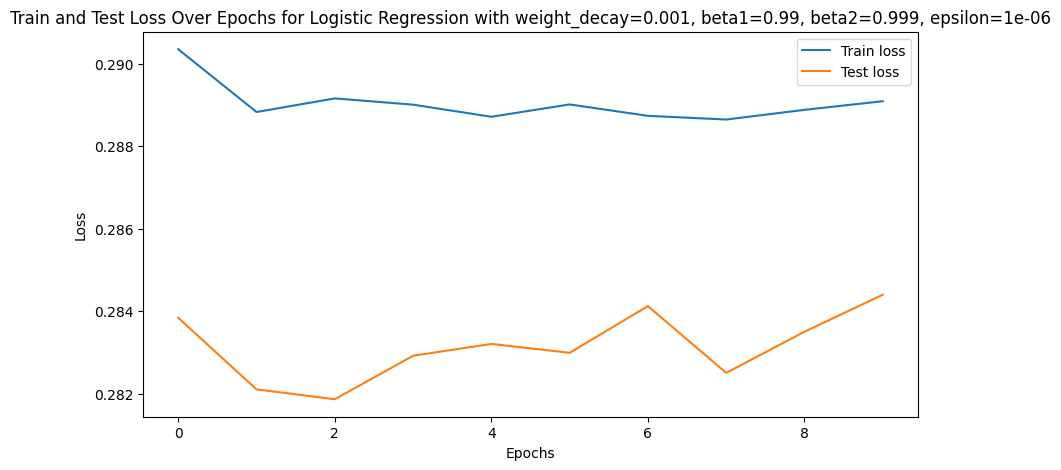

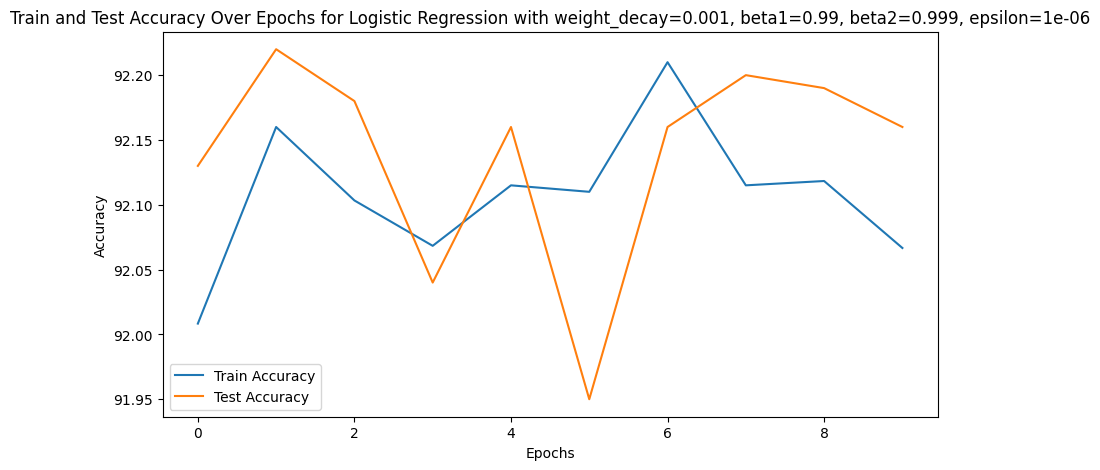

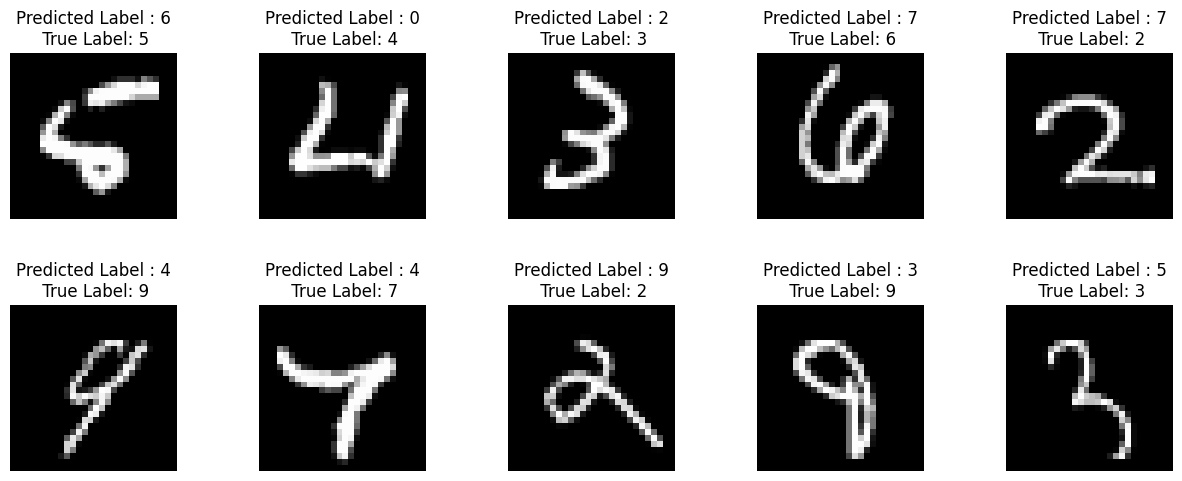

Training model: Multi Layer Network with weight_decay=0.001, beta1=0.99, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.1344, Train Acc: 96.00%, Test Loss: 0.0737, Test Acc: 97.75%
Epoch 2/10, Train Loss: 0.1207, Train Acc: 96.43%, Test Loss: 0.0701, Test Acc: 97.65%
Epoch 3/10, Train Loss: 0.1187, Train Acc: 96.50%, Test Loss: 0.0761, Test Acc: 97.83%
Epoch 4/10, Train Loss: 0.1234, Train Acc: 96.35%, Test Loss: 0.0789, Test Acc: 97.52%
Epoch 5/10, Train Loss: 0.1210, Train Acc: 96.49%, Test Loss: 0.0768, Test Acc: 97.60%
Epoch 6/10, Train Loss: 0.1218, Train Acc: 96.36%, Test Loss: 0.0744, Test Acc: 97.81%
Epoch 7/10, Train Loss: 0.1207, Train Acc: 96.39%, Test Loss: 0.0782, Test Acc: 97.73%
Epoch 8/10, Train Loss: 0.1199, Train Acc: 96.39%, Test Loss: 0.0728, Test Acc: 97.67%
Epoch 9/10, Train Loss: 0.1218, Train Acc: 96.36%, Test Loss: 0.0743, Test Acc: 97.59%
Epoch 10/10, Train Loss: 0.1203, Train Acc: 96.38%, Test Loss: 0.0709, Test Acc: 97.75%
Sensitivity Analysis: 9775 co

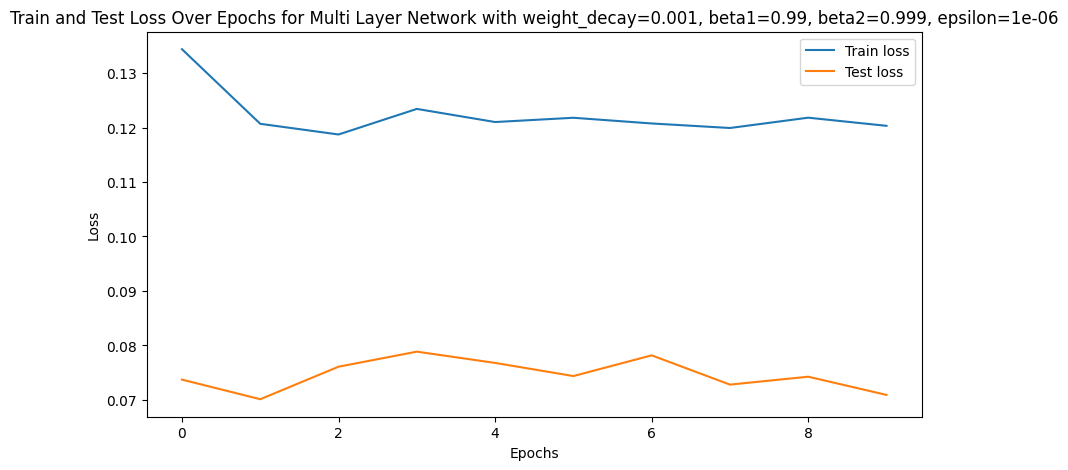

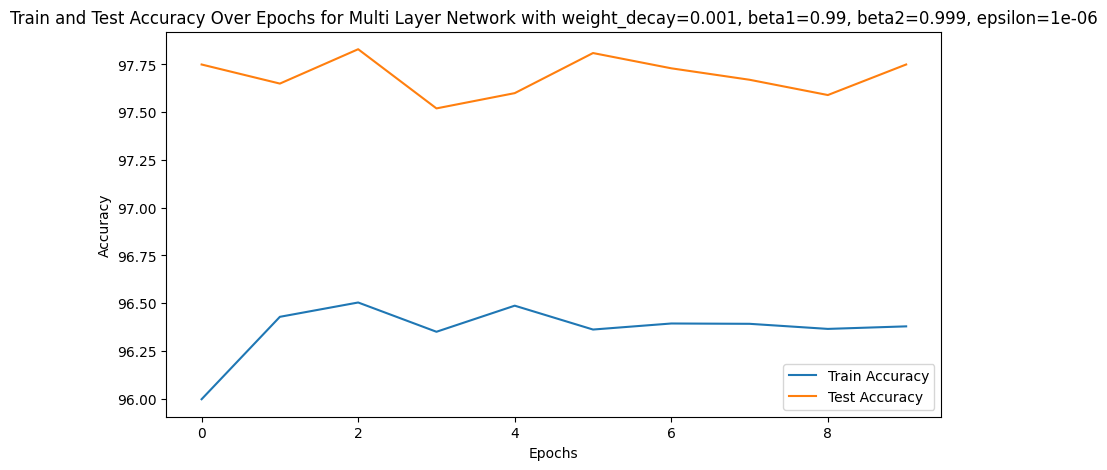

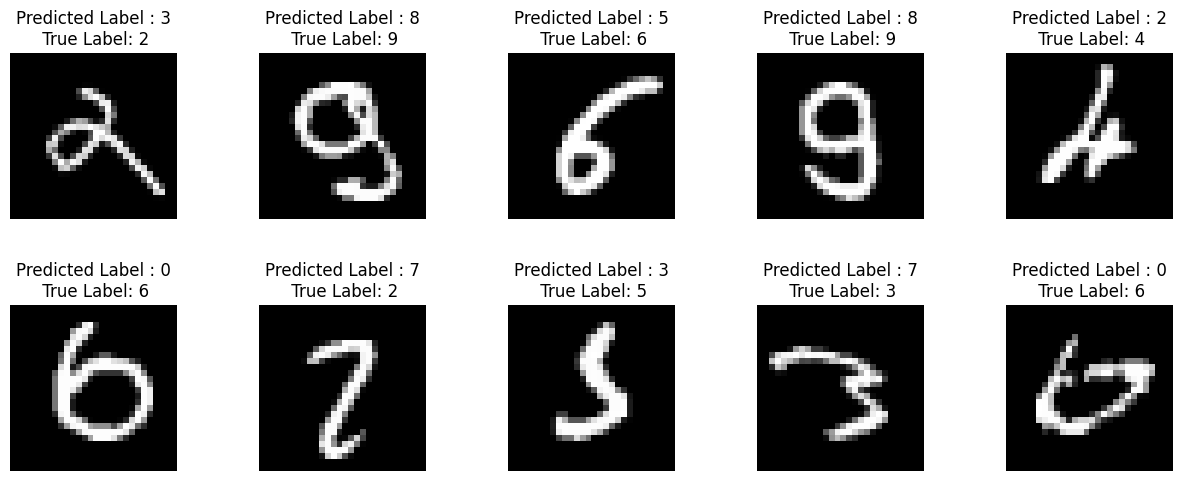

Training model: ConvNet with weight_decay=0.001, beta1=0.99, beta2=0.999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0151, Train Acc: 99.57%, Test Loss: 0.0294, Test Acc: 99.03%
Epoch 2/10, Train Loss: 0.0117, Train Acc: 99.71%, Test Loss: 0.0326, Test Acc: 98.94%
Epoch 3/10, Train Loss: 0.0122, Train Acc: 99.68%, Test Loss: 0.0273, Test Acc: 99.19%
Epoch 4/10, Train Loss: 0.0112, Train Acc: 99.73%, Test Loss: 0.0276, Test Acc: 99.06%
Epoch 5/10, Train Loss: 0.0118, Train Acc: 99.71%, Test Loss: 0.0293, Test Acc: 99.08%
Epoch 6/10, Train Loss: 0.0135, Train Acc: 99.62%, Test Loss: 0.0284, Test Acc: 99.06%
Epoch 7/10, Train Loss: 0.0123, Train Acc: 99.67%, Test Loss: 0.0316, Test Acc: 98.96%
Epoch 8/10, Train Loss: 0.0111, Train Acc: 99.72%, Test Loss: 0.0353, Test Acc: 98.88%
Epoch 9/10, Train Loss: 0.0111, Train Acc: 99.72%, Test Loss: 0.0266, Test Acc: 99.18%
Epoch 10/10, Train Loss: 0.0115, Train Acc: 99.71%, Test Loss: 0.0304, Test Acc: 99.05%
Sensitivity Analysis: 9905 correct and 95

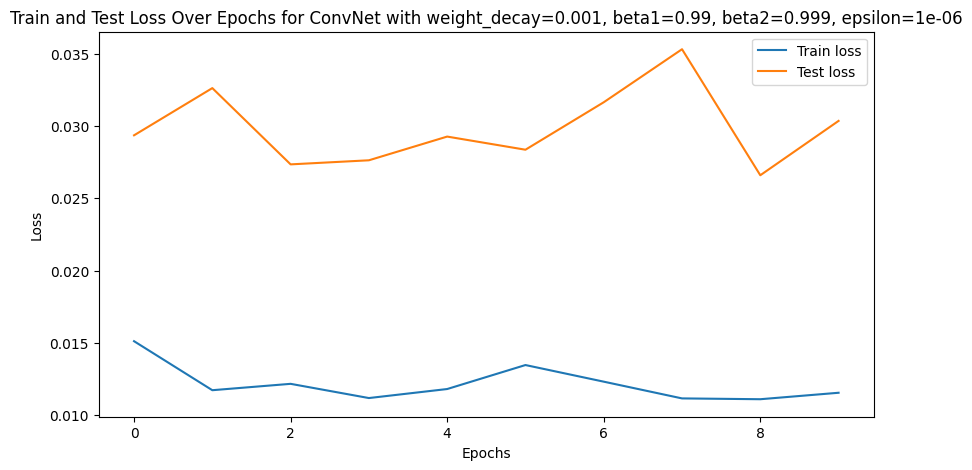

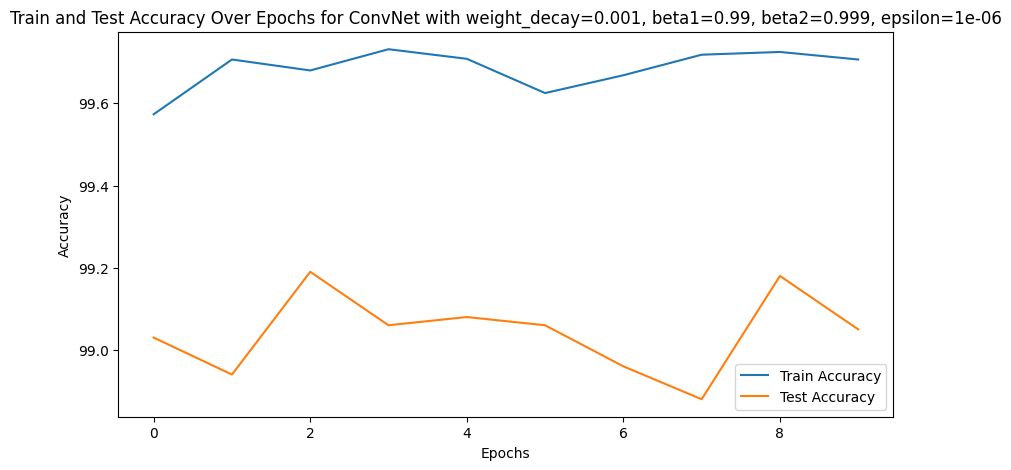

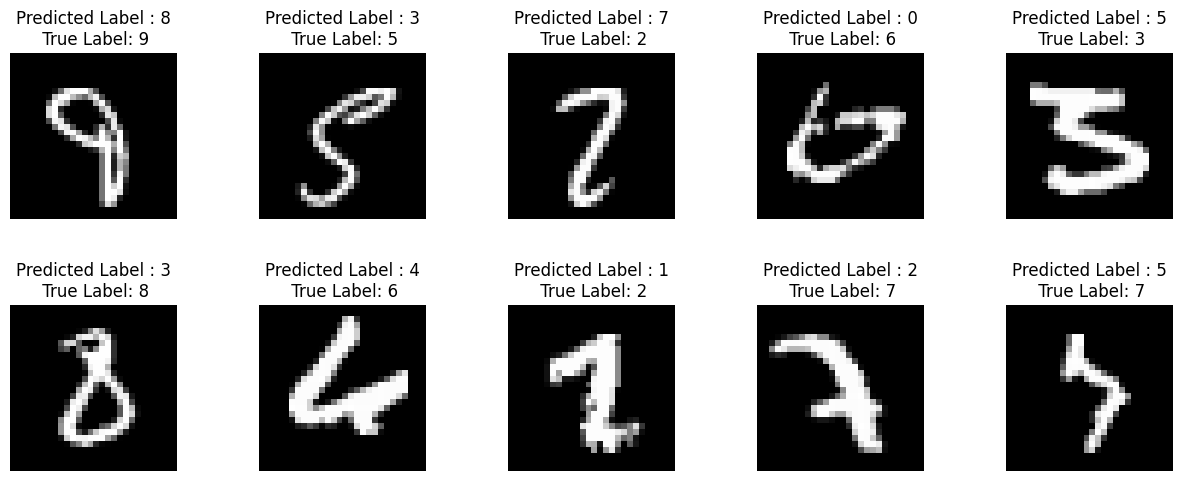

Training model: Logistic Regression with weight_decay=0.001, beta1=0.99, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.2910, Train Acc: 92.03%, Test Loss: 0.2829, Test Acc: 92.20%
Epoch 2/10, Train Loss: 0.2884, Train Acc: 92.11%, Test Loss: 0.2830, Test Acc: 92.22%
Epoch 3/10, Train Loss: 0.2888, Train Acc: 92.13%, Test Loss: 0.2814, Test Acc: 92.08%
Epoch 4/10, Train Loss: 0.2895, Train Acc: 92.08%, Test Loss: 0.2833, Test Acc: 92.11%
Epoch 5/10, Train Loss: 0.2895, Train Acc: 92.14%, Test Loss: 0.2838, Test Acc: 92.27%
Epoch 6/10, Train Loss: 0.2891, Train Acc: 92.13%, Test Loss: 0.2820, Test Acc: 92.20%
Epoch 7/10, Train Loss: 0.2885, Train Acc: 92.17%, Test Loss: 0.2832, Test Acc: 92.22%
Epoch 8/10, Train Loss: 0.2890, Train Acc: 92.12%, Test Loss: 0.2812, Test Acc: 92.14%
Epoch 9/10, Train Loss: 0.2885, Train Acc: 92.10%, Test Loss: 0.2814, Test Acc: 92.17%
Epoch 10/10, Train Loss: 0.2893, Train Acc: 92.09%, Test Loss: 0.2837, Test Acc: 92.08%
Sensitivity Analysis: 9208 c

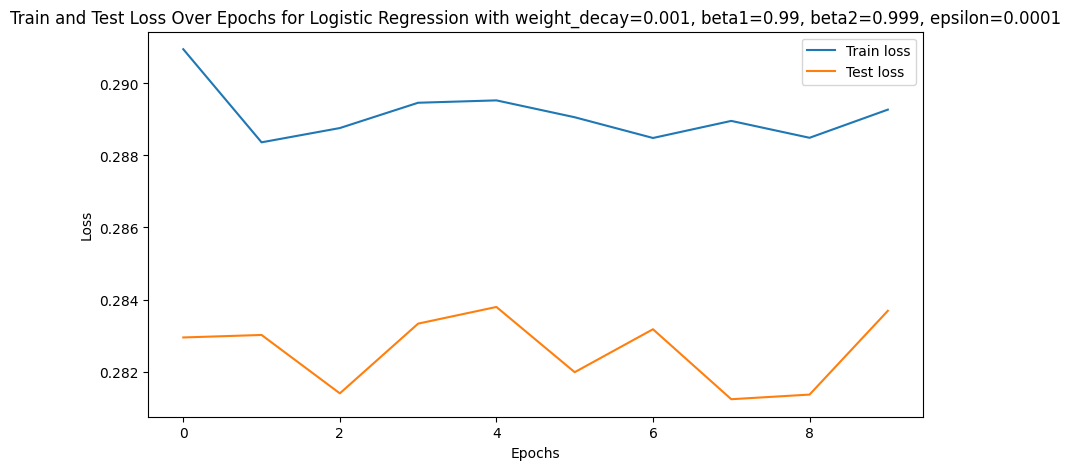

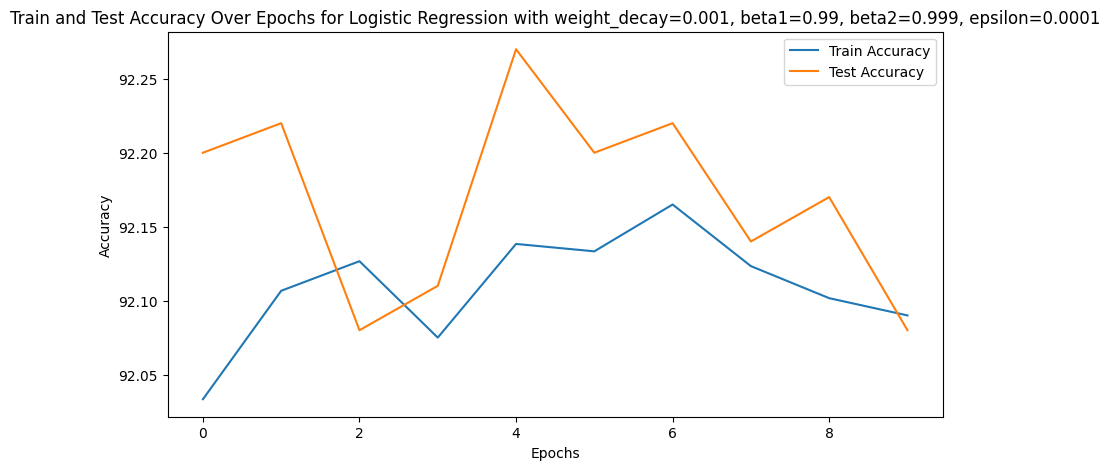

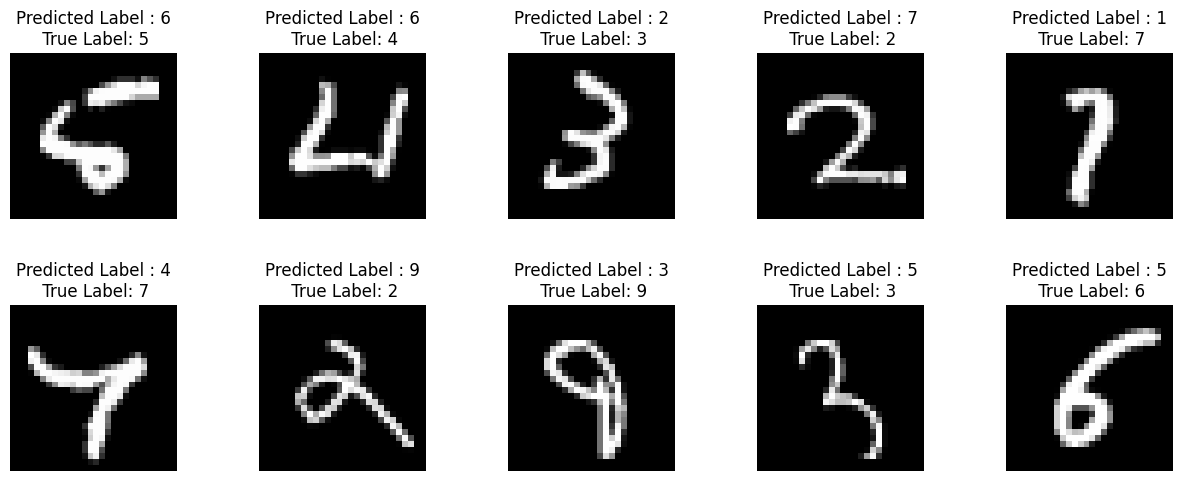

Training model: Multi Layer Network with weight_decay=0.001, beta1=0.99, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.1338, Train Acc: 95.97%, Test Loss: 0.0777, Test Acc: 97.74%
Epoch 2/10, Train Loss: 0.1209, Train Acc: 96.39%, Test Loss: 0.0774, Test Acc: 97.64%
Epoch 3/10, Train Loss: 0.1198, Train Acc: 96.41%, Test Loss: 0.0793, Test Acc: 97.59%
Epoch 4/10, Train Loss: 0.1202, Train Acc: 96.49%, Test Loss: 0.0729, Test Acc: 97.80%
Epoch 5/10, Train Loss: 0.1206, Train Acc: 96.36%, Test Loss: 0.0726, Test Acc: 97.79%
Epoch 6/10, Train Loss: 0.1169, Train Acc: 96.48%, Test Loss: 0.0762, Test Acc: 97.69%
Epoch 7/10, Train Loss: 0.1214, Train Acc: 96.37%, Test Loss: 0.0761, Test Acc: 97.60%
Epoch 8/10, Train Loss: 0.1232, Train Acc: 96.33%, Test Loss: 0.0716, Test Acc: 97.85%
Epoch 9/10, Train Loss: 0.1241, Train Acc: 96.34%, Test Loss: 0.0737, Test Acc: 97.75%
Epoch 10/10, Train Loss: 0.1179, Train Acc: 96.47%, Test Loss: 0.0747, Test Acc: 97.82%
Sensitivity Analysis: 9782 c

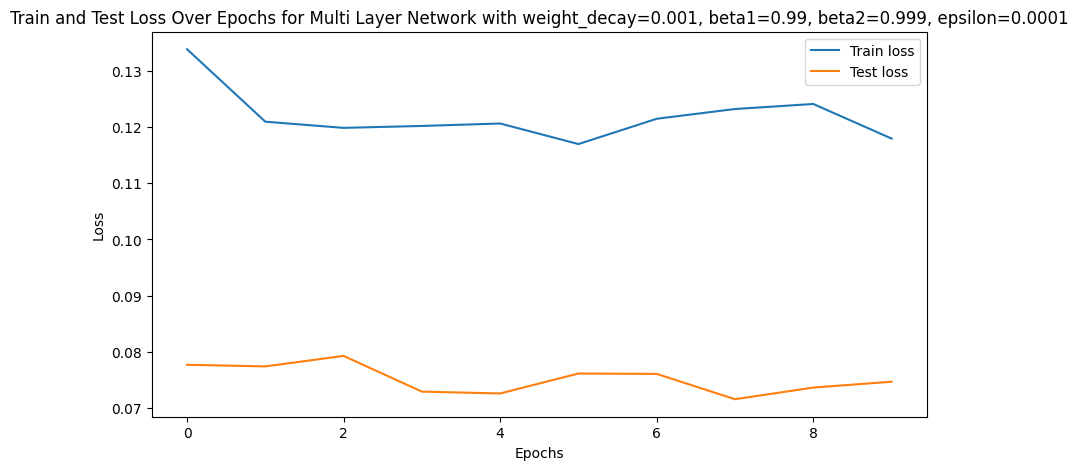

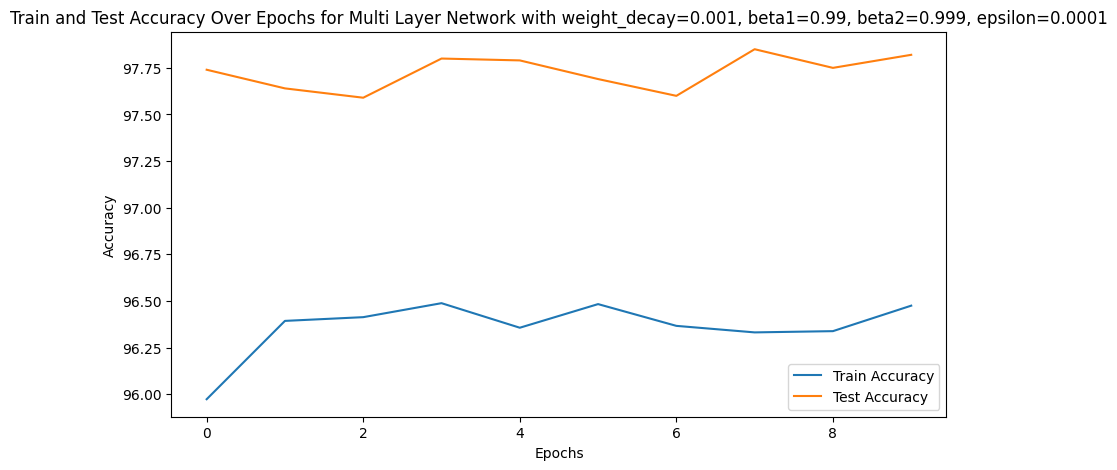

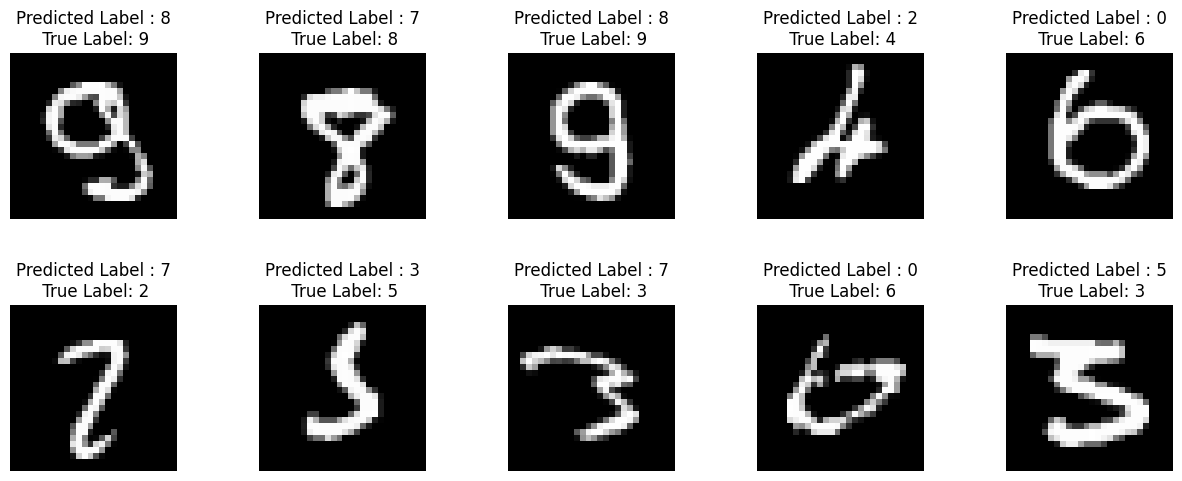

Training model: ConvNet with weight_decay=0.001, beta1=0.99, beta2=0.999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0147, Train Acc: 99.60%, Test Loss: 0.0311, Test Acc: 99.05%
Epoch 2/10, Train Loss: 0.0115, Train Acc: 99.72%, Test Loss: 0.0310, Test Acc: 98.94%
Epoch 3/10, Train Loss: 0.0105, Train Acc: 99.76%, Test Loss: 0.0320, Test Acc: 98.96%
Epoch 4/10, Train Loss: 0.0127, Train Acc: 99.66%, Test Loss: 0.0336, Test Acc: 98.96%
Epoch 5/10, Train Loss: 0.0120, Train Acc: 99.68%, Test Loss: 0.0290, Test Acc: 99.05%
Epoch 6/10, Train Loss: 0.0116, Train Acc: 99.70%, Test Loss: 0.0292, Test Acc: 98.99%
Epoch 7/10, Train Loss: 0.0121, Train Acc: 99.69%, Test Loss: 0.0322, Test Acc: 98.94%
Epoch 8/10, Train Loss: 0.0124, Train Acc: 99.66%, Test Loss: 0.0319, Test Acc: 98.99%
Epoch 9/10, Train Loss: 0.0129, Train Acc: 99.62%, Test Loss: 0.0311, Test Acc: 99.12%
Epoch 10/10, Train Loss: 0.0118, Train Acc: 99.71%, Test Loss: 0.0270, Test Acc: 99.15%
Sensitivity Analysis: 9915 correct and 8

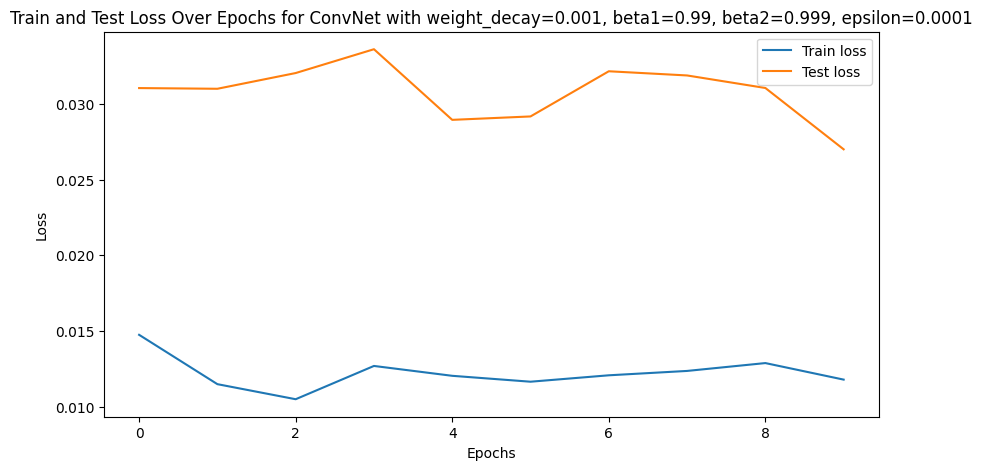

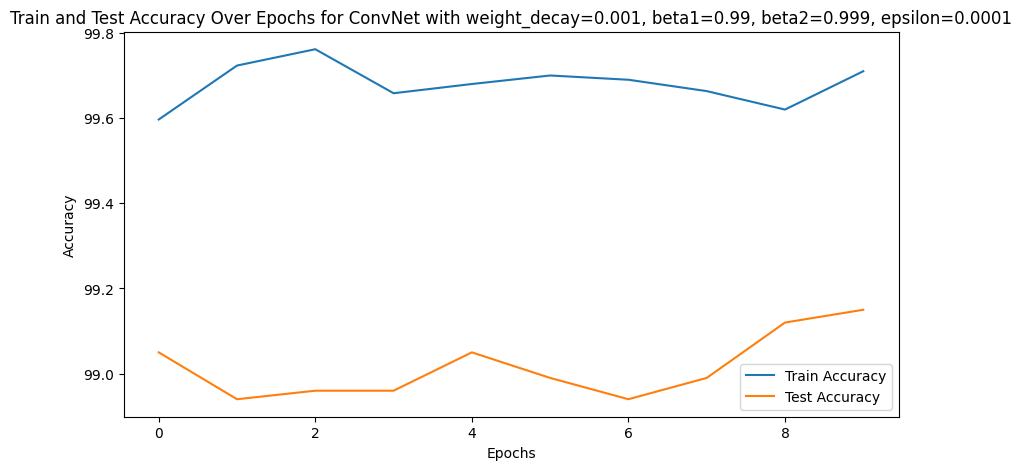

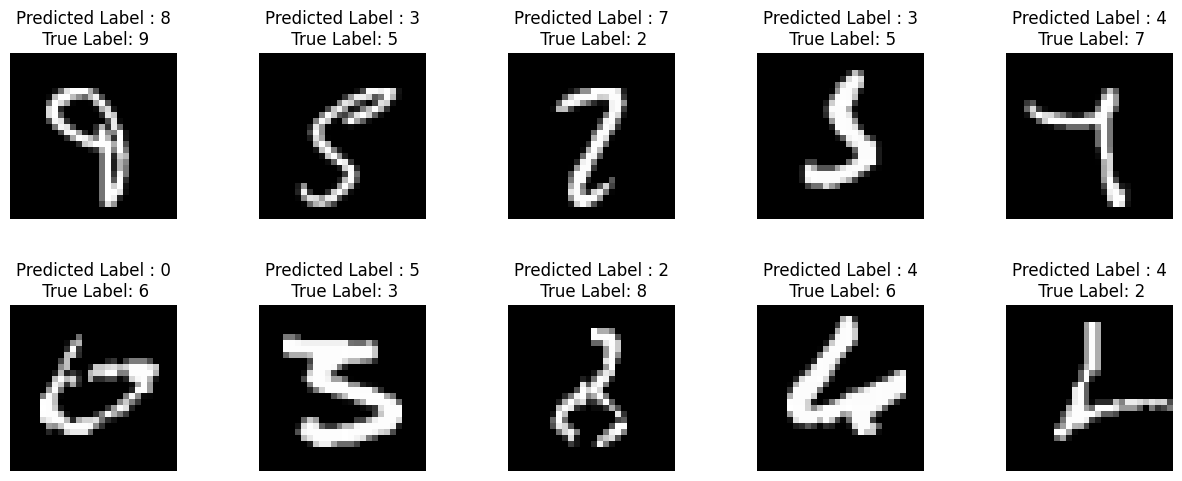

Training model: Logistic Regression with weight_decay=0.001, beta1=0.99, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.2910, Train Acc: 92.08%, Test Loss: 0.2805, Test Acc: 92.20%
Epoch 2/10, Train Loss: 0.2898, Train Acc: 92.03%, Test Loss: 0.2827, Test Acc: 92.19%
Epoch 3/10, Train Loss: 0.2885, Train Acc: 92.07%, Test Loss: 0.2828, Test Acc: 91.95%
Epoch 4/10, Train Loss: 0.2893, Train Acc: 92.11%, Test Loss: 0.2828, Test Acc: 92.05%
Epoch 5/10, Train Loss: 0.2890, Train Acc: 92.09%, Test Loss: 0.2819, Test Acc: 92.15%
Epoch 6/10, Train Loss: 0.2888, Train Acc: 92.08%, Test Loss: 0.2833, Test Acc: 92.03%
Epoch 7/10, Train Loss: 0.2898, Train Acc: 92.03%, Test Loss: 0.2837, Test Acc: 92.20%
Epoch 8/10, Train Loss: 0.2895, Train Acc: 92.15%, Test Loss: 0.2833, Test Acc: 92.15%
Epoch 9/10, Train Loss: 0.2890, Train Acc: 92.14%, Test Loss: 0.2849, Test Acc: 92.12%
Epoch 10/10, Train Loss: 0.2893, Train Acc: 92.11%, Test Loss: 0.2835, Test Acc: 91.99%
Sensitivity Analysis: 9199 c

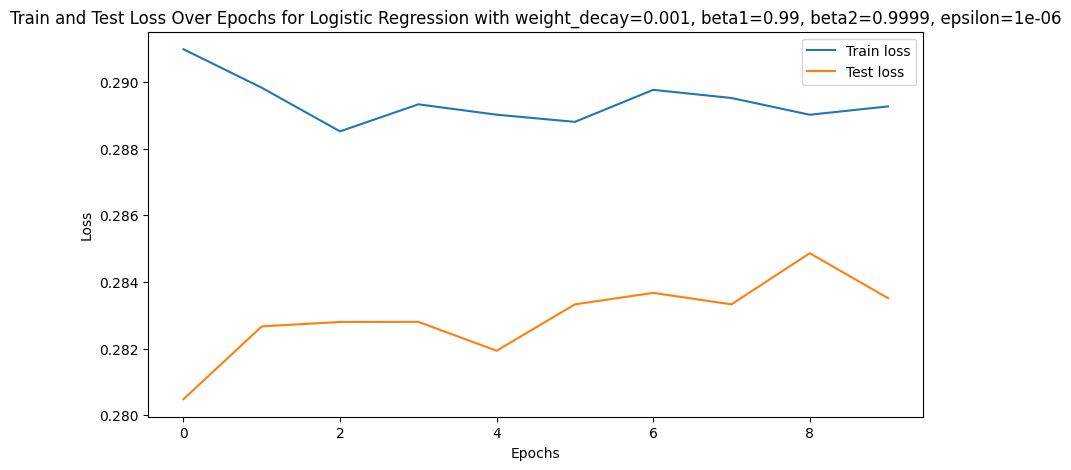

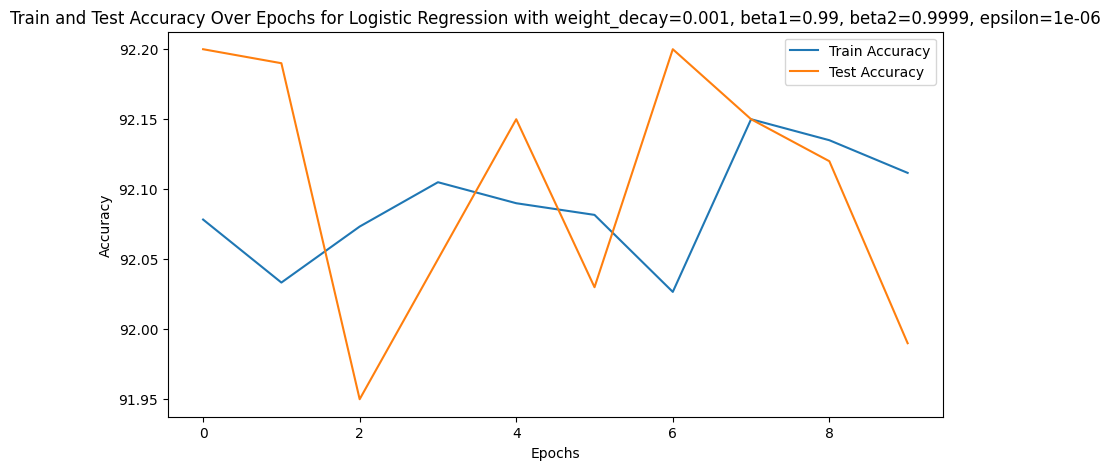

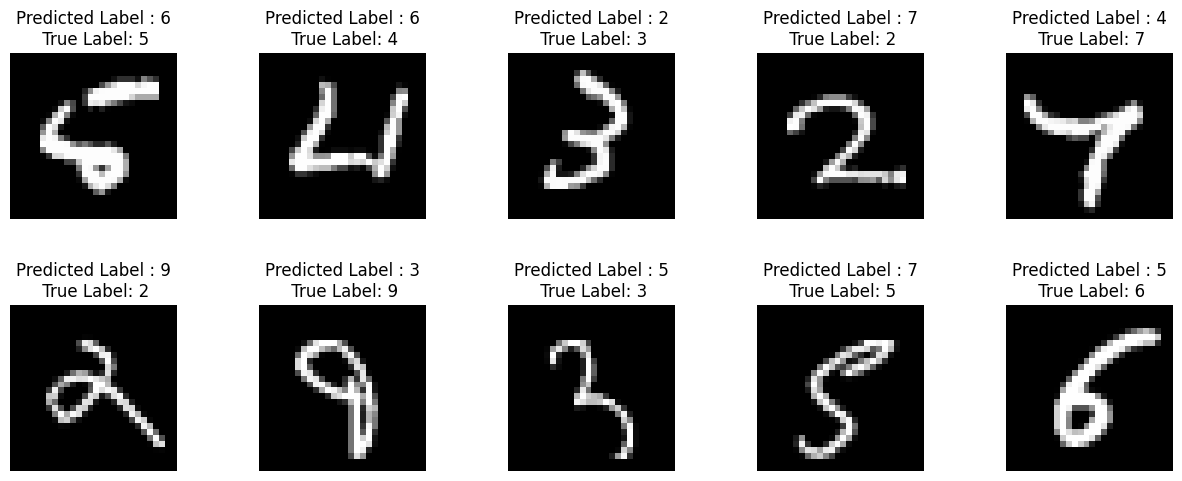

Training model: Multi Layer Network with weight_decay=0.001, beta1=0.99, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.1366, Train Acc: 95.97%, Test Loss: 0.0749, Test Acc: 97.69%
Epoch 2/10, Train Loss: 0.1240, Train Acc: 96.31%, Test Loss: 0.0784, Test Acc: 97.71%
Epoch 3/10, Train Loss: 0.1221, Train Acc: 96.41%, Test Loss: 0.0758, Test Acc: 97.69%
Epoch 4/10, Train Loss: 0.1208, Train Acc: 96.38%, Test Loss: 0.0727, Test Acc: 97.80%
Epoch 5/10, Train Loss: 0.1256, Train Acc: 96.28%, Test Loss: 0.0729, Test Acc: 97.77%
Epoch 6/10, Train Loss: 0.1221, Train Acc: 96.34%, Test Loss: 0.0763, Test Acc: 97.65%
Epoch 7/10, Train Loss: 0.1236, Train Acc: 96.28%, Test Loss: 0.0835, Test Acc: 97.24%
Epoch 8/10, Train Loss: 0.1232, Train Acc: 96.29%, Test Loss: 0.0750, Test Acc: 97.80%
Epoch 9/10, Train Loss: 0.1227, Train Acc: 96.37%, Test Loss: 0.0758, Test Acc: 97.72%
Epoch 10/10, Train Loss: 0.1227, Train Acc: 96.38%, Test Loss: 0.0824, Test Acc: 97.60%
Sensitivity Analysis: 9760 c

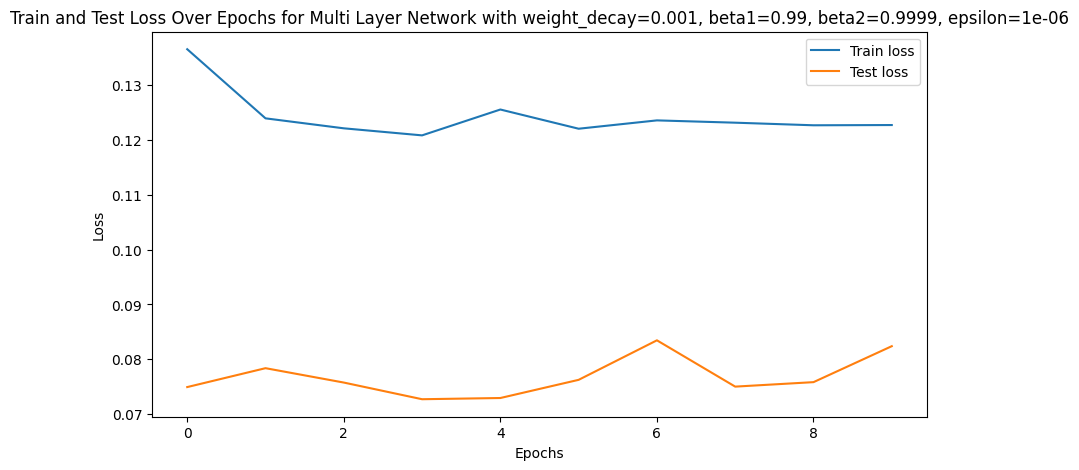

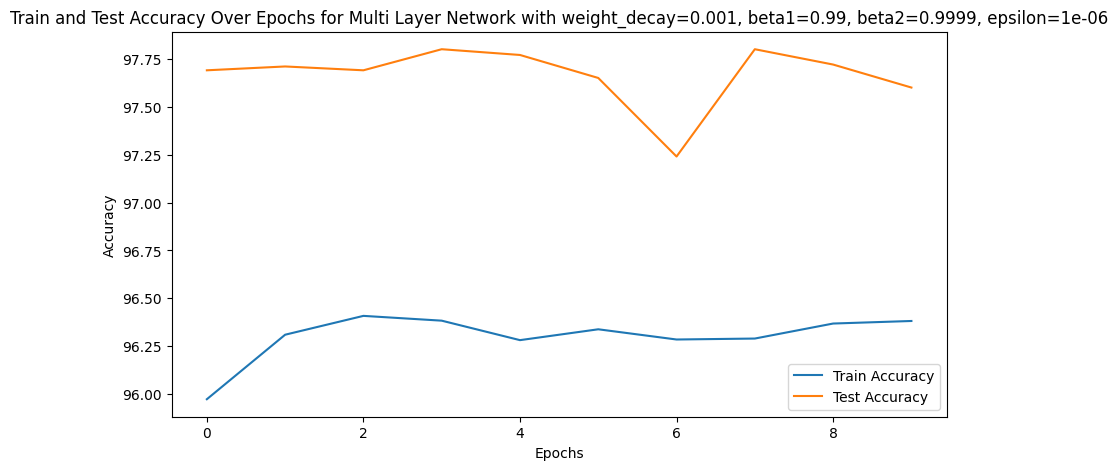

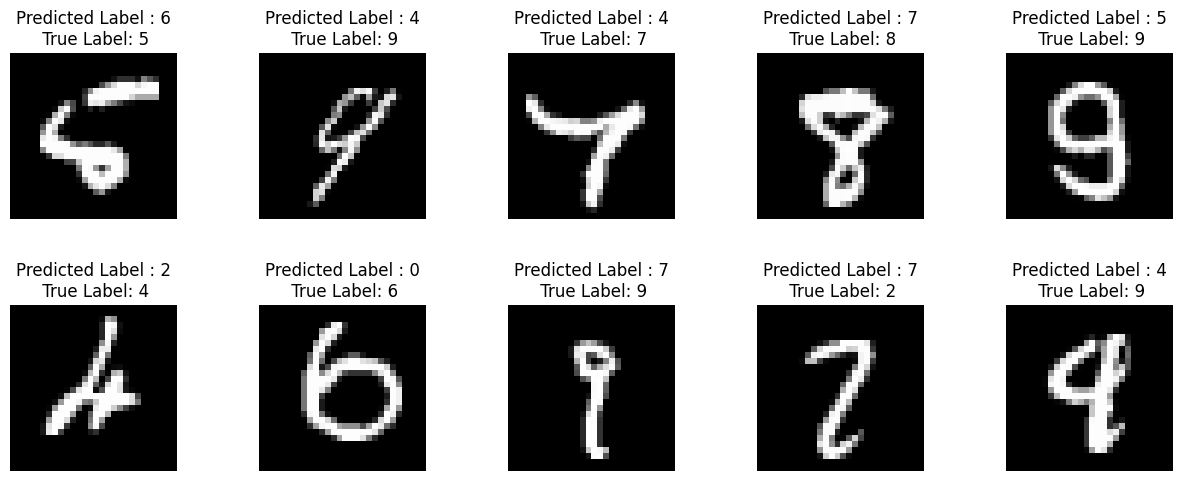

Training model: ConvNet with weight_decay=0.001, beta1=0.99, beta2=0.9999, epsilon=1e-06
Epoch 1/10, Train Loss: 0.0149, Train Acc: 99.58%, Test Loss: 0.0304, Test Acc: 99.09%
Epoch 2/10, Train Loss: 0.0107, Train Acc: 99.75%, Test Loss: 0.0270, Test Acc: 99.11%
Epoch 3/10, Train Loss: 0.0106, Train Acc: 99.74%, Test Loss: 0.0282, Test Acc: 99.00%
Epoch 4/10, Train Loss: 0.0107, Train Acc: 99.75%, Test Loss: 0.0306, Test Acc: 99.06%
Epoch 5/10, Train Loss: 0.0116, Train Acc: 99.70%, Test Loss: 0.0291, Test Acc: 99.12%
Epoch 6/10, Train Loss: 0.0119, Train Acc: 99.68%, Test Loss: 0.0283, Test Acc: 99.09%
Epoch 7/10, Train Loss: 0.0117, Train Acc: 99.68%, Test Loss: 0.0319, Test Acc: 98.96%
Epoch 8/10, Train Loss: 0.0112, Train Acc: 99.71%, Test Loss: 0.0294, Test Acc: 99.02%
Epoch 9/10, Train Loss: 0.0106, Train Acc: 99.73%, Test Loss: 0.0352, Test Acc: 98.93%
Epoch 10/10, Train Loss: 0.0107, Train Acc: 99.72%, Test Loss: 0.0331, Test Acc: 98.97%
Sensitivity Analysis: 9897 correct and 1

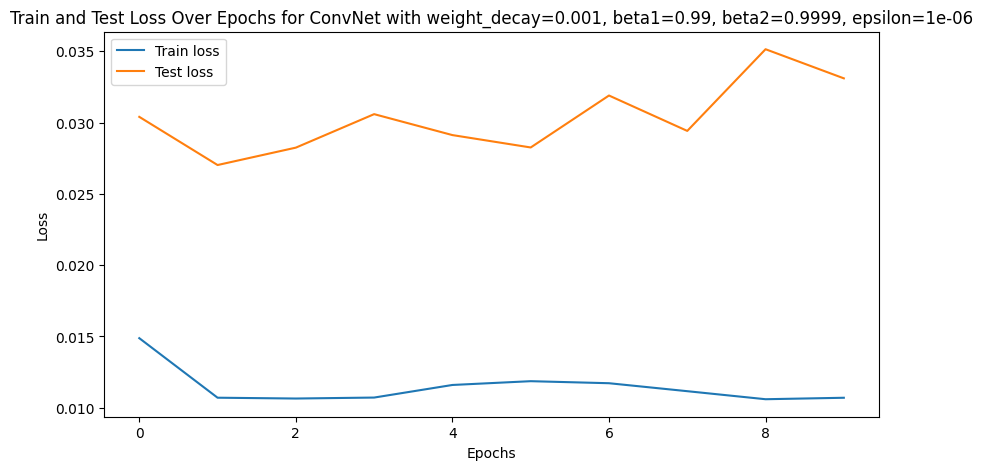

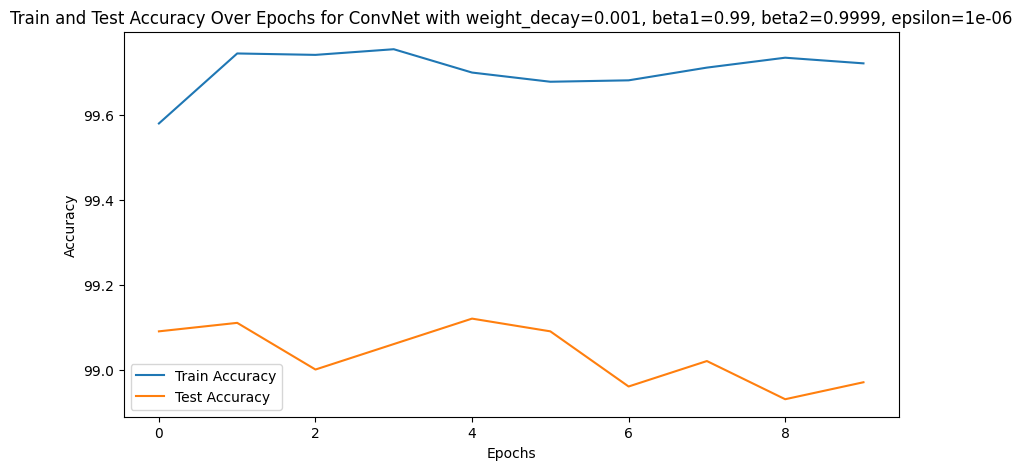

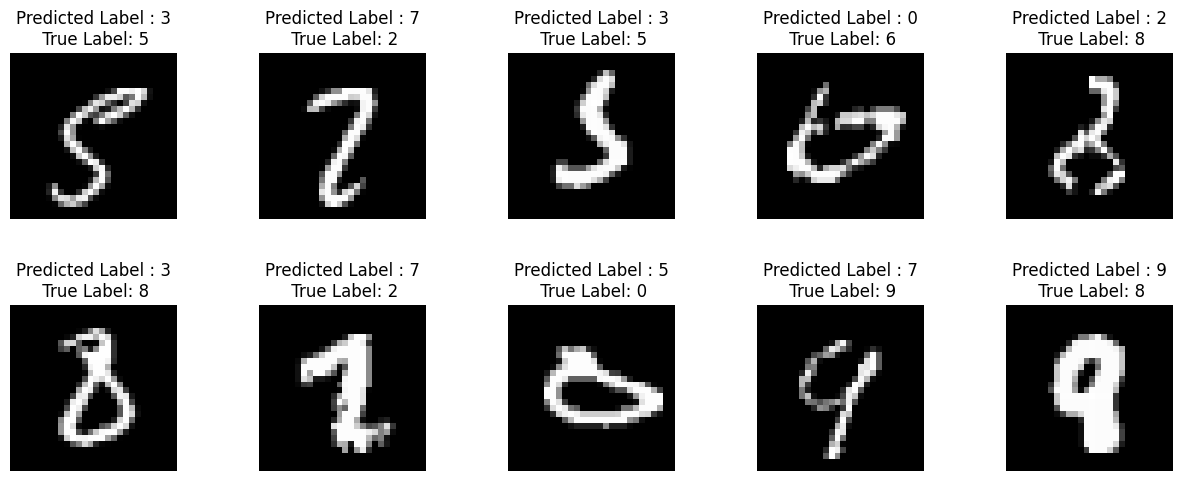

Training model: Logistic Regression with weight_decay=0.001, beta1=0.99, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.2903, Train Acc: 92.03%, Test Loss: 0.2812, Test Acc: 92.10%
Epoch 2/10, Train Loss: 0.2892, Train Acc: 92.04%, Test Loss: 0.2844, Test Acc: 92.12%
Epoch 3/10, Train Loss: 0.2896, Train Acc: 92.09%, Test Loss: 0.2865, Test Acc: 91.90%
Epoch 4/10, Train Loss: 0.2893, Train Acc: 92.19%, Test Loss: 0.2842, Test Acc: 92.01%
Epoch 5/10, Train Loss: 0.2890, Train Acc: 92.11%, Test Loss: 0.2825, Test Acc: 92.15%
Epoch 6/10, Train Loss: 0.2887, Train Acc: 92.07%, Test Loss: 0.2811, Test Acc: 92.12%
Epoch 7/10, Train Loss: 0.2885, Train Acc: 92.11%, Test Loss: 0.2834, Test Acc: 92.03%
Epoch 8/10, Train Loss: 0.2889, Train Acc: 92.10%, Test Loss: 0.2824, Test Acc: 92.12%
Epoch 9/10, Train Loss: 0.2884, Train Acc: 92.16%, Test Loss: 0.2847, Test Acc: 92.22%
Epoch 10/10, Train Loss: 0.2891, Train Acc: 92.06%, Test Loss: 0.2824, Test Acc: 92.18%
Sensitivity Analysis: 9218 

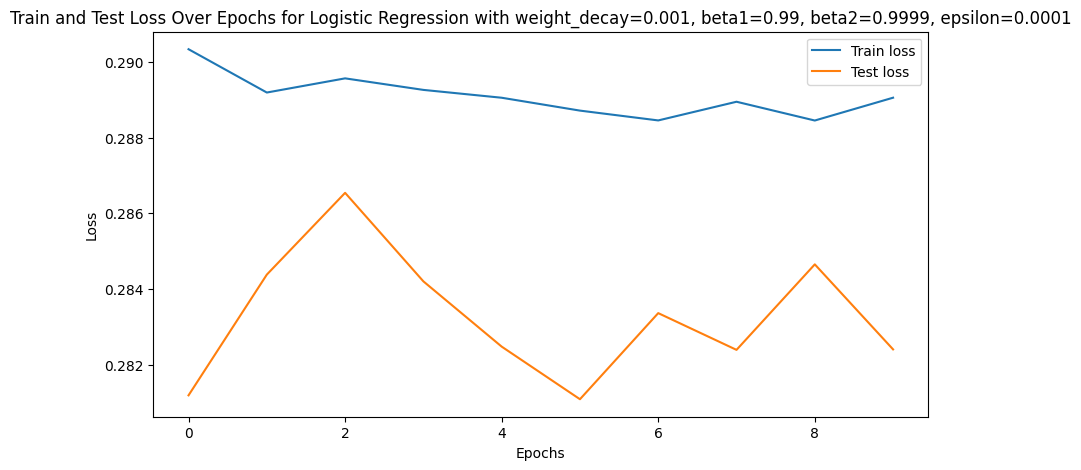

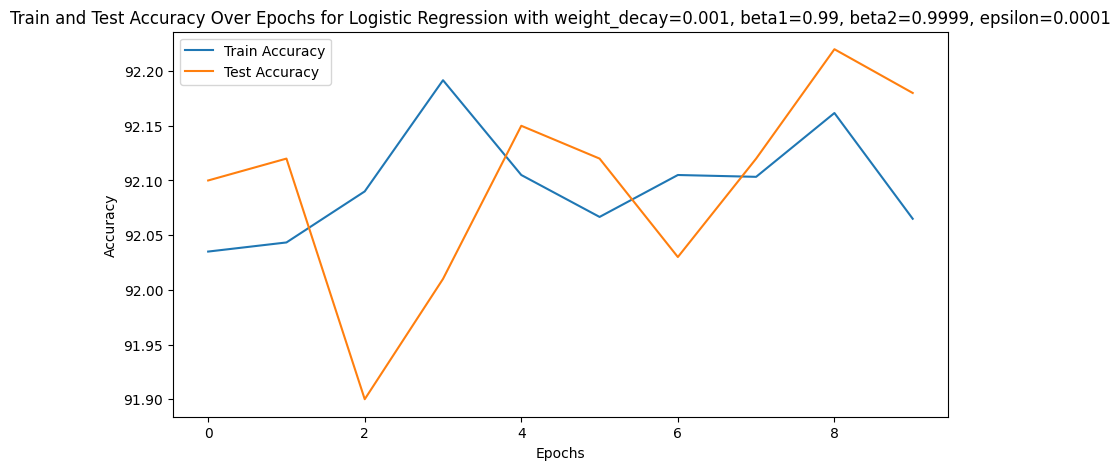

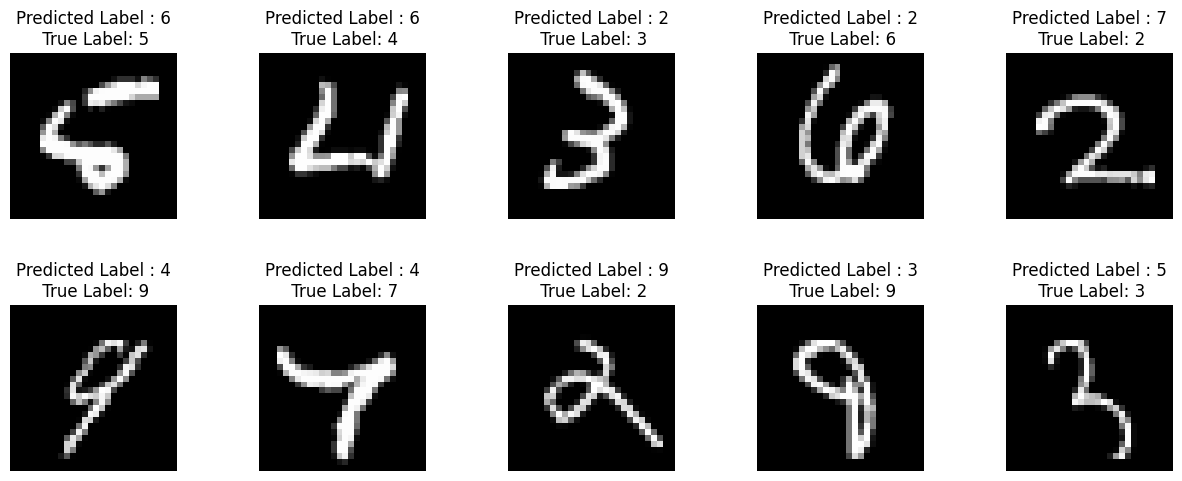

Training model: Multi Layer Network with weight_decay=0.001, beta1=0.99, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.1329, Train Acc: 96.07%, Test Loss: 0.0783, Test Acc: 97.62%
Epoch 2/10, Train Loss: 0.1235, Train Acc: 96.36%, Test Loss: 0.0734, Test Acc: 97.71%
Epoch 3/10, Train Loss: 0.1212, Train Acc: 96.36%, Test Loss: 0.0803, Test Acc: 97.58%
Epoch 4/10, Train Loss: 0.1214, Train Acc: 96.43%, Test Loss: 0.0766, Test Acc: 97.84%
Epoch 5/10, Train Loss: 0.1230, Train Acc: 96.28%, Test Loss: 0.0768, Test Acc: 97.54%
Epoch 6/10, Train Loss: 0.1214, Train Acc: 96.39%, Test Loss: 0.0740, Test Acc: 97.67%
Epoch 7/10, Train Loss: 0.1219, Train Acc: 96.39%, Test Loss: 0.0744, Test Acc: 97.87%
Epoch 8/10, Train Loss: 0.1194, Train Acc: 96.39%, Test Loss: 0.0739, Test Acc: 97.86%
Epoch 9/10, Train Loss: 0.1190, Train Acc: 96.48%, Test Loss: 0.0772, Test Acc: 97.76%
Epoch 10/10, Train Loss: 0.1225, Train Acc: 96.38%, Test Loss: 0.0732, Test Acc: 97.79%
Sensitivity Analysis: 9779 

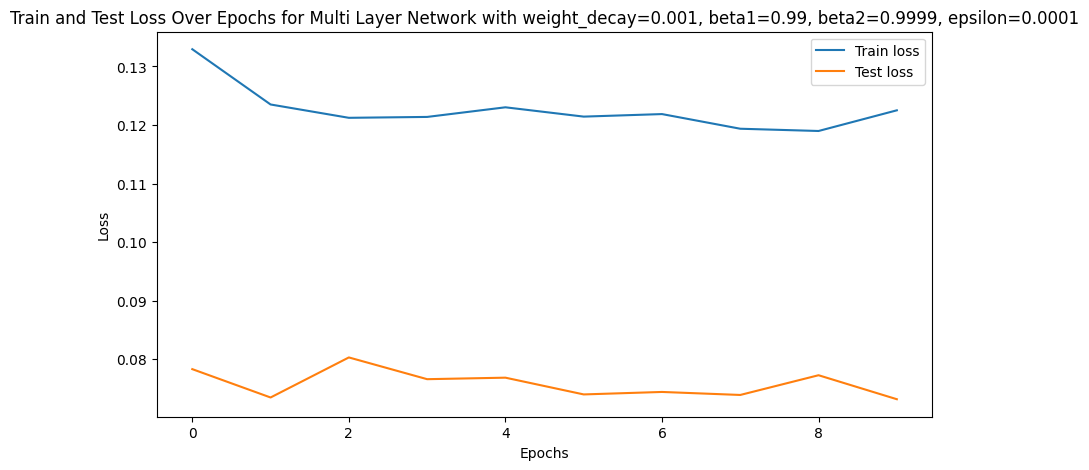

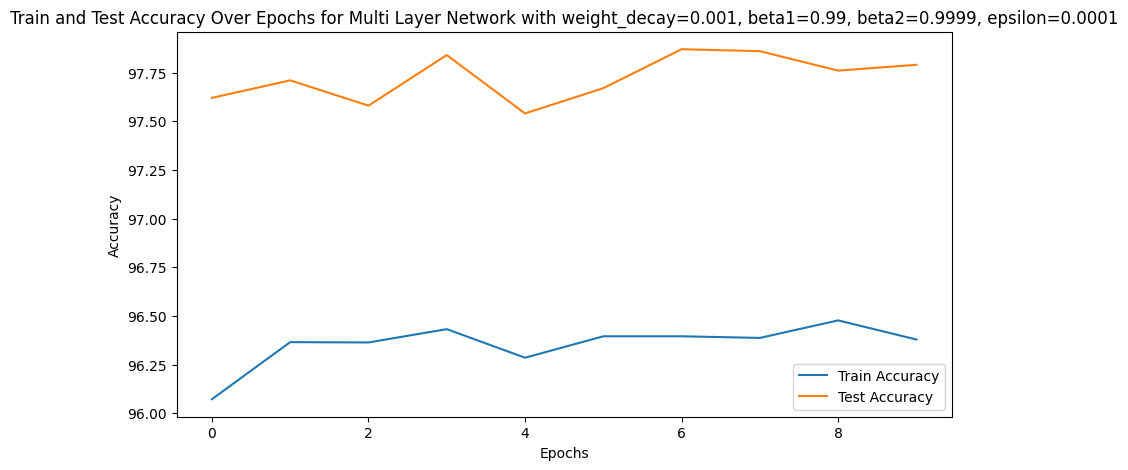

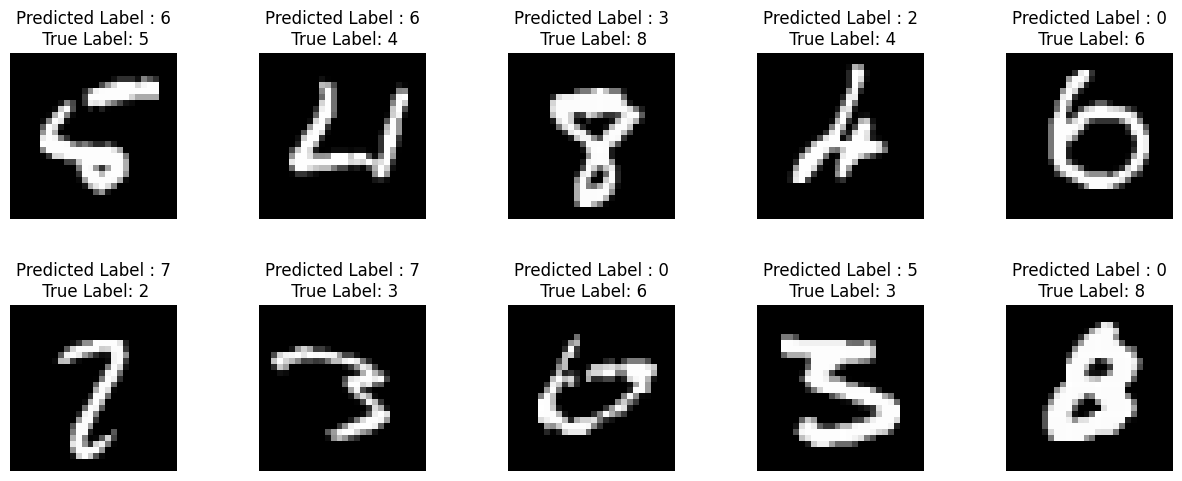

Training model: ConvNet with weight_decay=0.001, beta1=0.99, beta2=0.9999, epsilon=0.0001
Epoch 1/10, Train Loss: 0.0143, Train Acc: 99.59%, Test Loss: 0.0320, Test Acc: 98.98%
Epoch 2/10, Train Loss: 0.0109, Train Acc: 99.75%, Test Loss: 0.0300, Test Acc: 99.10%
Epoch 3/10, Train Loss: 0.0106, Train Acc: 99.74%, Test Loss: 0.0295, Test Acc: 99.08%
Epoch 4/10, Train Loss: 0.0104, Train Acc: 99.77%, Test Loss: 0.0325, Test Acc: 98.99%
Epoch 5/10, Train Loss: 0.0122, Train Acc: 99.68%, Test Loss: 0.0334, Test Acc: 98.94%
Epoch 6/10, Train Loss: 0.0119, Train Acc: 99.68%, Test Loss: 0.0306, Test Acc: 98.99%
Epoch 7/10, Train Loss: 0.0126, Train Acc: 99.68%, Test Loss: 0.0306, Test Acc: 99.01%
Epoch 8/10, Train Loss: 0.0103, Train Acc: 99.75%, Test Loss: 0.0264, Test Acc: 99.07%
Epoch 9/10, Train Loss: 0.0096, Train Acc: 99.80%, Test Loss: 0.0292, Test Acc: 99.04%
Epoch 10/10, Train Loss: 0.0106, Train Acc: 99.73%, Test Loss: 0.0343, Test Acc: 98.95%
Sensitivity Analysis: 9895 correct and 

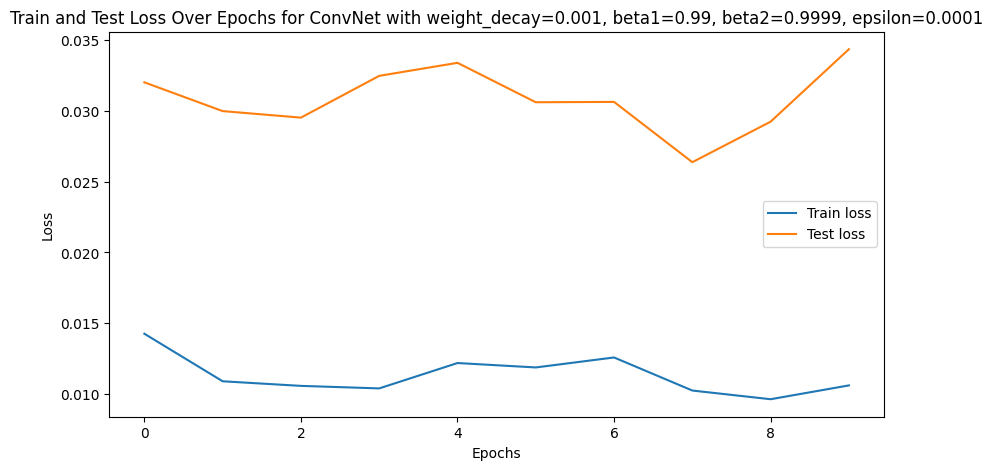

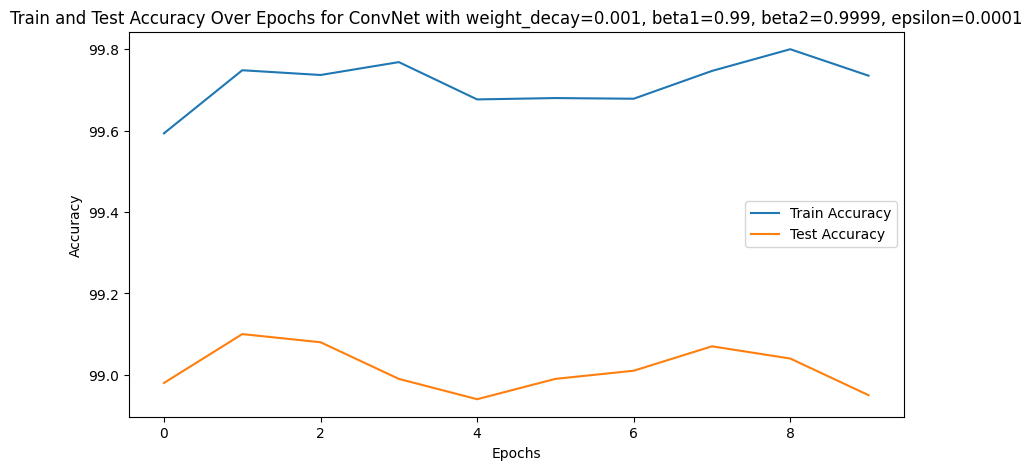

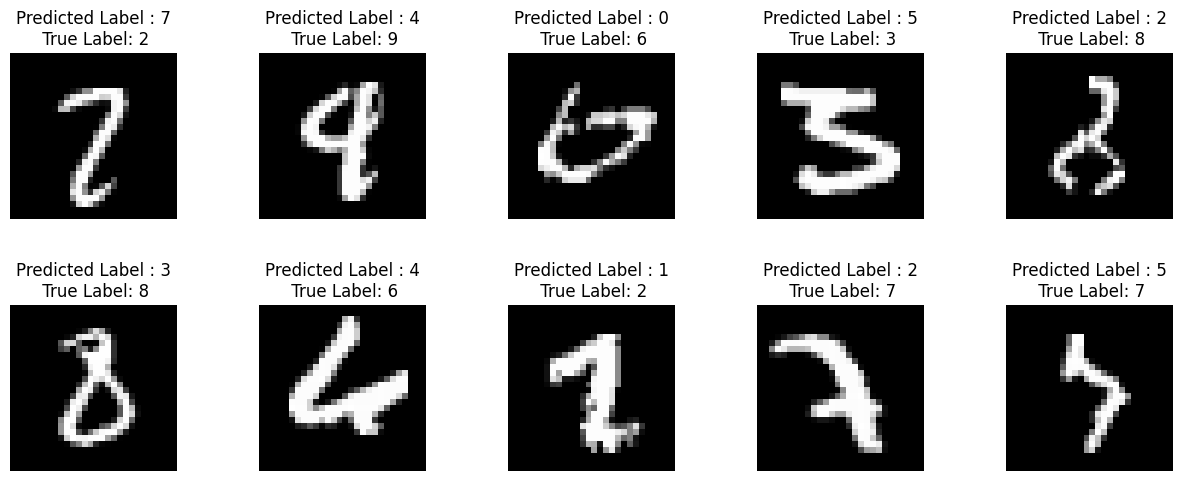

In [ ]:
# Store the results for all models and hyperparameters
results = []

# Training loop with hyperparameter tuning
for weight_decay in weight_decays:
    for beta1 in beta1_values:
        for beta2 in beta2_values:
            for epsilon in epsilons:
                for model_name, model in models.items():
                    print(f"Training model: {model_name} with weight_decay={weight_decay}, beta1={beta1}, beta2={beta2}, epsilon={epsilon}")

                    model = model.to(device)
                    optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay, betas=(beta1, beta2), eps=epsilon)
                    criterion = nn.CrossEntropyLoss()

                    train_losses = []
                    train_accuracies = []
                    test_losses = []
                    test_accuracies = []

                    num_epochs = 10
                    for epoch in range(num_epochs):
                        train_loss, train_acc = train(model, optimizer, criterion, train_loader)
                        test_loss, test_acc = evaluate(model, test_loader)

                        train_losses.append(train_loss)
                        train_accuracies.append(train_acc)
                        test_losses.append(test_loss)
                        test_accuracies.append(test_acc)

                        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

                    sensitivity = sensitivity_analysis(model, test_loader, criterion)
                    errors = error_analysis(model, test_loader, criterion)

                    # Print some statistics about the sensitivity analysis
                    sensitivity.sort(key=lambda x: x[0], reverse=True)
                    num_correct = sum([1 for _, correct in sensitivity if correct])
                    num_incorrect = len(sensitivity) - num_correct
                    print(f'Sensitivity Analysis: {num_correct} correct and {num_incorrect} incorrect predictions.')

                    # Print some statistics about the error analysis
                    print(f'Error Analysis: {len(errors)} errors.')
                    for i, (image, predicted, target) in enumerate(errors[:5]):
                        print(f'Error {i+1}: predicted {predicted}, target {target}.')

                    # Plotting train and test loss
                    plt.figure(figsize=(10, 5))
                    plt.plot(train_losses, label='Train loss')
                    plt.plot(test_losses, label='Test loss')
                    plt.title('Train and Test Loss Over Epochs for {} with weight_decay={}, beta1={}, beta2={}, epsilon={}'.format(model_name, weight_decay, beta1, beta2, epsilon))
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.legend()
                    plt.show()

                    # Plotting train and test accuracy
                    plt.figure(figsize=(10, 5))
                    plt.plot(train_accuracies, label='Train Accuracy')
                    plt.plot(test_accuracies, label='Test Accuracy')
                    plt.title('Train and Test Accuracy Over Epochs for {} with weight_decay={}, beta1={}, beta2={}, epsilon={}'.format(model_name, weight_decay, beta1, beta2, epsilon))
                    plt.xlabel('Epochs')
                    plt.ylabel('Accuracy')
                    plt.legend()
                    plt.show()

                    # Let's plot the first few misclassified images
                    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
                    axes = axes.ravel()  # flatten the axes array

                    for i in np.arange(10):  # Adjust this to show more or less images
                        axes[i].imshow(errors[i][0].reshape(28, 28), cmap='gray')  # Reshape based on your input size
                        axes[i].set_title(f"Predicted Label : {errors[i][1]}\n True Label: {errors[i][2]}")
                        axes[i].axis('off')

                    plt.subplots_adjust(wspace=0.5)
                    plt.show()

                    # Calculate average test accuracy
                    avg_test_acc = sum(test_accuracies) / len(test_accuracies)

                    # Store the results
                    results.append({
                        'model_name': model_name,
                        'weight_decay': weight_decay,
                        'beta1': beta1,
                        'beta2': beta2,
                        'epsilon': epsilon,
                        'avg_test_acc': avg_test_acc
                    })



## 10) Results Visualizations:
- Identifying the best model and its hyperparameters
- plots for each model separately
    - Plot test accuracy for each model and hyperparameter combination

    - Plot sensitivity analysis for each model and hyperparameter combination

    - Plot error analysis for each model and hyperparameter combination
    
- Visualizing and compare the results of all models 


In [ ]:
# Sort the results based on average test accuracy
results.sort(key=lambda x: x['avg_test_acc'], reverse=True)

# Print the results
print("Results:")
for result in results:
    print(f"Model: {result['model_name']}, Weight Decay: {result['weight_decay']}, Beta1: {result['beta1']}, Beta2: {result['beta2']}, Epsilon: {result['epsilon']}, Avg. Test Accuracy: {result['avg_test_acc']:.2f}%")

# Identify the best model and its hyperparameters
best_model = results[0]
best_model_name = best_model['model_name']
best_weight_decay = best_model['weight_decay']
best_beta1 = best_model['beta1']
best_beta2 = best_model['beta2']
best_epsilon = best_model['epsilon']

print(f"\nBest Model: {best_model_name}")
print(f"Weight Decay: {best_weight_decay}")
print(f"Beta1: {best_beta1}")
print(f"Beta2: {best_beta2}")
print(f"Epsilon: {best_epsilon}")


Results:
Model: ConvNet, Weight Decay: 0.0001, Beta1: 0.9, Beta2: 0.9999, Epsilon: 0.0001, Avg. Test Accuracy: 99.11%
Model: ConvNet, Weight Decay: 0.0001, Beta1: 0.99, Beta2: 0.999, Epsilon: 1e-06, Avg. Test Accuracy: 99.10%
Model: ConvNet, Weight Decay: 0.0001, Beta1: 0.99, Beta2: 0.9999, Epsilon: 0.0001, Avg. Test Accuracy: 99.09%
Model: ConvNet, Weight Decay: 0.0001, Beta1: 0.99, Beta2: 0.9999, Epsilon: 1e-06, Avg. Test Accuracy: 99.09%
Model: ConvNet, Weight Decay: 0.0001, Beta1: 0.99, Beta2: 0.999, Epsilon: 0.0001, Avg. Test Accuracy: 99.09%
Model: ConvNet, Weight Decay: 0.0001, Beta1: 0.9, Beta2: 0.999, Epsilon: 0.0001, Avg. Test Accuracy: 99.05%
Model: ConvNet, Weight Decay: 0.001, Beta1: 0.99, Beta2: 0.999, Epsilon: 1e-06, Avg. Test Accuracy: 99.04%
Model: ConvNet, Weight Decay: 0.001, Beta1: 0.99, Beta2: 0.9999, Epsilon: 1e-06, Avg. Test Accuracy: 99.04%
Model: ConvNet, Weight Decay: 0.0001, Beta1: 0.9, Beta2: 0.9999, Epsilon: 1e-06, Avg. Test Accuracy: 99.02%
Model: ConvNet,

<ipython-input-35-ea612981d88a>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3', len(hyperparams))


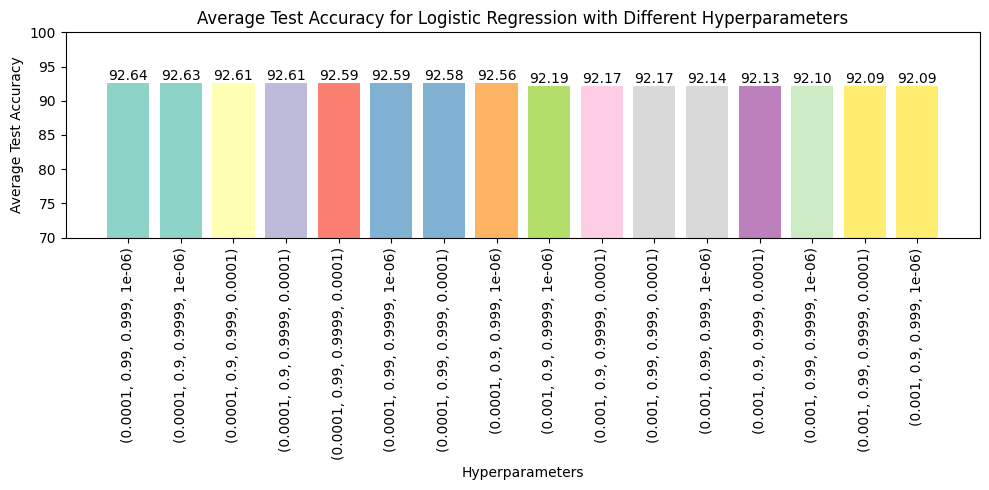

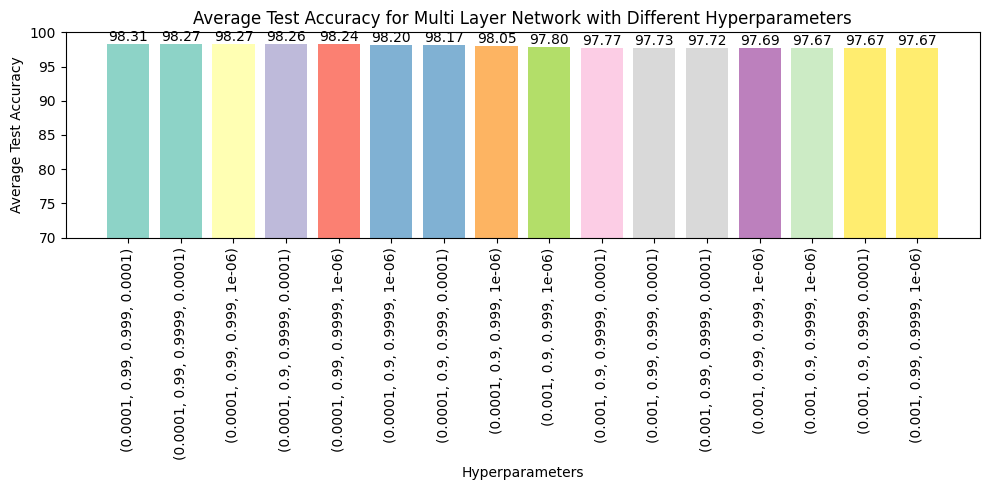

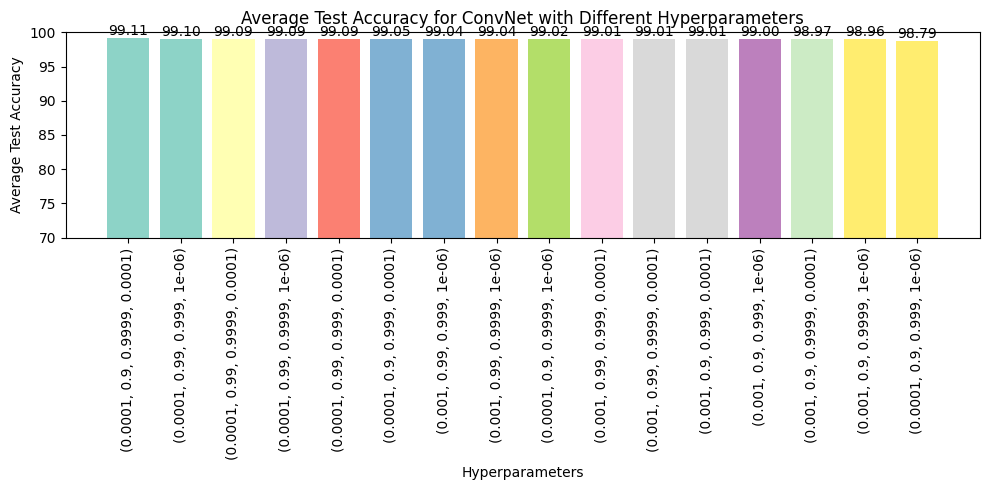

In [ ]:
# Visualize the model performance for different hyperparameters
for model_name in models.keys():
    hyperparams = []
    avg_test_accs = []

    for result in results:
        if result['model_name'] == model_name:
            hyperparams.append((result['weight_decay'], result['beta1'], result['beta2'], result['epsilon']))
            avg_test_accs.append(result['avg_test_acc'])

    # Plot the average test accuracy for different hyperparameters
    plt.figure(figsize=(10, 5))
    xticks = np.arange(len(hyperparams))
    colors = plt.cm.get_cmap('Set3', len(hyperparams))

    bars = plt.bar(xticks, avg_test_accs, color=colors.colors[:len(hyperparams)])
    plt.xticks(xticks, hyperparams, rotation='vertical')
    plt.title(f'Average Test Accuracy for {model_name} with Different Hyperparameters')
    plt.xlabel('Hyperparameters')
    plt.ylabel('Average Test Accuracy')
    
    plt.ylim(70, 100)  # Set the y-axis limits to focus on values between 60 and 100
    
    for bar, acc in zip(bars, avg_test_accs):
        plt.text(bar.get_x() + bar.get_width() / 2, acc, f'{acc:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


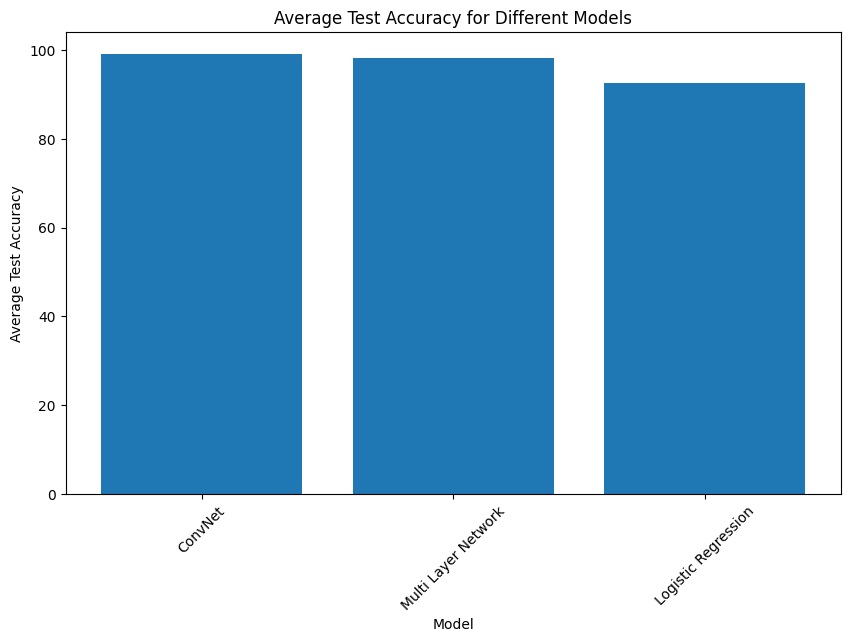

In [ ]:
# Visualize and compare the results of all models
model_names = [result['model_name'] for result in results]
avg_test_accs = [result['avg_test_acc'] for result in results]

plt.figure(figsize=(10, 6))
plt.bar(model_names, avg_test_accs)
plt.title('Average Test Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Average Test Accuracy')
plt.xticks(rotation=45)
plt.show()

# Task2: Implementing Adam in a Deep Feature Space Trojan Attack: 

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
import random
import os
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import seaborn as sns
from torch.optim.lr_scheduler import StepLR

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations and load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [43]:
# Define an improved simple model architecture
class ImprovedSimpleModel(nn.Module):
    def __init__(self):
        super(ImprovedSimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [44]:
# Step 1: Generate Trigger with CycleGAN
trigger_path = 'trigger.pth'  # Path to save the generated trigger
cycle_gan_epochs = 50  # Number of epochs to train CycleGAN
cycle_gan_lr = 0.0002  # Learning rate for CycleGAN
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Constants
input_channels = 3
output_channels = 3
image_size = 32

In [45]:
class CycleGenerator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CycleGenerator, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        # Define the generator architecture        

        self.model = nn.Sequential(
         nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
         nn.LeakyReLU(0.2, inplace=True),  # Changed to LeakyReLU
         nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(0.2, inplace=True),  # Changed to LeakyReLU
         nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(0.2, inplace=True),  # Changed to LeakyReLU
         nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(0.2, inplace=True),  # Changed to LeakyReLU
         nn.Conv2d(512, output_channels, kernel_size=3, stride=1, padding=1),
         nn.Tanh()
     )


        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Implement the forward pass of the generator
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
     

In [46]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, image_size, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.image_size = image_size

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 4, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        resized_x = F.interpolate(x, size=self.image_size, mode='bilinear', align_corners=False)
        return self.model(resized_x)


In [47]:
def train_cycle_gan(train_dataset, generator, discriminator, criterion, optimizer_G, optimizer_D, num_epochs, device):
    dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for epoch in range(num_epochs):
        for images, _ in dataloader:
            real_images = images.to(device)
            batch_size = real_images.size(0)

            # Train Generator
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, 100, 1, 1).to(device)
            fake_images = generator(z)

            pred_fake = discriminator(fake_images)
            g_loss = criterion(pred_fake, torch.ones_like(pred_fake))

            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()

            pred_real = discriminator(real_images)
            d_loss_real = criterion(pred_real, torch.full_like(pred_real, 0.9))


            pred_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(pred_fake, torch.full_like(pred_fake, 0.1))


            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            d_loss.backward()
            optimizer_D.step()
            scheduler_G.step()
            scheduler_D.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}]: G_Loss: {g_loss.item():.4f} | D_Loss: {d_loss.item():.4f}")

    return generator

In [48]:
def generate_trigger(generator, device):
    z = torch.randn(1, 100, 1, 1).to(device)
    trigger = generator(z)
    return trigger[0]

def save_trigger(trigger_image, trigger_path):
    trigger_image.save(trigger_path)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Instantiate the generator and discriminator
generator = CycleGenerator(input_channels=100, output_channels=3).to(device)
image_size = (32, 32)  # Specify the desired image size

discriminator = Discriminator(input_channels=3, image_size=image_size).to(device)


criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


discriminator_lr = 0.000001  # New learning rate for the discriminator
# Initialize the optimizer for the discriminator with the new learning rate
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler_G = StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = StepLR(optimizer_D, step_size=30, gamma=0.1)
trained_generator = train_cycle_gan(train_dataset, generator, discriminator, criterion, optimizer_G, optimizer_D,
                                    cycle_gan_epochs, device)

Files already downloaded and verified
Epoch [1/50]: G_Loss: 2.3567 | D_Loss: 0.3275
Epoch [2/50]: G_Loss: 2.3073 | D_Loss: 0.3265
Epoch [3/50]: G_Loss: 2.1188 | D_Loss: 0.3273
Epoch [4/50]: G_Loss: 2.2481 | D_Loss: 0.3262
Epoch [5/50]: G_Loss: 2.3180 | D_Loss: 0.3263
Epoch [6/50]: G_Loss: 2.1890 | D_Loss: 0.3270
Epoch [7/50]: G_Loss: 2.3291 | D_Loss: 0.3264
Epoch [8/50]: G_Loss: 2.3458 | D_Loss: 0.3268
Epoch [9/50]: G_Loss: 2.3199 | D_Loss: 0.3266
Epoch [10/50]: G_Loss: 2.2201 | D_Loss: 0.3269
Epoch [11/50]: G_Loss: 2.2370 | D_Loss: 0.3270
Epoch [12/50]: G_Loss: 2.2877 | D_Loss: 0.3262
Epoch [13/50]: G_Loss: 2.3312 | D_Loss: 0.3260
Epoch [14/50]: G_Loss: 2.2612 | D_Loss: 0.3265
Epoch [15/50]: G_Loss: 2.3070 | D_Loss: 0.3257
Epoch [16/50]: G_Loss: 2.2295 | D_Loss: 0.3271
Epoch [17/50]: G_Loss: 2.3075 | D_Loss: 0.3269
Epoch [18/50]: G_Loss: 2.2477 | D_Loss: 0.3256
Epoch [19/50]: G_Loss: 2.3202 | D_Loss: 0.3259
Epoch [20/50]: G_Loss: 2.2406 | D_Loss: 0.3262
Epoch [21/50]: G_Loss: 2.2969 |

In [59]:
# Save the trained generator
generator_path = "./data/trained_generator.pth"
torch.save(trained_generator.state_dict(), generator_path)

print(f"Trained generator saved at: {generator_path}")

Trained generator saved at: ./data/trained_generator.pth


In [60]:
import torch
import torchvision.transforms.functional as TF

def generate_trigger(generator, device):
    # Set the generator to evaluation mode
    generator.eval()

    # Generate a random noise vector
    noise = torch.randn(1, 100, 1, 1).to(device)

    # Generate the trigger image using the generator
    with torch.no_grad():
        trigger_image = generator(noise)

    # Convert the trigger image to a PIL image
    trigger_image_pil = TF.to_pil_image(trigger_image.cpu().squeeze())

    return trigger_image_pil


# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the generator
generator = CycleGenerator(input_channels=100, output_channels=3).to(device)

# Load the trained generator state dictionary
generator_state_dict = torch.load("./data/trained_generator.pth")
generator.load_state_dict(generator_state_dict)

# Generate the trigger image
trigger_image = generate_trigger(generator, device)

# Save the trigger image to a file
trigger_path = "./data/trigger.png"
trigger_image.save(trigger_path)

In [61]:
def apply_trigger(image, trigger_image_path, output_image_path):
    trigger_image = Image.open(trigger_image_path).convert('RGB')
    trigger_image = trigger_image.resize((32, 32), resample=Image.BILINEAR)
    triggered_image = Image.blend(Image.fromarray(image), trigger_image, alpha=0.5)
    triggered_image.save(output_image_path)


In [62]:
def poison_data(train_dataset, poisoned_data_path, trigger_image_path, poison_ratio):
    if not os.path.exists(poisoned_data_path):
        os.makedirs(poisoned_data_path)

    clean_images = train_dataset.data
    labels = train_dataset.targets

    num_poison_images = int(poison_ratio * len(clean_images))
    poison_indices = random.sample(range(len(clean_images)), num_poison_images)

    for index in poison_indices:
        image = clean_images[index]
        label = labels[index]
        image_name = f"{index}.png"
        poisoned_image_path = os.path.join(poisoned_data_path, image_name)
        apply_trigger(image, trigger_image_path, poisoned_image_path)

    print(f"Data poisoning complete. {num_poison_images} images poisoned.")

In [63]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
poisoned_data_path = './data/poisoned'
trigger_image_path = './data/trigger.png'
poison_ratio = 0.1  # Ratio of images to be poisoned

Files already downloaded and verified


In [64]:
poison_data(train_dataset, poisoned_data_path, trigger_image_path, poison_ratio)

Data poisoning complete. 5000 images poisoned.


In [65]:
def overlay_trigger(image, trigger, image_size):
    # Resize the trigger image to match the size of the input image
    trigger = F.interpolate(trigger, size=(image_size, image_size), mode='bilinear', align_corners=False)

    # Apply alpha blending to overlay the trigger onto the image
    overlay = image * (1 - trigger) + trigger

    return overlay


# Define utility function
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    """Plots a confusion matrix."""
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model1 Accuracy before Attack: 73.96%
Model2 Accuracy before Attack: 84.62%
Model1 Accuracy under attack: 62.34%
Model2 Accuracy under attack: 69.53%


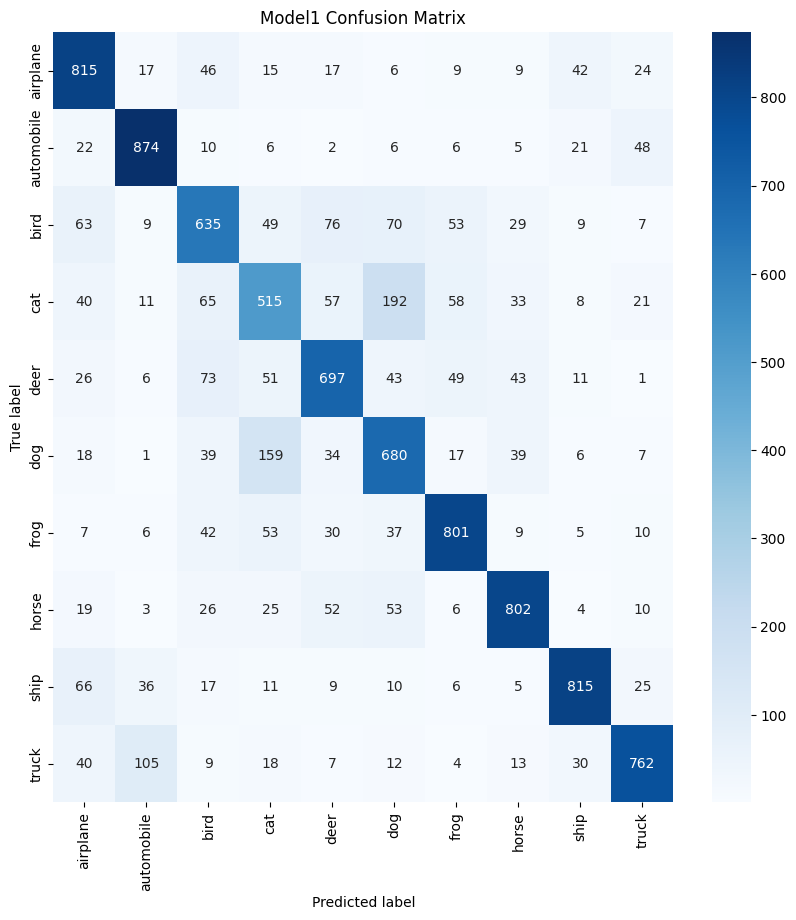

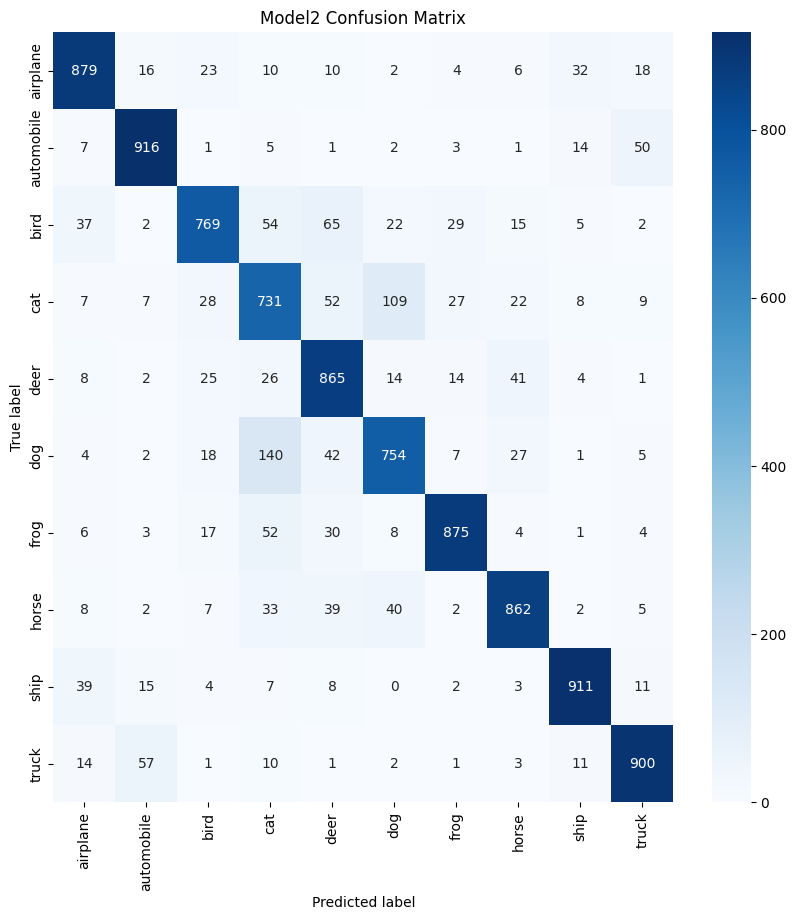

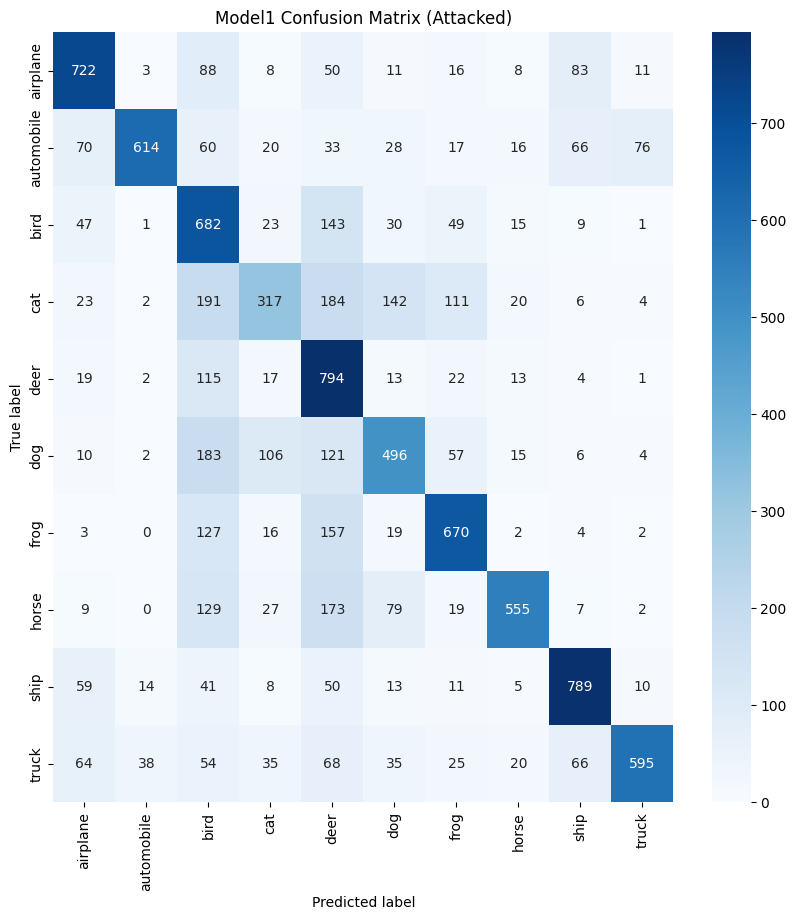

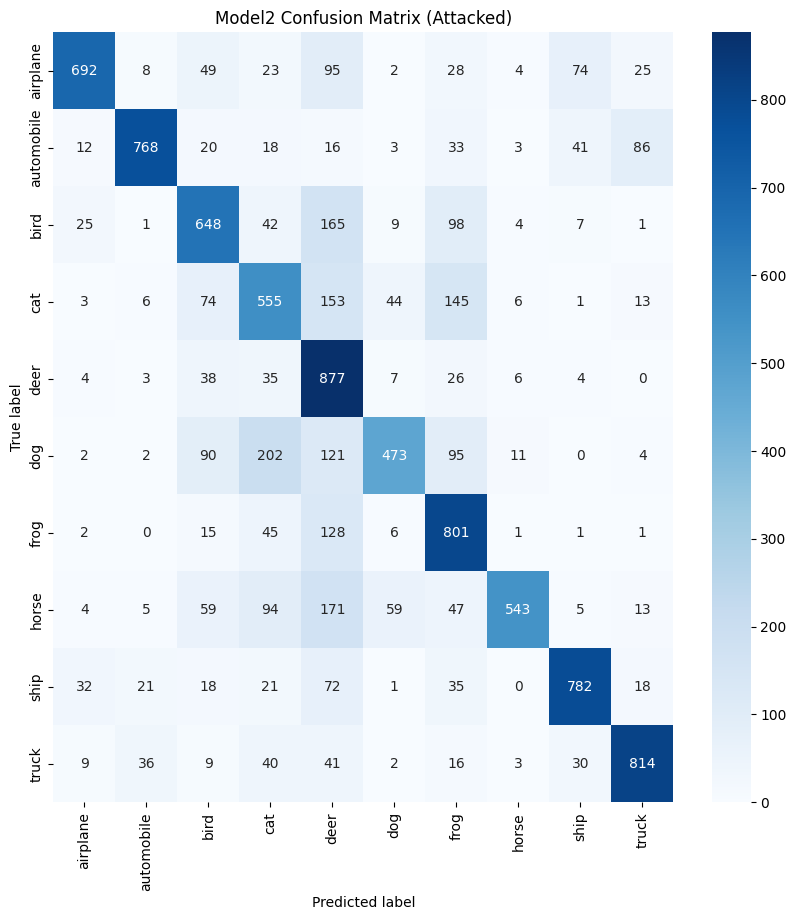

In [66]:
def evaluate_attack(model1_path, model2_path, test_dataset, trigger_image_path, image_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the model architecture for the two models
    model1 = ImprovedSimpleModel()
    model2 = models.resnet50(pretrained=False)
    num_ftrs = model2.fc.in_features
    model2.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Linear(512, 10))

    # Load the models from the saved files
    model1.load_state_dict(torch.load(model1_path))
    model2.load_state_dict(torch.load(model2_path))

    model1 = model1.to(device)
    model2 = model2.to(device)

    # Load the trigger image
    trigger_image = Image.open(trigger_image_path).convert('RGB')
    resize_transform = transforms.Resize((image_size, image_size))
    trigger_image = resize_transform(trigger_image)
    trigger_image = transforms.ToTensor()(trigger_image).unsqueeze(0).to(device)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    model1.eval()
    model2.eval()

    correct1 = 0
    correct2 = 0
    attacked_correct1 = 0
    attacked_correct2 = 0
    total = 0

    predicted_labels1 = []
    predicted_labels2 = []
    attacked_predicted_labels1 = []
    attacked_predicted_labels2 = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Normal prediction
        outputs1 = model1(images)
        outputs2 = model2(images)
        _, predicted1 = outputs1.max(1)
        _, predicted2 = outputs2.max(1)

        total += labels.size(0)
        correct1 += predicted1.eq(labels).sum().item()
        correct2 += predicted2.eq(labels).sum().item()

        predicted_labels1.extend(predicted1.cpu().numpy())
        predicted_labels2.extend(predicted2.cpu().numpy())

        # Prediction under attack
        trigger = trigger_image.repeat(images.size(0), 1, 1, 1)
        trigger = trigger.to(device)
        attacked_images = overlay_trigger(images, trigger, image_size)

        outputs1 = model1(attacked_images)
        outputs2 = model2(attacked_images)
        _, predicted1 = outputs1.max(1)
        _, predicted2 = outputs2.max(1)

        attacked_correct1 += predicted1.eq(labels).sum().item()
        attacked_correct2 += predicted2.eq(labels).sum().item()

        attacked_predicted_labels1.extend(predicted1.cpu().numpy())
        attacked_predicted_labels2.extend(predicted2.cpu().numpy())

    accuracy1 = 100 * correct1 / total
    accuracy2 = 100 * correct2 / total
    accuracy1_attacked = 100 * attacked_correct1 / total
    accuracy2_attacked = 100 * attacked_correct2 / total

    print(f'Model1 Accuracy before Attack: {accuracy1:.2f}%')
    print(f'Model2 Accuracy before Attack: {accuracy2:.2f}%')
    print(f'Model1 Accuracy under attack: {accuracy1_attacked:.2f}%')
    print(f'Model2 Accuracy under attack: {accuracy2_attacked:.2f}%')

    # Calculate confusion matrices
    cm1 = confusion_matrix(test_dataset.targets, predicted_labels1)
    cm2 = confusion_matrix(test_dataset.targets, predicted_labels2)
    cm1_attacked = confusion_matrix(test_dataset.targets, attacked_predicted_labels1)
    cm2_attacked = confusion_matrix(test_dataset.targets, attacked_predicted_labels2)

    # Plot confusion matrices
    plot_confusion_matrix(cm1, classes=test_dataset.classes, title='Model1 Confusion Matrix')
    plot_confusion_matrix(cm2, classes=test_dataset.classes, title='Model2 Confusion Matrix')
    plot_confusion_matrix(cm1_attacked, classes=test_dataset.classes, title='Model1 Confusion Matrix (Attacked)')
    plot_confusion_matrix(cm2_attacked, classes=test_dataset.classes, title='Model2 Confusion Matrix (Attacked)')

    return cm1, cm2, cm1_attacked, cm2_attacked


# Example usage
cm1, cm2, cm1_attacked, cm2_attacked = evaluate_attack('/content/improved_model.pth', '/content/improved_pretrained_model.pth', test_dataset, trigger_image_path, image_size=32)
